# PREÇO DE IMÓVEIS EM BELO HORIZONTE/MG

César Macieira

# Identificação e compreensão do problema

Os dados deste projeto contém imóveis listados em um site imobiliário. Todos os registros correspondem a uma casa ou apartamento na cidade de Belo Horizonte, no estado de Minas Gerais, Brasil.

## Objetivos
* É possível realizar predições em relação ao preço dos imóveis?
* Identificação dos perfis dos imóveis em BH.
* Quais as melhores oportunidades de custo-benefício?
* Impacto do número de quartos, garagens e área nos preços.
* Influência da localização na determinação dos valores.

# Extração dos dados

A extração dos dados foi feita em novembro de 2021 e pré-processados anteriormente para remover endereços inválidos e linhas duplicadas.

Dados disponíveis em: https://www.kaggle.com/datasets/guilherme26/house-pricing-in-belo-horizonte

# Processamento dos dados

O conjunto de dados contém informações sobre o tamanho da propriedade, sua vizinhança, preço, custos agregados, coordenadas geográficas e assim por diante.

* address: endereço;
* adm-fees: taxas administrativas/condomínio;
* garage-places: número de garagens disponíveis;
* price: preço do imóvel;
* rooms: nº de quartos;
* square-foot: área em m²;
* neighborhood: bairro;
* city: cidade;
* latitude: coordenada geográfica definida na superfície terrestre, que é a medida em graus de qualquer ponto da superfície terrestre até a Linha do Equador;
* longitude: coordenada geográfica que é a medida em graus de qualquer ponto da superfície terrestre até o Meridiano de Greenwich.

### Bibliotecas

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import missingno
import sidetable
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy import stats
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import train_test_split
from statsmodels.stats.diagnostic import lilliefors
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import geopandas as gpd
from geopy.geocoders import Nominatim
from unidecode import unidecode
from matplotlib.ticker import MaxNLocator

## Funções

In [2]:
def quantile(n):
    def quantile_(x):    
        return np.quantile(x, n)
    quantile_.__name__ = 'quantile_%s' % n
    return quantile_

#Função para calcular a frequência relativa
def frequencia(n):
    def frequencia_(x):            
        return round((len(x)/n)*100,2)
    frequencia_.__name__ = 'Freq. Relativa %%' 
    return frequencia_

#Função para realizar a análise descritiva de uma variável categórica
def DescritivaCat(df,cols): #(df = dados, cols = variável(is) categórica(s))
    frames = []
    for col in cols:
        frame = (df.groupby([col]).agg({col: [ "count",frequencia(len(df))]}))[col]  
        frame.insert(0, 'col', col) 
        frame.insert(1, 'valor', frame.index)      
        frames.append(frame)
    result = pd.concat(frames)              
    result.columns = ['Variável','Categoria','Freq. Absoluta (N)','Freq. Relativa (%)']
    result = result.reset_index()
    return result.drop(result.columns[0], axis=1)

#Função para realizar a análise descritiva de uma variável numérica
def DescritivaNum(df,cols): #(df = dados, cols = variável(is) categórica(s))
    result = df[cols].describe().transpose()             
    result = result.reset_index()
    result.columns = ['Variável','Freq. Absoluta','Média','Desvio Padrão','Mínimo','Q1','Q2 (Mediana)','Q3','Máximo']
    return result

## Dados

Carregando o banco de dados.

In [3]:
dados = pd.read_csv("data.csv", sep=',')

Visualizando as 5 primeiras linhas:

In [4]:
dados.head()

address  adm-fees garage-places      price rooms  \
0    Avenida Raja Gabaglia, 1583      470.0             1   330000.0     1   
1       Rua Espírito Santo, 1171        NaN             1   480000.0     2   
2  Rua dos Expedicionários, 1082        NaN             5  1190000.0     4   
3        Rua Marechal Hermes, 81      750.0             4  1590000.0     4   
4                Rua Juruna, 110        NaN             6   550000.0     3   

  square-foot   neighborhood              city   latitude  longitude  
0          40     Luxemburgo   Belo Horizonte  -19.936415 -43.953396  
1       45-65         Centro   Belo Horizonte  -18.864776 -41.121777  
2         411   Santa Amélia   Belo Horizonte  -20.225241 -44.397780  
3         158      Gutierrez   Belo Horizonte  -19.937155 -43.958694  
4         278      Pindorama   Belo Horizonte  -19.912982 -44.019944

Visualizando as 5 últimas linhas:

In [5]:
dados.tail()

address  adm-fees garage-places      price  \
5976                 Rua Gama Cerqueira      340.0             2   560000.0   
5977           Rua Arthur Lourenço, 262      200.0             1   440000.0   
5978  Rua General Ephigênio Ruas Santos       10.0             2   500000.0   
5979  Rua General Ephigênio Ruas Santos       10.0             2   740000.0   
5980                Avenida do Contorno        NaN             3  4990000.0   

     rooms square-foot  neighborhood              city   latitude  longitude  
5976     3          92   Nova Suíssa   Belo Horizonte  -19.945428 -43.970988  
5977     3          90      Barreiro   Belo Horizonte  -19.979915 -44.026007  
5978     3          80        Itapoã   Belo Horizonte  -19.840904 -43.956037  
5979     3          80        Itapoã   Belo Horizonte  -19.840904 -43.956037  
5980    --         428       Savassi   Belo Horizonte  -19.915643 -43.945380

Renomeando as variáveis:

In [6]:
dados = dados.rename(columns={'address': 'Endereço', 'adm-fees': 'Taxas adm', 'garage-places': 'Garagem', 
                              'price': 'Preço', 'rooms': 'Quartos', 'square-foot': 'Área do imóvel', 'neighborhood': 'Bairro',
                              'city': 'Cidade', 'latitude': 'Latitude', 'longitude': 'Longitude'})

Visão geral dos dados após renomear:

In [7]:
dados

Endereço  Taxas adm Garagem      Preço  \
0           Avenida Raja Gabaglia, 1583       470.0       1   330000.0   
1              Rua Espírito Santo, 1171         NaN       1   480000.0   
2         Rua dos Expedicionários, 1082         NaN       5  1190000.0   
3               Rua Marechal Hermes, 81       750.0       4  1590000.0   
4                       Rua Juruna, 110         NaN       6   550000.0   
...                                  ...        ...     ...        ...   
5976                 Rua Gama Cerqueira       340.0       2   560000.0   
5977           Rua Arthur Lourenço, 262       200.0       1   440000.0   
5978  Rua General Ephigênio Ruas Santos        10.0       2   500000.0   
5979  Rua General Ephigênio Ruas Santos        10.0       2   740000.0   
5980                Avenida do Contorno         NaN       3  4990000.0   

     Quartos Área do imóvel         Bairro            Cidade   Latitude  \
0          1             40     Luxemburgo   Belo Horizonte  -19.936415   
1          2          45-65         Centro   Belo Horizonte  -18.864776   
2          4            411   Santa Amélia   Belo Horizonte  -20.225241   
3          4            158      Gutierrez   Belo Horizonte  -19.937155   
4          3            278      Pindorama   Belo Horizonte  -19.912982   
...      ...            ...            ...               ...        ...   
5976       3             92    Nova Suíssa   Belo Horizonte  -19.945428   
5977       3             90       Barreiro   Belo Horizonte  -19.979915   
5978       3             80         Itapoã   Belo Horizonte  -19.840904   
5979       3             80         Itapoã   Belo Horizonte  -19.840904   
5980      --            428        Savassi   Belo Horizonte  -19.915643   

      Longitude  
0    -43.953396  
1    -41.121777  
2    -44.397780  
3    -43.958694  
4    -44.019944  
...         ...  
5976 -43.970988  
5977 -44.026007  
5978 -43.956037  
5979 -43.956037  
5980 -43.945380  

[5981 rows x 10 columns]

Dimensão do conjunto de dados:

In [8]:
print('Número de linhas do banco de dados:', dados.shape[0])
print('Número de colunas do banco de dados:', dados.shape[1])

Número de linhas do banco de dados: 5981
Número de colunas do banco de dados: 10


Formato das variáveis:

In [9]:
dados.dtypes

Endereço           object
Taxas adm         float64
Garagem            object
Preço             float64
Quartos            object
Área do imóvel     object
Bairro             object
Cidade             object
Latitude          float64
Longitude         float64
dtype: object

Dados ausentes e zerados:

<Axes: >

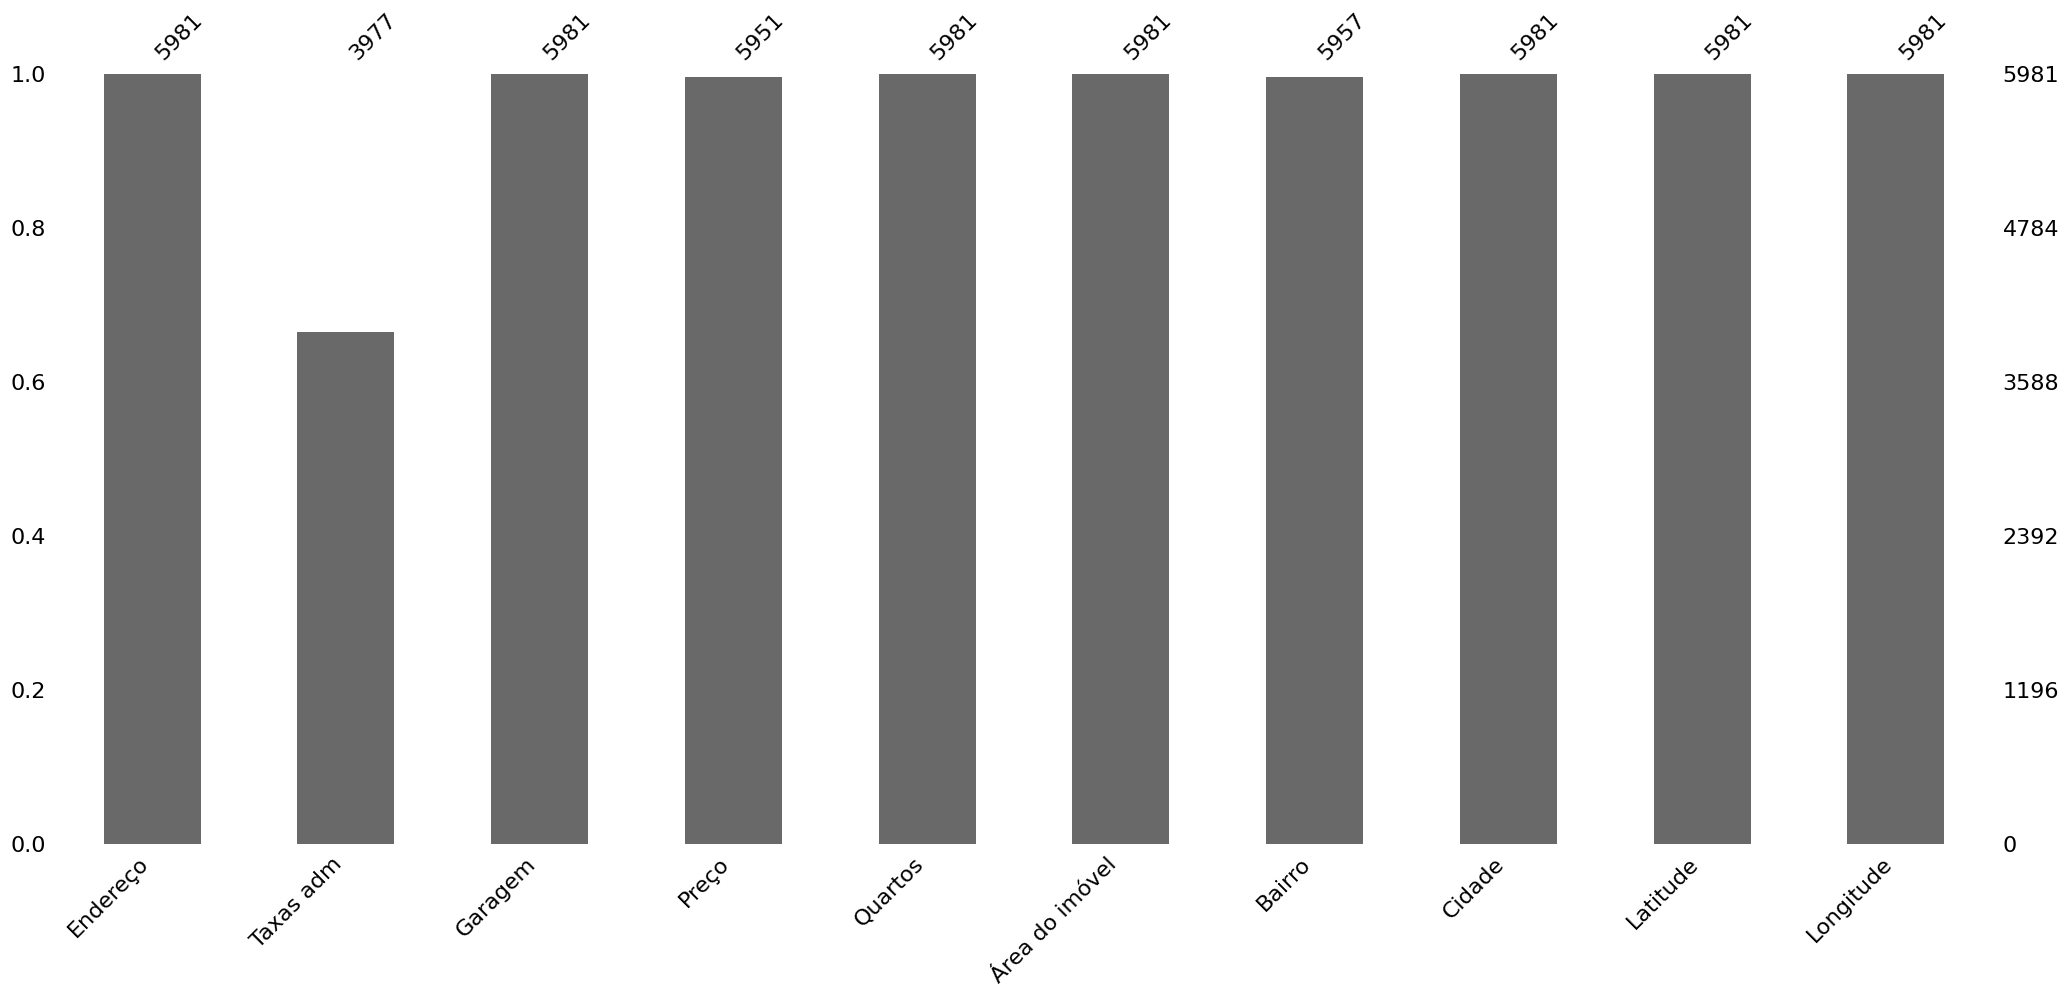

In [10]:
missingno.bar(dados)

In [11]:
pd.concat([dados.isin([0]).sum(axis=0),dados.isna().sum()],axis=1).rename(columns={0:"Nº zeros", 1:"Dados ausentes"})

Nº zeros  Dados ausentes
Endereço               0               0
Taxas adm              0            2004
Garagem                0               0
Preço                  0              30
Quartos                0               0
Área do imóvel         0               0
Bairro                 0              24
Cidade                 0               0
Latitude               0               0
Longitude              0               0

**Tipos de variáveis:**
* **Qualitativas**
    - Nominais: não possuem ordem natural
        * Exemplos: cor do carro (preta, preta...), sexo (F ou M).
    - Ordinais: tem ordenação indicando intensidades crescentes ou decrescentes
        * Exemplos: porte da empresa (pequena, média e grande), classe social (A, B, C, D e E).
* **Quantitativas**
    - Discretas: resultante de contagens
        * Exemplos: número de pessoas que entram em um supermercado, número de defeitos em uma peça.
    - Contínuas: resultante de mensurações
        * Exemplos: temperatura (ºC), peso (kg).
        
**Descrições de variáveis categóricas**
 * Frequência absoluta (N) = contagem de observações
 * Frequência relativa (%) = frequência absoluta/nº total de observações
 * Gráficos de barras, setores (pizza), etc.

In [12]:
print('Frequência absoluta:', dados['Cidade'].value_counts())
print(' ')
print('Frequência relativa (%):', dados['Cidade'].value_counts(normalize=True)*100)

Frequência absoluta:  Belo Horizonte         5925
Belo Horizonte            24
 Contagem                  6
 Nova Lima                 4
 Sabará                    4
 Ribeirão das Neves        3
 Lagoa Santa               2
 461                       2
 1542                      1
 22                        1
 São Paulo                 1
 1601                      1
 570                       1
 Divinópolis               1
 1122                      1
 Km 480                    1
 Betim                     1
 Santa Luzia               1
 31                        1
Name: Cidade, dtype: int64
 
Frequência relativa (%):  Belo Horizonte         99.063702
Belo Horizonte           0.401271
 Contagem                0.100318
 Nova Lima               0.066878
 Sabará                  0.066878
 Ribeirão das Neves      0.050159
 Lagoa Santa             0.033439
 461                     0.033439
 1542                    0.016720
 22                      0.016720
 São Paulo               0.016720


In [13]:
DescritivaCat(dados,['Garagem'])

Variável Categoria  Freq. Absoluta (N)  Freq. Relativa (%)
0   Garagem        --                 553                9.25
1   Garagem         1                1458               24.38
2   Garagem       1-2                   7                0.12
3   Garagem       1-3                   1                0.02
4   Garagem        10                  25                0.42
5   Garagem        11                   5                0.08
6   Garagem        12                   2                0.03
7   Garagem        13                   4                0.07
8   Garagem        15                   4                0.07
9   Garagem        17                   1                0.02
10  Garagem        18                   1                0.02
11  Garagem        19                   1                0.02
12  Garagem         2                2235               37.37
13  Garagem       2-3                  10                0.17
14  Garagem       2-4                   1                0.02
15  Garagem        20                   3                0.05
16  Garagem        22                   1                0.02
17  Garagem        25                   1                0.02
18  Garagem        28                   1                0.02
19  Garagem         3                 830               13.88
20  Garagem       3-4                   9                0.15
21  Garagem         4                 576                9.63
22  Garagem        40                   1                0.02
23  Garagem        46                   2                0.03
24  Garagem         5                 113                1.89
25  Garagem        50                   1                0.02
26  Garagem         6                  85                1.42
27  Garagem         7                  17                0.28
28  Garagem         8                  31                0.52
29  Garagem         9                   2                0.03

In [14]:
DescritivaCat(dados,['Quartos'])

Variável Categoria  Freq. Absoluta (N)  Freq. Relativa (%)
0   Quartos        --                 504                8.43
1   Quartos         1                 210                3.51
2   Quartos       1-2                   2                0.03
3   Quartos        10                   1                0.02
4   Quartos        12                   3                0.05
5   Quartos        13                   2                0.03
6   Quartos        15                   1                0.02
7   Quartos        16                   1                0.02
8   Quartos        18                   1                0.02
9   Quartos         2                1249               20.88
10  Quartos       2-3                  18                0.30
11  Quartos         3                2169               36.26
12  Quartos       3-4                   6                0.10
13  Quartos         4                1591               26.60
14  Quartos       4-5                   1                0.02
15  Quartos        45                   1                0.02
16  Quartos         5                 163                2.73
17  Quartos        50                   1                0.02
18  Quartos         6                  38                0.64
19  Quartos         7                   9                0.15
20  Quartos         8                   7                0.12
21  Quartos         9                   3                0.05

In [15]:
DescritivaCat(dados,['Área do imóvel'])

Variável Categoria  Freq. Absoluta (N)  Freq. Relativa (%)
0    Área do imóvel        --                   1                0.02
1    Área do imóvel         0                  10                0.17
2    Área do imóvel       100                 109                1.82
3    Área do imóvel      1000                  13                0.22
4    Área do imóvel      1007                   1                0.02
..              ...       ...                 ...                 ...
613  Área do imóvel        97                  18                0.30
614  Área do imóvel       973                   1                0.02
615  Área do imóvel        98                  29                0.48
616  Área do imóvel       985                   1                0.02
617  Área do imóvel        99                  14                0.23

[618 rows x 4 columns]

In [16]:
DescritivaCat(dados,['Bairro'])

Variável            Categoria  Freq. Absoluta (N)  Freq. Relativa (%)
0     Bairro            Aeroporto                   1                0.02
1     Bairro         Alto Barroca                  14                0.23
2     Bairro    Alto dos Caiçaras                   5                0.08
3     Bairro   Alto dos Pinheiros                   3                0.05
4     Bairro       Alípio de Melo                   9                0.15
..       ...                  ...                 ...                 ...
224   Bairro              Vitória                   4                0.07
225   Bairro          Xodó Marize                   1                0.02
226   Bairro      Álvaro Camargos                   2                0.03
227   Bairro                  040                   1                0.02
228   Bairro                    I                   8                0.13

[229 rows x 4 columns]

In [17]:
DescritivaCat(dados,['Cidade'])

Variável             Categoria  Freq. Absoluta (N)  Freq. Relativa (%)
0    Cidade                 1122                    1                0.02
1    Cidade                 1542                    1                0.02
2    Cidade                 1601                    1                0.02
3    Cidade                   22                    1                0.02
4    Cidade                   31                    1                0.02
5    Cidade                  461                    2                0.03
6    Cidade                  570                    1                0.02
7    Cidade       Belo Horizonte                 5925               99.06
8    Cidade                Betim                    1                0.02
9    Cidade             Contagem                    6                0.10
10   Cidade          Divinópolis                    1                0.02
11   Cidade               Km 480                    1                0.02
12   Cidade          Lagoa Santa                    2                0.03
13   Cidade            Nova Lima                    4                0.07
14   Cidade   Ribeirão das Neves                    3                0.05
15   Cidade               Sabará                    4                0.07
16   Cidade          Santa Luzia                    1                0.02
17   Cidade            São Paulo                    1                0.02
18   Cidade        Belo Horizonte                  24                0.40

**Descrições de variáveis numéricas: medidas de tendência central e dispersão:**
   * Moda: o(s) valor(es) mais frequente(s).
   * Média: aritmética, geométrica ou harmônica; simples ou ponderada; aparada.
   * Variância: medida de dispersão que mostra o quão distante cada valor desse conjunto está do valor médio.
   * Desvio-padrão: D.P. = $\sqrt{variância}$
   * Percentil 25% = Quartil 25%: 25% dos valores estão abaixo do valor do percentil 25 e 75% acima.
   * Mediana (Percentil 50% = Quartil 50%): o valor “do meio”; metade dos valores são menores ou iguais à mediana.
   * Percentil 75% = Quartil 75%: 75% dos valores estão abaixo do valor do percentil 75 e 25% acima.
   * Mínimo: valor mínimo do conjunto de dados.
   * Máximo: valor máximo do conjunto de dados.
   * Amplitude: distância entre valores mínimo e máximo.
   * Coeficiente de variação: “tamanho” do desvio-padrão em relação ao “tamanho” da média, utilizado para comparar dispersão (CV = variância/média, > 0 mais heterogênea).
   * Curtose: mede o achatamento da curva de distribuição de frequências.
   * Assimetria: formato da curva.
   * Gráficos de dispersão, box-plot, histograma, etc.

In [18]:
#Medidas em relação ao preço dos imóveis
print('Moda (valor que mais se repete):', dados['Preço'].mode().tolist()[0])
print('Média:', dados['Preço'].mean())
print('Variância:', dados['Preço'].var())
print('Desvio-padrão:',dados['Preço'].std())
print('Percentil 10:', dados['Preço'].quantile(q=0.10))
print('Percentil 25 = quartil 25:', dados['Preço'].quantile(q=0.25))
print('Mediana:', dados['Preço'].median())
print('Percentil 75 = quartil 75:', dados['Preço'].quantile(q=0.75))
print('Mínimo:', dados['Preço'].min())
print('Máximo:', dados['Preço'].max())
print('Amplitude:', dados['Preço'].max() - dados['Preço'].min())
print('Coeficiente de variação:', dados['Preço'].std() / abs(dados['Preço'].mean()))#maior que 0, mais heterogênea
print('Curtose:', dados['Preço'].kurtosis())#menor que 0, cauda à direita
print('Assimetria:', dados['Preço'].skew())#maior que |0.15|, assimetria forte

Moda (valor que mais se repete): 450000.0
Média: 1075036.4012770962
Variância: 4526143661884.636
Desvio-padrão: 2127473.5396438274
Percentil 10: 248000.0
Percentil 25 = quartil 25: 390000.0
Mediana: 680000.0
Percentil 75 = quartil 75: 1210000.0
Mínimo: 450.0
Máximo: 130000000.0
Amplitude: 129999550.0
Coeficiente de variação: 1.978978141685697
Curtose: 2281.851950373702
Assimetria: 39.022583364493414


In [19]:
DescritivaNum(dados,['Taxas adm','Preço']).round(2)

Variável  Freq. Absoluta       Média  Desvio Padrão  Mínimo        Q1  \
0  Taxas adm          3977.0     2056.61       36268.85     1.0     300.0   
1      Preço          5951.0  1075036.40     2127473.54   450.0  390000.0   

   Q2 (Mediana)         Q3       Máximo  
0         500.0     1000.0    1500000.0  
1      680000.0  1210000.0  130000000.0

**Pontos de atenção:**

Área do imóvel nula...

In [20]:
dados[dados['Área do imóvel'] == 0]

Empty DataFrame
Columns: [Endereço, Taxas adm, Garagem, Preço, Quartos, Área do imóvel, Bairro, Cidade, Latitude, Longitude]
Index: []

In [21]:
dados[dados['Área do imóvel'] == '0']

Endereço  Taxas adm Garagem      Preço  \
449                          Rua Curitiba, 224         NaN      --  4000000.0   
1107                              Rua da Bahia         NaN      --    90000.0   
1475                      Rua Altinópolis, 367         NaN      --   280000.0   
2665                         Rua Monte Azul, 0         NaN      --   430000.0   
2981  Rua Desembargador Amílcar de Castro, 172         NaN      --  1900000.0   
3368               Rua Martim de Carvalho, 273         NaN       1   729200.0   
3404                       Avenida do Contorno         NaN       1   420000.0   
3473                        Rua dos Guajajaras         NaN       1   700000.0   
3561          Rua Antônio Ferreira Sobrinho, 0         NaN      --   432960.0   
5059           Rua Heroína Maria Quitéria, 150         NaN      --   335000.0   

     Quartos Área do imóvel                   Bairro            Cidade  \
449       45              0                   Centro   Belo Horizonte    
1107      --              0                   Centro   Belo Horizonte    
1475      --              0   Piratininga Venda Nova   Belo Horizonte    
2665      --              0              Mangabeiras   Belo Horizonte    
2981      --              0                  Estoril   Belo Horizonte    
3368      --              0          Santo Agostinho   Belo Horizonte    
3404      --              0           Santa Efigênia   Belo Horizonte    
3473      --              0                   Centro   Belo Horizonte    
3561      --              0                 Planalto   Belo Horizonte    
5059      --              0        Alto dos Caiçaras   Belo Horizonte    

       Latitude  Longitude  
449  -19.912231 -43.939663  
1107 -19.915178 -43.934765  
1475 -19.807963 -43.990591  
2665 -19.957139 -43.928365  
2981 -19.968302 -43.957710  
3368 -19.931173 -43.947941  
3404 -19.915643 -43.945380  
3473 -19.926191 -43.936380  
3561 -19.837967 -43.942130  
5059 -19.899603 -43.977840

Taxa administrativa no valor de R$1500000,00...

In [22]:
dados[dados['Taxas adm'] == 1500000] # 1 milhão e meio

Endereço  Taxas adm Garagem      Preço  \
2505  Rua Doutor Juvenal dos Santos, 500   1500000.0       4  1580000.0   

     Quartos Área do imóvel       Bairro            Cidade   Latitude  \
2505       4            260   Luxemburgo   Belo Horizonte  -19.950826   

      Longitude  
2505 -43.958545

Ordenação dos dados pela taxa administrativa:

In [23]:
dados.sort_values(['Taxas adm'])

Endereço  Taxas adm Garagem      Preço  \
3049               Rua Alvarenga Peixoto         1.0       2   996811.0   
3001      Rua Deputado Fábio Vasconcelos         1.0      --  1244070.0   
3000                  Rua Senador Pompéo         1.0       1   470000.0   
2935               Rua Rio Grande do Sul         1.0       2  1603000.0   
2911                 Rua Ramalho Ortigão         1.0       2   315000.0   
...                                   ...        ...     ...        ...   
5968                     Rua dos Aimorés         NaN       2   912400.0   
5970  Rua Geraldo Lúcio Vasconcelos, 910         NaN      --  9500000.0   
5971                   Rua Tomé de Souza         NaN      --  1880000.0   
5973                      Rua dos Pampas         NaN       3   925633.0   
5980                 Avenida do Contorno         NaN       3  4990000.0   

     Quartos Área do imóvel            Bairro            Cidade   Latitude  \
3049       2             73   Santo Agostinho   Belo Horizonte  -19.929576   
3001       1            138           Buritis   Belo Horizonte  -19.973047   
3000       2             62             Serra   Belo Horizonte  -19.936172   
2935       3             97   Santo Agostinho   Belo Horizonte  -19.922716   
2911       3             60      Santa Branca   Belo Horizonte  -19.832754   
...      ...            ...               ...               ...        ...   
5968       2             60   Santo Agostinho   Belo Horizonte  -19.924514   
5970      --           4000           Buritis   Belo Horizonte  -19.980703   
5971       3            118           Savassi   Belo Horizonte  -19.938824   
5973       3            131             Prado   Belo Horizonte  -19.919402   
5980      --            428           Savassi   Belo Horizonte  -19.915643   

      Longitude  
3049 -43.949416  
3001 -43.976480  
3000 -43.920272  
2935 -43.946463  
2911 -43.966475  
...         ...  
5968 -43.953888  
5970 -43.975175  
5971 -43.927445  
5973 -43.964543  
5980 -43.945380  

[5981 rows x 10 columns]

Preço do imóvel de R$130000000,00...

In [24]:
dados[dados['Preço'] == 130000000] #130 mi

Endereço  Taxas adm Garagem        Preço Quartos  \
272  Rua Mato Grosso, 355         NaN      --  130000000.0      --   

    Área do imóvel   Bairro            Cidade   Latitude  Longitude  
272             31   Centro   Belo Horizonte  -19.917312 -43.946403

Ordenação dos dados pelo preço:

In [25]:
dados.sort_values(['Preço'])

Endereço  Taxas adm Garagem  Preço Quartos  \
3119                    Rua dos Goitacazes         NaN      --  450.0      --   
4196                         Rua São Paulo         NaN      --  550.0      --   
2104            Rua Orion Rigel Vigne, 195       159.0       1  550.0       2   
5865                 Rua Paulo Afonso, 146         NaN      --  650.0      --   
1500           Rua Padre Pedro Pinto, 2981       210.0      --  700.0       2   
...                                     ...        ...     ...    ...     ...   
502   Avenida Senador Levindo Coelho, 1267         NaN     1-2    NaN       2   
508                      Avenida Marte, 40         NaN       2    NaN     2-3   
539                 Estrada de Areias, 221         NaN      --    NaN      --   
569                              Rodovia BR        NaN      --    NaN      --   
575                  Rua Albert Sabin, 761         NaN       1    NaN       2   

     Área do imóvel                     Bairro                Cidade  \
3119             44                     Centro       Belo Horizonte    
4196             45                     Centro       Belo Horizonte    
2104             55                   Floramar       Belo Horizonte    
5865             21              Santo Antônio       Belo Horizonte    
1500             50                 Venda Nova       Belo Horizonte    
...             ...                        ...                   ...   
502           44-84    Vale do Jatoba Barreiro       Belo Horizonte    
508           52-73   Jardim Riacho das Pedras             Contagem    
539        250-1020     Esperanca Justinopolis   Ribeirão das Neves    
569           20000                        040               Km 480    
575              45                   Quintino          Divinópolis    

       Latitude  Longitude  
3119 -19.922233 -43.941727  
4196 -19.914782 -43.938801  
2104 -19.829822 -43.932753  
5865 -19.946855 -43.946046  
1500 -19.818350 -43.953670  
...         ...        ...  
502  -20.011618 -44.033131  
508  -19.970840 -44.061462  
539  -19.765255 -44.004707  
569  -23.072465 -46.985263  
575  -19.890887 -43.993000  

[5981 rows x 10 columns]

Uma pesquisa rápida na internet e...
<img src="Imagens/Imagem2.png" width="1300" height="1100"/>

Problemas encontrados:
- Formato das variáveis:
    * Garagem deve ser numérica (inteiro);
    * Quartos deve ser numérico (inteiro);
    * Área do imóvel deve ser numérica (inteiro ou float);
- Dados ausentes:
    * Taxas administrativas, garagens, quartos, preço e bairro.
- Erros preenchimento:
    * Endereço sem número.
    * Caracteres especiais (traços) no número de garagens, quartos e área do imóvel.
    * Nomes de cidades e bairros inconsistentes.
    * Imóveis com preços muito elevados ou muito baixos.
    * Espaços em branco no nome das cidades e bairros no ínicio/fim das categorias.
- Imóveis localizados fora da cidade de Belo Horizonte.
    
Devido as incongruências identificadas, temos que tomar algumas decisões para realizar o tratamento de dados, dentre as quais podem ser ressaltadas:
* **O que é melhor quando lidamos com dados ausentes: imputar ou remover?**
* **Erros de digitação indicam pouca confiabilidade nas informações?**
* **Como corrigir inconsistências?**

**Preço**

Como é a nossa principal variável, se temos dados ausentes, as linhas serão removidas.

In [26]:
dados0 = dados.copy()
dados0 = dados0[dados0['Preço'].isna() == False]
dados0.shape

(5951, 10)

Originalmente temos 5981 linhas, portanto 30 linhas foram removidas.

**Caraceteres irregulares**

In [27]:
dados0[dados0['Quartos'].str.contains('-') | dados0['Garagem'].str.contains('-') | dados0['Área do imóvel'].str.contains('-')]

Endereço  Taxas adm Garagem      Preço  \
1                    Rua Espírito Santo, 1171         NaN       1   480000.0   
6                    Rua Espírito Santo, 1580         NaN       2   861748.0   
13                         Rua Curitiba, 1677         NaN     2-3   826000.0   
21              Rua João Antônio Cardoso, 128       366.0      --   495000.0   
30                          Rua da Bahia, 485       500.0      --   380000.0   
...                                        ...        ...     ...        ...   
5967  Rua Desembargador Edésio Fernandes, 148         NaN      --   700000.0   
5970       Rua Geraldo Lúcio Vasconcelos, 910         NaN      --  9500000.0   
5971                        Rua Tomé de Souza         NaN      --  1880000.0   
5975             Rua José Teófilo Marques, 10       200.0      --   220000.0   
5980                      Avenida do Contorno         NaN       3  4990000.0   

     Quartos Área do imóvel       Bairro            Cidade   Latitude  \
1          2          45-65       Centro   Belo Horizonte  -18.864776   
6          2          60-71       Centro   Belo Horizonte  -18.864776   
13         2          62-65      Lourdes   Belo Horizonte  -19.912231   
21         4            127   Ouro Preto   Belo Horizonte  -19.875337   
30         3             96       Centro   Belo Horizonte  -19.915178   
...      ...            ...          ...               ...        ...   
5967      --             93      Estoril   Belo Horizonte  -19.969855   
5970      --           4000      Buritis   Belo Horizonte  -19.980703   
5971       3            118      Savassi   Belo Horizonte  -19.938824   
5975       1             45      Buritis   Belo Horizonte  -19.974455   
5980      --            428      Savassi   Belo Horizonte  -19.915643   

      Longitude  
1    -41.121777  
6    -41.121777  
13   -43.939663  
21   -43.982745  
30   -43.934765  
...         ...  
5967 -43.955896  
5970 -43.975175  
5971 -43.927445  
5975 -43.977699  
5980 -43.945380  

[789 rows x 10 columns]

Temos caracteres irregulares em várias colunas e linhas.

#### Foco no problema!!!

Imputar informações como número de garagens, quartos ou área pode trazer viés.

Portanto, se o número de quartos, garagens ou área contém traços, hífens, as linhas também serão retiradas.

In [28]:
dados1 = dados0[(~dados0['Garagem'].str.contains('-')) & (~dados0['Quartos'].str.contains('-')) & 
                (~dados0['Área do imóvel'].str.contains('-'))]
dados1.shape

(5162, 10)

Foram retiradas 789 linhas.

Conversão das variáveis Garagem, Quartos e Área do imóvel em números inteiros.

In [29]:
dados1[['Garagem','Quartos','Área do imóvel']] = dados1[['Garagem','Quartos','Área do imóvel']].astype(int)

In [30]:
dados1.head()

Endereço  Taxas adm  Garagem      Preço  Quartos  \
0      Avenida Raja Gabaglia, 1583       470.0        1   330000.0        1   
2    Rua dos Expedicionários, 1082         NaN        5  1190000.0        4   
3          Rua Marechal Hermes, 81       750.0        4  1590000.0        4   
4                  Rua Juruna, 110         NaN        6   550000.0        3   
5  Rua Maria Pereira de Araújo, 15       500.0        1   450000.0        3   

   Área do imóvel         Bairro            Cidade   Latitude  Longitude  
0              40     Luxemburgo   Belo Horizonte  -19.936415 -43.953396  
2             411   Santa Amélia   Belo Horizonte  -20.225241 -44.397780  
3             158      Gutierrez   Belo Horizonte  -19.937155 -43.958694  
4             278      Pindorama   Belo Horizonte  -19.912982 -44.019944  
5              87        Castelo   Belo Horizonte  -19.886147 -44.004236

Analisando outliers e pontos discrepantes:

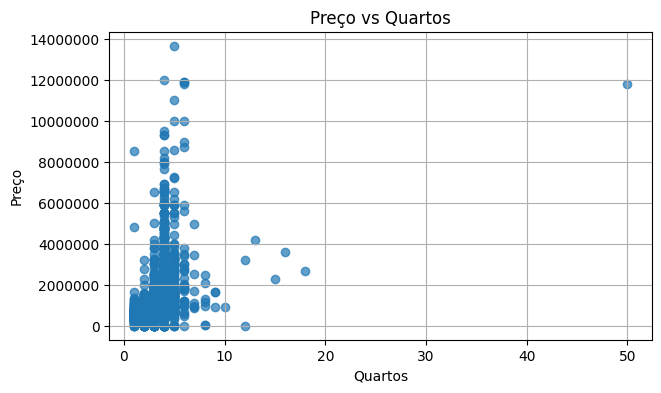

In [31]:
plt.figure(figsize=(7, 4))
plt.scatter(dados1['Quartos'], dados1['Preço'], alpha=0.7)
plt.title('Preço vs Quartos')
plt.xlabel('Quartos')
plt.ylabel('Preço')
plt.grid(True)
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

In [32]:
dados1[dados1['Quartos'] > 10]

Endereço  Taxas adm  Garagem       Preço  Quartos  \
77             Rua Nhanduti, 287         NaN       10   2690000.0       18   
119              Rua Císsus, 148         NaN        1   4200000.0       13   
300           Rua Vicente Risola         NaN        7   3600000.0       16   
635   Avenida Santos Dumont, 304         NaN       20  11790000.0       50   
3857           Rua Araguari, 766         NaN        4   3200000.0       12   
5629   Avenida Flávio dos Santos         NaN        2   2290000.0       15   
5930                Rua Araguari         1.0        2      9990.0       12   

      Área do imóvel             Bairro            Cidade   Latitude  \
77              1050   Caiçara Adeláide   Belo Horizonte  -19.903732   
119             2250            Juliana   Belo Horizonte  -19.809608   
300              795         Santa Inês   Belo Horizonte  -19.891018   
635             3089             Centro   Belo Horizonte  -19.914943   
3857             600        Barro Preto        São Paulo  -19.930408   
5629             690           Floresta   Belo Horizonte  -19.914377   
5930             700        Barro Preto   Belo Horizonte  -19.930408   

      Longitude  
77   -43.974648  
119  -43.944296  
300  -43.908490  
635  -43.941059  
3857 -43.951416  
5629 -43.925504  
5930 -43.951416

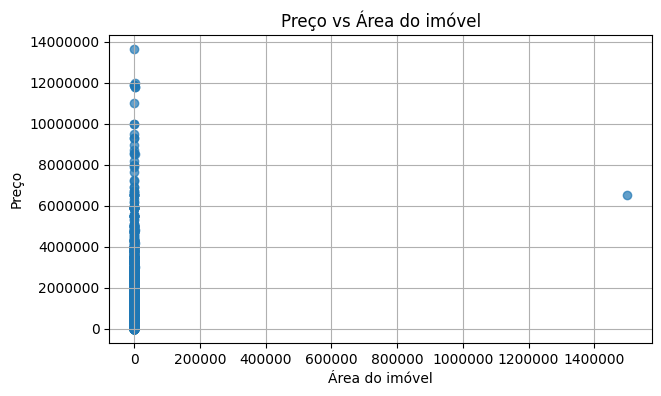

In [33]:
plt.figure(figsize=(7, 4))
plt.scatter(dados1['Área do imóvel'], dados1['Preço'], alpha=0.7)
plt.title('Preço vs Área do imóvel')
plt.xlabel('Área do imóvel')
plt.ylabel('Preço')
plt.grid(True)
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

In [34]:
dados1[dados1['Área do imóvel'] > 10000] #1.5 mi m²

Endereço  Taxas adm  Garagem      Preço  \
5428  Avenida Otacílio Negrão de Lima, 01         NaN       19  6500000.0   

      Quartos  Área do imóvel         Bairro            Cidade  Latitude  \
5428        3         1500000   Bandeirantes   Belo Horizonte  -19.86098   

      Longitude  
5428  -43.97684

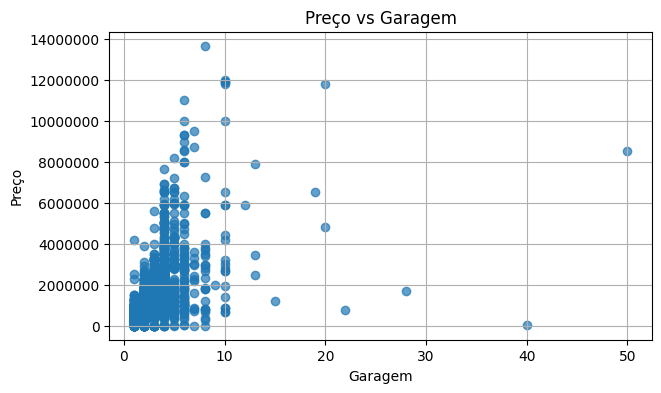

In [35]:
plt.figure(figsize=(7, 4))
plt.scatter(dados1['Garagem'], dados1['Preço'], alpha=0.7)
plt.title('Preço vs Garagem')
plt.xlabel('Garagem')
plt.ylabel('Preço')
plt.grid(True)
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

In [36]:
dados1[dados1['Garagem'] > 10]

Endereço  Taxas adm  Garagem       Preço  \
178                Alameda das Palmeiras, 95         NaN       13   3440000.0   
635               Avenida Santos Dumont, 304         NaN       20  11790000.0   
1104  Avenida Otacílio Negrão de Lima, 13000         NaN       13   2495000.0   
1958        Rua Rubens Caporali Ribeiro, 800         1.0       50   8500000.0   
2008                        Rua Dona Cecília      1500.0       28   1690000.0   
2203                             Rua Palermo         NaN       12   5900000.0   
2635          Rua Carlos Henrique Lange, 307         NaN       40     13000.0   
2816                        Rua Carlos Gomes         1.0       22    752640.0   
3510         Avenida Walter Amadeu Pace, 210         NaN       15   1200000.0   
3671                Rua Serra da Água Quente         1.0       20   4800000.0   
4711              Rua Professor Sálvio Nunes         NaN       13   7900000.0   
5428     Avenida Otacílio Negrão de Lima, 01         NaN       19   6500000.0   

      Quartos  Área do imóvel                               Bairro  \
178         7             800                             São Luíz   
635        50            3089                               Centro   
1104        5             367                     Jardim Atlântico   
1958        1            4000                              Buritis   
2008        4             287                                Serra   
2203        5             638                         Bandeirantes   
2635        4             400                             Pampulha   
2816        2              82                        Santo Antônio   
3510        3             190                                Havaí   
3671        1            3637   Distrito Industrial Vale do Jatobá   
4711        4             800                          Mangabeiras   
5428        3         1500000                         Bandeirantes   

                Cidade   Latitude  Longitude  
178    Belo Horizonte  -19.857305 -43.971547  
635    Belo Horizonte  -19.914943 -43.941059  
1104   Belo Horizonte  -19.860980 -43.976840  
1958   Belo Horizonte  -19.981344 -43.976484  
2008   Belo Horizonte  -19.937768 -43.922114  
2203   Belo Horizonte  -19.860470 -43.990266  
2635   Belo Horizonte  -19.843834 -43.995513  
2816   Belo Horizonte  -19.943133 -43.945952  
3510   Belo Horizonte  -19.956569 -43.978027  
3671   Belo Horizonte  -20.004455 -44.027673  
4711   Belo Horizonte  -19.956459 -43.916133  
5428   Belo Horizonte  -19.860980 -43.976840

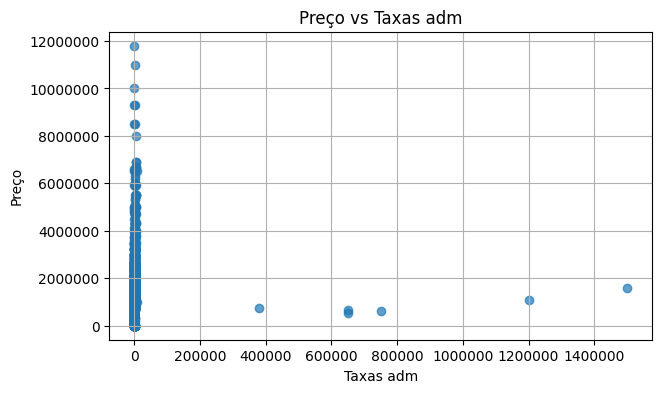

In [37]:
plt.figure(figsize=(7, 4))
plt.scatter(dados1['Taxas adm'], dados1['Preço'], alpha=0.7)
plt.title('Preço vs Taxas adm')
plt.xlabel('Taxas adm')
plt.ylabel('Preço')
plt.grid(True)
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

In [38]:
dados1[dados1['Taxas adm'] > 20000]

Endereço  Taxas adm  Garagem      Preço  \
16              Rua Barão de Cocais, 397    380000.0        2   750000.0   
266              Rua Frei Manoel da Cruz   1200000.0        2  1100000.0   
1998                  Rua Judith Binatti    750000.0        2   620000.0   
2505  Rua Doutor Juvenal dos Santos, 500   1500000.0        4  1580000.0   
3100                Rua Iracy Manata, 50    650000.0        2   540000.0   
4904           Rua Ignácio Alves Martins    650000.0        2   680000.0   

      Quartos  Área do imóvel            Bairro            Cidade   Latitude  \
16          4             160   Sagrada Família   Belo Horizonte  -19.909319   
266         3             125         Liberdade   Belo Horizonte  -19.860945   
1998        3             110         Liberdade   Belo Horizonte  -19.862131   
2505        4             260        Luxemburgo   Belo Horizonte  -19.950826   
3100        3             100           Buritis   Belo Horizonte  -19.967170   
4904        2              75           Buritis   Belo Horizonte  -19.977004   

      Longitude  
16   -43.922071  
266  -43.950352  
1998 -43.954898  
2505 -43.958545  
3100 -43.970112  
4904 -43.977664

Removendo imóveis com taxas administrativas maiores que R$\$$50000,00.

In [39]:
dados1 = dados1[~(dados1['Taxas adm'] > 50000)]

In [40]:
dados1.shape

(5156, 10)

6 imóveis foram retirados.

**Novos problemas... :(**
  * Preços incompatíveis com as descrições dos imóveis;
  * Área do imóvel de 1.5 milhão de m²;
  * Número de quartos e garagens muito grandes.

Soluções propostas:

- Verificar os preços incompatíveis com dados externos;
- Como ainda restam 5156 linhas, imóveis com áreas correspondentes a valores exorbitantes serão removidas;

Em relação aos preços:
<img src="Imagens/casa_popular.png" width="900" height="800"/>

Iremos calcular o preço de uma casa considerando uma casa popular, onde o m² custa R$\$$1500,00 a R$\$$2500,00, para verificar quais linhas devem ser retiradas.

Preço casa popular = Área do imóvel x R$1000,00

Considerando uma margem de R$\$$500,00 no preço do m².

In [41]:
dados2 = dados1[(dados1['Área do imóvel']*1000 < dados1['Preço'])]
dados2.shape

(5077, 10)

79 imóveis foram retirados.

In [42]:
dados2[dados2['Garagem'] > 15]

Endereço  Taxas adm  Garagem       Preço  \
635         Avenida Santos Dumont, 304         NaN       20  11790000.0   
1958  Rua Rubens Caporali Ribeiro, 800         1.0       50   8500000.0   
2008                  Rua Dona Cecília      1500.0       28   1690000.0   
2816                  Rua Carlos Gomes         1.0       22    752640.0   
3671          Rua Serra da Água Quente         1.0       20   4800000.0   

      Quartos  Área do imóvel                               Bairro  \
635        50            3089                               Centro   
1958        1            4000                              Buritis   
2008        4             287                                Serra   
2816        2              82                        Santo Antônio   
3671        1            3637   Distrito Industrial Vale do Jatobá   

                Cidade   Latitude  Longitude  
635    Belo Horizonte  -19.914943 -43.941059  
1958   Belo Horizonte  -19.981344 -43.976484  
2008   Belo Horizonte  -19.937768 -43.922114  
2816   Belo Horizonte  -19.943133 -43.945952  
3671   Belo Horizonte  -20.004455 -44.027673

Observações:
    
- Número de quartos muito grande pode indicar ser um hotel, pensão ou imóvel do tipo.
- Muitas garagens podem representar um estacionamento ou lotes vagos.

<img src="Imagens/endereço_hotel.png" width="900" height="800"/>

- Imóveis onde as informações de taxas administrativas são vazias, podem indicar ser ou não ser um prédio (pois não é cobrado condomínio). Deste modo, vamos assumir estas condições:

In [43]:
for index, row in dados2.iterrows():
    if (row['Garagem'] > 15) & (row['Quartos'] < 7): #Estacionamento se Garagem > 15 e Quartos < 7
        dados2.at[index, 'Tipo_Imovel'] = 'Estacionamento/Lote'
    elif (row['Garagem'] > 15) & (row['Quartos'] > 7):#Hotel se Garagem > 15 e Quartos > 7
        dados2.at[index, 'Tipo_Imovel'] = 'Hotel'
    elif pd.isna(row['Taxas adm']):#Casa se não tem taxa administrativa
        dados2.at[index, 'Tipo_Imovel'] = 'Casa'
    else:#Prédio caso contrário
        dados2.at[index, 'Tipo_Imovel'] = 'Prédio'

In [44]:
DescritivaCat(dados2,['Tipo_Imovel'])

Variável            Categoria  Freq. Absoluta (N)  Freq. Relativa (%)
0  Tipo_Imovel                 Casa                1352               26.63
1  Tipo_Imovel  Estacionamento/Lote                   4                0.08
2  Tipo_Imovel                Hotel                   1                0.02
3  Tipo_Imovel               Prédio                3720               73.27

**Verificação da localização**

Antes de dar prosseguimento com as análises, falta validar se o endereço, latitude e longitude pertencem a capital.

In [45]:
DescritivaCat(dados2,['Cidade'])

Variável             Categoria  Freq. Absoluta (N)  Freq. Relativa (%)
0    Cidade                 1122                    1                0.02
1    Cidade                 1542                    1                0.02
2    Cidade                 1601                    1                0.02
3    Cidade                   22                    1                0.02
4    Cidade                   31                    1                0.02
5    Cidade                  461                    2                0.04
6    Cidade       Belo Horizonte                 5038               99.23
7    Cidade                Betim                    1                0.02
8    Cidade             Contagem                    1                0.02
9    Cidade            Nova Lima                    3                0.06
10   Cidade   Ribeirão das Neves                    2                0.04
11   Cidade               Sabará                    4                0.08
12   Cidade            São Paulo                    1                0.02
13   Cidade        Belo Horizonte                  20                0.39

In [46]:
#pd.set_option('display.max_rows', None)
DescritivaCat(dados2,['Bairro'])

Variável                Categoria  Freq. Absoluta (N)  Freq. Relativa (%)
0     Bairro                Aeroporto                   1                0.02
1     Bairro             Alto Barroca                  14                0.28
2     Bairro        Alto dos Caiçaras                   4                0.08
3     Bairro           Alípio de Melo                   9                0.18
4     Bairro                 Anchieta                 109                2.15
..       ...                      ...                 ...                 ...
200   Bairro   Visconde do Rio Branco                   1                0.02
201   Bairro             Vista Alegre                   1                0.02
202   Bairro                  Vitória                   4                0.08
203   Bairro          Álvaro Camargos                   1                0.02
204   Bairro                        I                   7                0.14

[205 rows x 4 columns]

Remoção dos espaços em branco no início/fim das categorias:

In [47]:
dados2['Cidade'] = dados2['Cidade'].str.lstrip().str.rstrip()
dados2['Bairro'] = dados2['Bairro'].str.lstrip().str.rstrip()
dados2['Endereço'] = dados2['Endereço'].str.lstrip().str.rstrip()

In [48]:
DescritivaCat(dados2,['Cidade'])

Variável           Categoria  Freq. Absoluta (N)  Freq. Relativa (%)
0    Cidade                1122                   1                0.02
1    Cidade                1542                   1                0.02
2    Cidade                1601                   1                0.02
3    Cidade                  22                   1                0.02
4    Cidade                  31                   1                0.02
5    Cidade                 461                   2                0.04
6    Cidade      Belo Horizonte                5058               99.63
7    Cidade               Betim                   1                0.02
8    Cidade            Contagem                   1                0.02
9    Cidade           Nova Lima                   3                0.06
10   Cidade  Ribeirão das Neves                   2                0.04
11   Cidade              Sabará                   4                0.08
12   Cidade           São Paulo                   1                0.02

In [49]:
dados2[(dados2['Cidade'] == '1122') | (dados2['Cidade'] == '1542') | (dados2['Cidade'] == '1601') | 
       (dados2['Cidade'] == '22') | (dados2['Cidade'] == '31') | (dados2['Cidade'] == '461')]

Endereço  Taxas adm  Garagem      Preço  Quartos  Área do imóvel Bairro  \
742   Rua Pium      475.0        1   470000.0        1              54      I   
1447  Rua Pium     2300.0        3  1800000.0        4             164      I   
2401  Rua Pium      600.0        1   650000.0        3             100      I   
2919  Rua Pium     8030.0        5  6500000.0        5             758      I   
3984  Rua Pium     4200.0        4  5350000.0        4             460      I   
4355  Rua Pium     1100.0        2  1100000.0        4             230      I   
5687  Rua Pium     2300.0        3  1821000.0        4             164      I   

     Cidade   Latitude  Longitude Tipo_Imovel  
742    1122 -19.951487 -43.930124      Prédio  
1447    461 -19.951487 -43.930124      Prédio  
2401   1542 -19.951487 -43.930124      Prédio  
2919   1601 -19.951487 -43.930124      Prédio  
3984     22 -19.951487 -43.930124      Prédio  
4355     31 -19.951487 -43.930124      Prédio  
5687    461 -19.951487 -43.930124      Prédio

A rua descrita no endereço corresponde a um local que pertence a Belo Horizonte.

<img src="Imagens/Imagem3.png" width="900" height="700"/>

https://www.mapsdirections.info/pt/coordenadas-gps.html

Identificação do endereço:

In [50]:
import requests
uf = "MG"
cidade = "Belo Horizonte"
endereco = "Rua Pium"

link = f'https://viacep.com.br/ws/{uf}/{cidade}/{endereco}/json/'

requisicao = requests.get(link)
print(requisicao)

dic_requisicao = requisicao.json()
print(dic_requisicao)

<Response [200]>
[{'cep': '30310-080', 'logradouro': 'Rua Pium-I', 'complemento': '', 'bairro': 'Cruzeiro', 'localidade': 'Belo Horizonte', 'uf': 'MG', 'ibge': '3106200', 'gia': '', 'ddd': '31', 'siafi': '4123'}, {'cep': '30881-350', 'logradouro': 'Rua Piúma', 'complemento': '', 'bairro': 'São Salvador', 'localidade': 'Belo Horizonte', 'uf': 'MG', 'ibge': '3106200', 'gia': '', 'ddd': '31', 'siafi': '4123'}]


Preenchendo cidade e bairro desse endereço:

In [51]:
erro_cidade = ['1122','1542','1601','22','31','461']
for cidade in erro_cidade:
    #dados2.loc[(dados2['Cidade'] == cidade),'Cidade'] = dic_requisicao[0]['localidade']
    #dados2.loc[(dados2['Cidade'] == cidade),'Bairro'] = dic_requisicao[0]['bairro']
    dados2.loc[(dados2['Cidade'] == cidade),'Cidade'] = 'Belo Horizonte'
    dados2.loc[(dados2['Bairro'] == 'I'),'Bairro'] = 'Cruzeiro'

In [52]:
DescritivaCat(dados2,['Cidade'])

Variável           Categoria  Freq. Absoluta (N)  Freq. Relativa (%)
0   Cidade      Belo Horizonte                5065               99.76
1   Cidade               Betim                   1                0.02
2   Cidade            Contagem                   1                0.02
3   Cidade           Nova Lima                   3                0.06
4   Cidade  Ribeirão das Neves                   2                0.04
5   Cidade              Sabará                   4                0.08
6   Cidade           São Paulo                   1                0.02

É necessário conferir se todos os endereços estão presentes na cidade de BH. 

Para isso, vamos fazer o download das coordenadas do município de Belo Horizonte no site do IBGE: https://ibge.gov.br/

In [53]:
gdf = gpd.read_file('MG_Municipios_2022.shp')
gdf.head()

CD_MUN               NM_MUN SIGLA_UF  AREA_KM2  \
0  3100104  Abadia dos Dourados       MG   880.461   
1  3100203               Abaeté       MG  1817.067   
2  3100302           Abre Campo       MG   470.551   
3  3100401              Acaiaca       MG   101.886   
4  3100500              Açucena       MG   815.422   

                                            geometry  
0  POLYGON ((-47.45335 -18.46925, -47.45341 -18.4...  
1  POLYGON ((-45.50026 -19.22585, -45.50024 -19.2...  
2  POLYGON ((-42.42074 -20.39718, -42.42076 -20.3...  
3  POLYGON ((-43.12231 -20.43351, -43.12239 -20.4...  
4  POLYGON ((-42.43777 -19.17542, -42.43781 -19.1...

Visualizando as informações de Belo Horizonte:

In [54]:
gdf[gdf['NM_MUN'] == 'Belo Horizonte']

CD_MUN          NM_MUN SIGLA_UF  AREA_KM2  \
65  3106200  Belo Horizonte       MG   331.354   

                                             geometry  
65  POLYGON ((-43.86960 -19.92388, -43.86960 -19.9...

**Mapa de Minas Gerais**

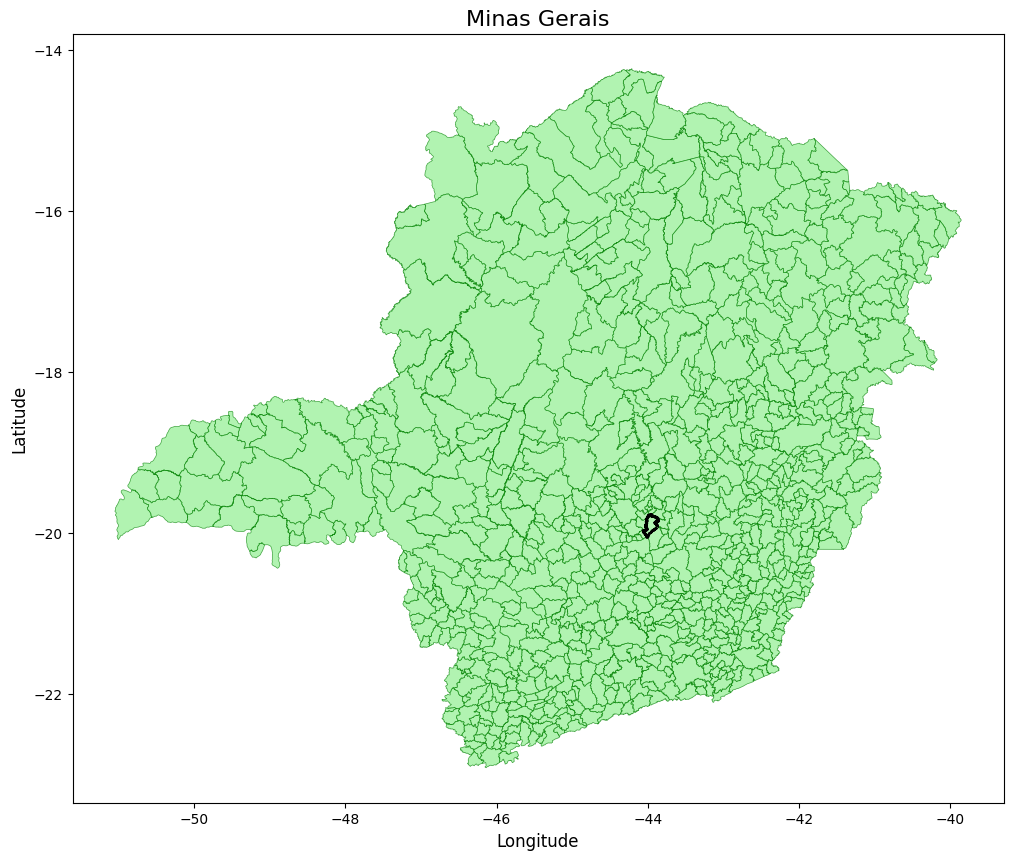

In [55]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='lightgreen', edgecolor='green', linewidth=0.5, alpha=0.7)
bh = gdf[gdf['NM_MUN'] == 'Belo Horizonte']
bh.plot(ax=ax, color='none', edgecolor='black', linewidth=2, markersize=100)
ax.set_title('Minas Gerais', fontsize=16)
plt.tight_layout()
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.show()

**Região Metropolitana**

In [56]:
# Lista das cidades da Região Metropolitana de Belo Horizonte
cidades_regiao_metropolitana = ['Belo Horizonte', 'Contagem', 'Betim', 'Ibirité', 'Sarzedo', 'Ribeirão das Neves', 'Vespasiano',
                                'Santa Luzia', 'Nova Lima']

regiao_metropolitana = gdf[gdf['NM_MUN'].isin(cidades_regiao_metropolitana)]
bh = regiao_metropolitana[regiao_metropolitana['NM_MUN'] == 'Belo Horizonte']

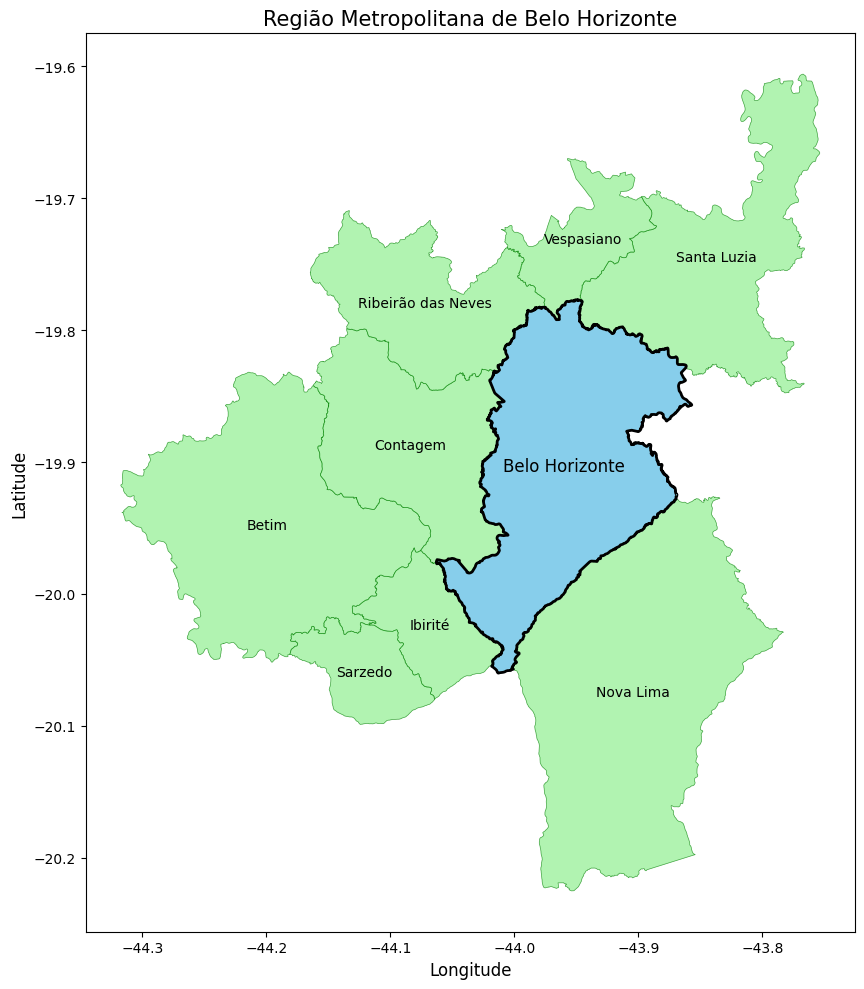

In [57]:
fig, ax = plt.subplots(figsize=(10, 10))
regiao_metropolitana.plot(ax=ax, color='lightgreen', edgecolor='green', linewidth=0.5, alpha=0.7)
bh.plot(ax=ax, color='skyblue', edgecolor='black', linewidth=2, markersize=100)
for x, y, label in zip(bh.geometry.centroid.x, bh.geometry.centroid.y, bh['NM_MUN']):
    ax.text(x, y, label, fontsize=12, ha='center', va='center', color='black')
for x, y, label in zip(regiao_metropolitana.geometry.centroid.x, regiao_metropolitana.geometry.centroid.y, 
                       regiao_metropolitana['NM_MUN']):
    if label != 'Belo Horizonte':
        ax.text(x, y, label, fontsize=10, ha='center', va='center', color='black')
ax.set_title('Região Metropolitana de Belo Horizonte', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.tight_layout()
plt.show()

O cenário ideal seria buscar o endereço em alguma API e obter as coordenadas geográficas e vice-versa, assim haveria garantias de que as localizações estão corretas.

Entretanto, a maior parte dos serviços de dados de localização são pagas ou tem limitações de requisições de acessos.

A seguir um código com a função Nominatim que buscar a latitude e longitude através da coluna endereço.

In [58]:
from geopy.geocoders import Nominatim

dados_teste_aux = dados2.head(10)

dados_teste_aux['Latitude_geopy'] = None
dados_teste_aux['Longitude_geopy'] = None

def get_lat_long_from_address(address):
    geolocator = Nominatim(user_agent="app_de_geocodificacao")
    location = geolocator.geocode(address)
    if location is not None:
        return location.latitude, location.longitude
    else:
        return None, None

for index, row in dados_teste_aux.iterrows():
    address = row['Endereço']
    latitude, longitude = get_lat_long_from_address(address)
    dados_teste_aux.at[index, 'Latitude_geopy'] = latitude
    dados_teste_aux.at[index, 'Longitude_geopy'] = longitude
pd.set_option('display.max_columns', None)
dados_teste_aux

Endereço  Taxas adm  Garagem      Preço  Quartos  \
0       Avenida Raja Gabaglia, 1583      470.0        1   330000.0        1   
2     Rua dos Expedicionários, 1082        NaN        5  1190000.0        4   
3           Rua Marechal Hermes, 81      750.0        4  1590000.0        4   
4                   Rua Juruna, 110        NaN        6   550000.0        3   
5   Rua Maria Pereira de Araújo, 15      500.0        1   450000.0        3   
7                   Rua Matipó, 455      750.0        2   549900.0        4   
8                 Rua Pitangui, 000        NaN        2   890000.0        3   
9      Avenida dos Bandeirantes, 76     2400.0        3  2550000.0        4   
10        Avenida Bias Fortes, 1603      480.0        1   310000.0        2   
11    Rua Maestro Delê Andrade, 231      350.0        1   311000.0        3   

    Área do imóvel           Bairro          Cidade   Latitude  Longitude  \
0               40       Luxemburgo  Belo Horizonte -19.936415 -43.953396   
2              411     Santa Amélia  Belo Horizonte -20.225241 -44.397780   
3              158        Gutierrez  Belo Horizonte -19.937155 -43.958694   
4              278        Pindorama  Belo Horizonte -19.912982 -44.019944   
5               87          Castelo  Belo Horizonte -19.886147 -44.004236   
7              153    Santo Antônio  Belo Horizonte -19.947351 -43.943470   
8              200  Sagrada Família  Belo Horizonte -19.902339 -43.942072   
9              570             Sion  Belo Horizonte -19.957230 -43.931973   
10              74          Lourdes  Belo Horizonte -19.932095 -43.939347   
11              72   Santa Efigênia  Belo Horizonte -19.924202 -43.913107   

   Tipo_Imovel Latitude_geopy Longitude_geopy  
0       Prédio     -19.960885      -43.957438  
2         Casa     -30.959088      -54.671827  
3       Prédio     -23.499389      -46.632258  
4         Casa     -22.975623      -47.130922  
5       Prédio     -18.826971      -42.438401  
7       Prédio     -20.396731      -43.418611  
8         Casa     -19.947277      -44.708445  
9       Prédio      -3.469399       -51.20726  
10      Prédio     -17.083352      -40.934306  
11      Prédio     -19.927418      -43.913168

Pode-se observar que as coordenadas obtidas através da função são diferentes das contidas no banco de dados.

Sendo assim, vamos optar por considerar as latitudes e longitudes originais dos dados como corretas.

Para verificar se o imóvel pertence a Belo Horizonte, analisamos se as localizações fornecidas estão dentro do polígono da capital.

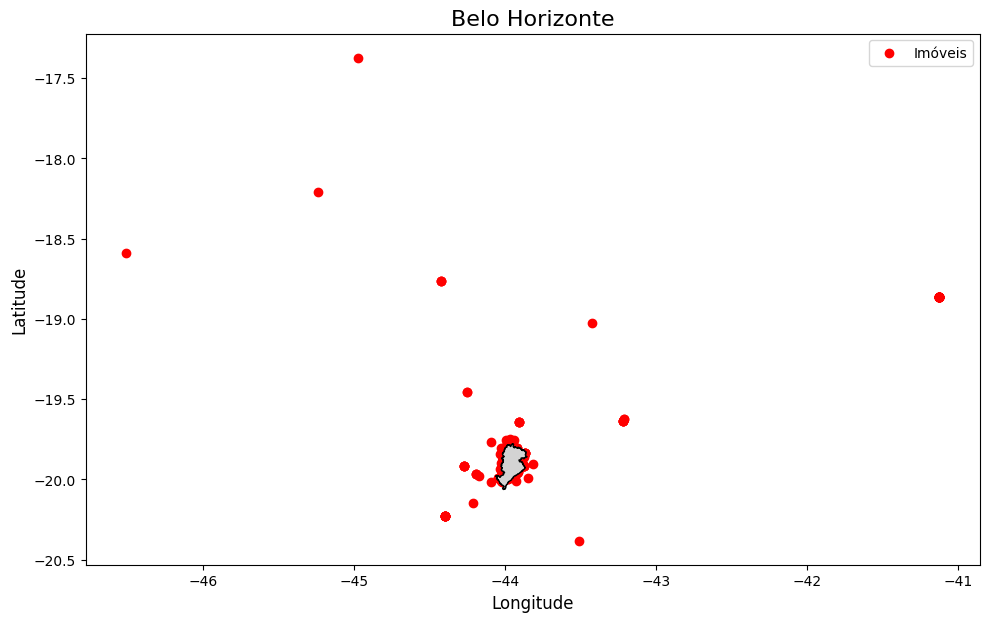

In [59]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(dados2['Longitude'], dados2['Latitude'], color='red', label='Imóveis')
bh.plot(ax=ax, color='lightgray', edgecolor='black')
ax.set_title('Belo Horizonte', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [60]:
import geopandas as gpd
from shapely.geometry import Point

dados2['PertenceBH'] = dados2.apply(lambda row: any(bh.contains(Point(row['Longitude'], row['Latitude'])) for bh in bh.geometry), axis=1)
dados2

Endereço  Taxas adm  Garagem      Preço  \
0           Avenida Raja Gabaglia, 1583      470.0        1   330000.0   
2         Rua dos Expedicionários, 1082        NaN        5  1190000.0   
3               Rua Marechal Hermes, 81      750.0        4  1590000.0   
4                       Rua Juruna, 110        NaN        6   550000.0   
5       Rua Maria Pereira de Araújo, 15      500.0        1   450000.0   
...                                 ...        ...      ...        ...   
5974                        Rua Itararé      260.0        1   330000.0   
5976                 Rua Gama Cerqueira      340.0        2   560000.0   
5977           Rua Arthur Lourenço, 262      200.0        1   440000.0   
5978  Rua General Ephigênio Ruas Santos       10.0        2   500000.0   
5979  Rua General Ephigênio Ruas Santos       10.0        2   740000.0   

      Quartos  Área do imóvel        Bairro          Cidade   Latitude  \
0           1              40    Luxemburgo  Belo Horizonte -19.936415   
2           4             411  Santa Amélia  Belo Horizonte -20.225241   
3           4             158     Gutierrez  Belo Horizonte -19.937155   
4           3             278     Pindorama  Belo Horizonte -19.912982   
5           3              87       Castelo  Belo Horizonte -19.886147   
...       ...             ...           ...             ...        ...   
5974        3             117     Concórdia  Belo Horizonte -19.900818   
5976        3              92   Nova Suíssa  Belo Horizonte -19.945428   
5977        3              90      Barreiro  Belo Horizonte -19.979915   
5978        3              80        Itapoã  Belo Horizonte -19.840904   
5979        3              80        Itapoã  Belo Horizonte -19.840904   

      Longitude Tipo_Imovel  PertenceBH  
0    -43.953396      Prédio        True  
2    -44.397780        Casa       False  
3    -43.958694      Prédio        True  
4    -44.019944        Casa        True  
5    -44.004236      Prédio        True  
...         ...         ...         ...  
5974 -43.940104      Prédio        True  
5976 -43.970988      Prédio        True  
5977 -44.026007      Prédio        True  
5978 -43.956037      Prédio        True  
5979 -43.956037      Prédio        True  

[5077 rows x 12 columns]

In [61]:
DescritivaCat(dados2, ['PertenceBH'])

Variável  Categoria  Freq. Absoluta (N)  Freq. Relativa (%)
0  PertenceBH      False                  92                1.81
1  PertenceBH       True                4985               98.19

Remoção dos imóveis com coordenadas geográficas não contidas no território belo horizontino.

In [62]:
dados2.shape

(5077, 12)

In [63]:
dados3 = dados2[dados2['PertenceBH'] == True]
dados3.shape

(4985, 12)

92 imóveis não tiveram latitudes e longitudes contidas em BH.

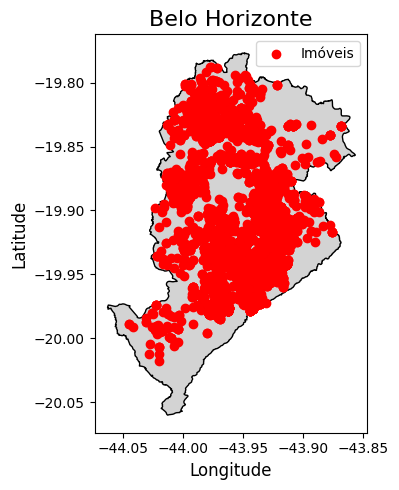

In [64]:
fig, ax = plt.subplots(figsize=(5, 5))
bh.plot(ax=ax, color='lightgray', edgecolor='black')
ax.scatter(dados3['Longitude'], dados3['Latitude'], color='red', label='Imóveis')
ax.set_title('Belo Horizonte', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

Por fim, antes de considerar que a base de dados dos imóveis está pronta para trabalho, vamos verificar novamente se tem algum valor ausente nas colunas que se referem aos bairros e cidade ou se mesmo com as coordenadas geográficas contidas em Belo Horizonte, algum imóvel está com nome diferente.

In [65]:
dados3[dados3['Cidade'].isna() == True]

Empty DataFrame
Columns: [Endereço, Taxas adm, Garagem, Preço, Quartos, Área do imóvel, Bairro, Cidade, Latitude, Longitude, Tipo_Imovel, PertenceBH]
Index: []

Não tem NA na coluna Cidade.

In [66]:
DescritivaCat(dados3,['Cidade'])

Variável           Categoria  Freq. Absoluta (N)  Freq. Relativa (%)
0   Cidade      Belo Horizonte                4977               99.84
1   Cidade               Betim                   1                0.02
2   Cidade           Nova Lima                   2                0.04
3   Cidade  Ribeirão das Neves                   1                0.02
4   Cidade              Sabará                   3                0.06
5   Cidade           São Paulo                   1                0.02

In [67]:
dados3[dados3['Cidade'] != 'Belo Horizonte']

Endereço  Taxas adm  Garagem      Preço  \
514   Avenida Denise Cristina da Rocha, 612        NaN        1   154490.0   
533                          Rua Quatro, 98        NaN        1   156690.0   
1061                           Rua Maranhão     3600.0        4  3700000.0   
1867                            Rua Alagoas      500.0        1   340000.0   
3680               Rua Celso Clark Lima, 22        NaN        3   800000.0   
3857                      Rua Araguari, 766        NaN        4  3200000.0   
4792                           Rua Maranhão     3988.0        4  6200000.0   
5628           Rua Ministro Orozimbo Nonato     1000.0        1   230000.0   

      Quartos  Área do imóvel         Bairro              Cidade   Latitude  \
514         2              38         Centro  Ribeirão das Neves -19.802935   
533         2              39   Granja Verde               Betim -19.864120   
1061        4             310   Funcionários              Sabará -19.926583   
1867        1              40        Savassi              Sabará -19.931469   
3680        3             206      Palmeiras           Nova Lima -19.973156   
3857       12             600    Barro Preto           São Paulo -19.930408   
4792        5             550   Funcionários              Sabará -19.926583   
5628        1              30  Vila da Serra           Nova Lima -19.857884   

      Longitude Tipo_Imovel  PertenceBH  
514  -43.998635        Casa        True  
533  -43.907325        Casa        True  
1061 -43.924094      Prédio        True  
1867 -43.935002      Prédio        True  
3680 -43.981369        Casa        True  
3857 -43.951416        Casa        True  
4792 -43.924094      Prédio        True  
5628 -43.939043      Prédio        True

Correção dos nomes das cidades:

In [68]:
for index, row in dados3.iterrows():
    if (row['Cidade'] == 'Sabará'): 
        dados3.at[index, 'Cidade'] = 'Belo Horizonte'
    elif (row['Cidade'] == 'São Paulo'): 
        dados3.at[index, 'Cidade'] = 'Belo Horizonte'
    elif ((row['Bairro'] == 'Palmeiras') & (row['Cidade'] == 'Nova Lima')): 
        dados3.at[index, 'Cidade'] = 'Belo Horizonte'
    elif ((row['Endereço'] == 'Avenida Denise Cristina da Rocha, 612') & (row['Cidade'] == 'Ribeirão das Neves')): 
        dados3.at[index, 'Endereço'] = 'Rua dos Camargo'
        dados3.at[index, 'Bairro'] = 'Maria Helena'
        dados3.at[index, 'Cidade'] = 'Belo Horizonte'
    elif ((row['Endereço'] == 'Rua Quatro, 98') & (row['Cidade'] == 'Betim')): 
        dados3.at[index, 'Endereço'] = 'R. Cristóvão Francelino Ferreira, 13'
        dados3.at[index, 'Bairro'] = 'Maria Goretti'
        dados3.at[index, 'Cidade'] = 'Belo Horizonte'
    elif (row['Endereço'] == 'Rua Ministro Orozimbo Nonato'): 
        dados3.at[index, 'Bairro'] = 'Dona Clara'
        dados3.at[index, 'Cidade'] = 'Belo Horizonte'    
dados3[dados3['Cidade'] != 'Belo Horizonte']        

Empty DataFrame
Columns: [Endereço, Taxas adm, Garagem, Preço, Quartos, Área do imóvel, Bairro, Cidade, Latitude, Longitude, Tipo_Imovel, PertenceBH]
Index: []

Após corrigir as informações da coluna Cidade, vamos averiguar a coluna dos bairros.

In [69]:
dados3[dados3['Bairro'].isna() == True]

Endereço  Taxas adm  Garagem      Preço  Quartos  \
43              Rua Flor      300.0        1   495000.0        3   
68              Rua Flor      500.0        2   530000.0        3   
1246            Rua Pium     1000.0        1   790000.0        4   
1459  Nova Vista, Sabará        NaN        1   250000.0        2   
2246           Rua Beija        NaN        2   480000.0        3   
2440            Rua Flor      400.0        2   825000.0        3   
2464            Rua Pium     1050.0        2   895000.0        4   
3408            Rua Flor      300.0        3   530000.0        4   
3486            Rua Pium     2500.0        3  2100000.0        4   
3565            Rua Flor      351.0        1   410000.0        3   
3630            Rua Pium      900.0        2   750000.0        4   
4064            Rua Pium      475.0        1   490000.0        1   
4716            Rua Pium     2300.0        3  1800000.0        4   
4945            Rua Pium     1500.0        2   900000.0        4   
5257            Rua Pium     1900.0        2   960000.0        4   
5592            Rua Pium      350.0        2   535000.0        3   
5771            Rua Pium      590.0        2   650000.0        3   

      Área do imóvel Bairro          Cidade   Latitude  Longitude Tipo_Imovel  \
43                68    NaN  Belo Horizonte -19.833960 -43.868807      Prédio   
68                81    NaN  Belo Horizonte -19.833960 -43.868807      Prédio   
1246             172    NaN  Belo Horizonte -19.951487 -43.930124      Prédio   
1459              66    NaN  Belo Horizonte -19.888777 -43.897505        Casa   
2246              85    NaN  Belo Horizonte -19.828803 -43.949961        Casa   
2440             178    NaN  Belo Horizonte -19.833960 -43.868807      Prédio   
2464             175    NaN  Belo Horizonte -19.951487 -43.930124      Prédio   
3408             126    NaN  Belo Horizonte -19.833960 -43.868807      Prédio   
3486             193    NaN  Belo Horizonte -19.951487 -43.930124      Prédio   
3565              80    NaN  Belo Horizonte -19.833960 -43.868807      Prédio   
3630             180    NaN  Belo Horizonte -19.951487 -43.930124      Prédio   
4064              54    NaN  Belo Horizonte -19.951487 -43.930124      Prédio   
4716             164    NaN  Belo Horizonte -19.951487 -43.930124      Prédio   
4945             160    NaN  Belo Horizonte -19.951487 -43.930124      Prédio   
5257             170    NaN  Belo Horizonte -19.951487 -43.930124      Prédio   
5592             105    NaN  Belo Horizonte -19.951487 -43.930124      Prédio   
5771             115    NaN  Belo Horizonte -19.951487 -43.930124      Prédio   

      PertenceBH  
43          True  
68          True  
1246        True  
1459        True  
2246        True  
2440        True  
2464        True  
3408        True  
3486        True  
3565        True  
3630        True  
4064        True  
4716        True  
4945        True  
5257        True  
5592        True  
5771        True

Basicamente, são 4 endereços que ainda não contém a informação do bairro:
* Rua Flor
* Rua Pium
* Rua Beija
* Nova Vista, Sabará

Após procurar cada endereço no Google Maps, manualmente, vamos substituir pelos resultados encontrados:

In [70]:
for index, row in dados3.iterrows():
    if (row['Endereço'] == 'Rua Flor') & (pd.isna(row['Bairro'])): 
        dados3.at[index, 'Bairro'] = 'Beija Flor'
    elif (row['Endereço'] == 'Rua Pium') & (pd.isna(row['Bairro'])): 
        dados3.at[index, 'Bairro'] = 'Cruzeiro'
    elif (row['Endereço'] == 'Nova Vista, Sabará') & (pd.isna(row['Bairro'])): 
        dados3.at[index, 'Bairro'] = 'Nova Vista'
    elif (row['Endereço'] == 'Rua Beija') & (pd.isna(row['Bairro'])): 
        dados3.at[index, 'Bairro'] = 'Planalto'
    elif (row['Endereço'] == 'Rua dos Aimorés, 2581'): 
        dados3.at[index, 'Bairro'] = 'Santo Agostinho'

In [71]:
dados3[dados3['Bairro'].isna() == True]

Empty DataFrame
Columns: [Endereço, Taxas adm, Garagem, Preço, Quartos, Área do imóvel, Bairro, Cidade, Latitude, Longitude, Tipo_Imovel, PertenceBH]
Index: []

Não há mais dados ausentes na coluna do bairro.

**Adição de informações:**

Todo o processamento de dados feito permitiu ter um pouco mais de confiaça nos dados até o momento, mas nota-se que o banco de dados com 4985 imóveis e 12 colunas poderia ser mais completo, ou seja, conter mais informações sobre os imóveis, por exemplo:

* Número de banheiros:
* Se tem elevador;
* Andar do apartamento;
* Quantidades de apartamentos por andar;
* Ano de fundação...

Além disso, ainda poderia ter informações sobre a região em que o o imóvel se localiza:

* Tem supermercados no bairro? Se sim, quantos?
* Número de escolas no bairro;
* IDH da região;
* Densidade populacional;
* Transporte público; entre outras.

Isto posto, vamos acrescentar algumas informações territoriais coletadas do site da Prefeitura de Belo Horizonte.    

Primeiro inserimos as informações de qual regional aquele bairro pertence:

In [72]:
Bairros = pd.read_excel("Bairros BH.xlsx", sheet_name='Planilha1')
Bairros.head()

BAIRRO    REGIONAL
0       AARAO REIS        NORTE
1           ABADIA        LESTE
2       ACABA MUNDO  CENTRO SUL
3          ACAIACA     NORDESTE
4  ADALBERTO FERRAZ  CENTRO SUL

Junção dos dados dos imóveis com os dados das regionais:

In [73]:
dados3_aux = dados3.copy()
dados3_aux["Bairro"] = dados3_aux["Bairro"].str.upper().apply(unidecode).str.replace("-", " ").str.strip()
Bairros["BAIRRO"] = Bairros["BAIRRO"].str.upper().apply(unidecode).str.replace("-", " ").str.strip()
Bairros = Bairros.drop_duplicates()

dados3_Bairros_aux = pd.merge(dados3_aux, Bairros, left_on='Bairro', right_on='BAIRRO', how='left')
dados3_Bairros_aux = dados3_Bairros_aux.drop(columns=["BAIRRO"])

In [74]:
dados3_Bairros_aux[dados3_Bairros_aux['REGIONAL'].isna() == True]

Endereço  Taxas adm  Garagem      Preço  \
668                            Rua Áurea        NaN        1   200000.0   
778                       Rua Albânia, 0        NaN        2   299000.0   
1102                 Rua Póvoa de Varzim      275.0        1   190000.0   
1176        Rua Doutor Cristiano Rezende      180.0        1   120000.0   
1231                         Rua Lucélia        1.0        1   250000.0   
1342                    Rua Pedra do Rio        NaN        2   320000.0   
1494                           Rua Norma        NaN        1   205000.0   
1674                          Rua Pinhal       40.0        1   220000.0   
1789                       Rua Erva Mate      210.0        1   155000.0   
2057                    Rua Pedra do Rio        NaN        1   320000.0   
2395                        Rua Sorocaba      120.0        1   240000.0   
2479                   Rua Eugênio Sales        NaN        1   500000.0   
2537                           Rua Norma       10.0        1   190000.0   
2548                       Rua Erva Mate      185.0        1   140000.0   
2586                           Rua Cairo      120.0        2   320000.0   
2943  Rua Décio Magalhães Mascarenhas, 0        NaN        8   680000.0   
3030            Rua Serra da Água Quente        1.0       20  4800000.0   
3033                 Rua Mogi das Cruzes      125.0        1   150000.0   
3105              Rua Augusto Muniz, 255      280.0        1   287000.0   
3168                   Rua Pedra da Mata      100.0        1   180000.0   
3190      Rua José do Carmo Oliveira, 10      140.0        1   160000.0   
3753       Rua Severiano Martins Pereira      200.0        1   150000.0   
3767                     Rua Pedra Lunar       10.0        1   350000.0   
3769             Rua Gustavo da Silveira      250.0        1   238000.0   
3825                           Rua Zélia      170.0        1   150000.0   
3944                       Rua São Pedro        NaN        8   750000.0   
3996                         Rua Lucélia        1.0        1   190000.0   
4208                     Rua Altinópolis       10.0        1   199000.0   
4297                      Rua Washington       10.0        1   230000.0   
4400                     Rua Altinópolis        NaN        1   309000.0   
4442                     Rua Altinópolis       10.0        1   189000.0   
4569                          Rua Pinhal        NaN        1   230000.0   
4735                     Rua Pedra Coral        1.0        1   258000.0   
4780                 Rua Alabandina, 629      300.0        2   330000.0   
4795                       Rua Erva Mate      155.0        1   150000.0   

      Quartos  Área do imóvel                              Bairro  \
668         2              55              PIRATININGA VENDA NOVA   
778         3              50            JARDIM EUROPA VENDA NOVA   
1102        2              48                      JARDIM PAQUETA   
1176        2              65                 BONSUCESSO BARREIRO   
1231        2              95              PIRATININGA VENDA NOVA   
1342        3              97              PIRATININGA VENDA NOVA   
1494        2              50              PIRATININGA VENDA NOVA   
1674        2              72              PIRATININGA VENDA NOVA   
1789        2              48              PIRATININGA VENDA NOVA   
2057        3              73              PIRATININGA VENDA NOVA   
2395        2              73              PIRATININGA VENDA NOVA   
2479        3              92                   PARQUE COPACABANA   
2537        2              49              PIRATININGA VENDA NOVA   
2548        2              47              PIRATININGA VENDA NOVA   
2586        2              85                   PARQUE COPACABANA   
2943        3             507                 JARDIM DOS PIRINEUS   
3030        1            3637  DISTRITO INDUSTRIAL VALE DO JATOBA   
3033        2              53              PIRATININGA VENDA NOVA   
3105        3       

Correção dos bairros nos dados3 em que não foi possível encontrar correspondências com relação às regionais:

In [75]:
#Renomeando 'Piratininga Venda Nova' para 'Venda Nova'
dados3['Bairro'] = dados3['Bairro'].replace('Piratininga Venda Nova', 'Piratininga')

#Renomeando 'Jardim Europa venda Nova' para 'Europa'
dados3['Bairro'] = dados3['Bairro'].replace('Jardim Europa venda Nova', 'Europa')

#Renomeando 'Jardim Paqueta' para 'Paqueta'
dados3['Bairro'] = dados3['Bairro'].replace('Jardim Paqueta', 'Paqueta')

#Renomeando 'Bonsucesso Barreiro' para 'Bonsucesso'
dados3['Bairro'] = dados3['Bairro'].replace('Bonsucesso Barreiro', 'Bonsucesso')

#Renomeando 'Parque Copacabana' para ''Copacabana'
dados3['Bairro'] = dados3['Bairro'].replace('Parque Copacabana', 'Copacabana')

#Renomeando 'Jardim dos Pirineus' para 'Pirineus'
dados3['Bairro'] = dados3['Bairro'].replace('Jardim dos Pirineus', 'Pirineus')

#Renomeando 'Distrito Industrial Vale do Jatobá' para 'Distrito Industrial do Jatobá'
dados3['Bairro'] = dados3['Bairro'].replace('Distrito Industrial Vale do Jatobá', 'Distrito Industrial do Jatobá')

#Renomeando 'Cardoso Barreiro' para 'Cardoso'
dados3['Bairro'] = dados3['Bairro'].replace('Cardoso Barreiro', 'Cardoso')

#Renomeando 'Teixeira Dias Barreiro' para 'Teixeira Dias'
dados3['Bairro'] = dados3['Bairro'].replace('Teixeira Dias Barreiro', 'Teixeira Dias')

#Renomeando 'Horto Florestal' para 'Horto'
dados3['Bairro'] = dados3['Bairro'].replace('Horto Florestal', 'Horto')

#Renomeando 'Parque Pedro II' para 'Alto Caiçaras'
dados3['Bairro'] = dados3['Bairro'].replace('Parque Pedro II', 'Alto dos Caiçaras')

#Renomeando 'Parque Sao Pedro Venda Nova' para 'Venda Nova'
dados3['Bairro'] = dados3['Bairro'].replace('Parque Sao Pedro Venda Nova', 'Venda Nova')

#Renomeando 'Rio Branco' para 'Visconde do Rio Branco'
dados3['Bairro'] = dados3['Bairro'].replace('Rio Branco', 'Visconde do Rio Branco')

In [76]:
dados3["Bairro"] = dados3["Bairro"].str.upper().apply(unidecode).str.replace("-", " ").str.strip()

dados3_Bairros = pd.merge(dados3, Bairros, left_on='Bairro', right_on='BAIRRO', how='left')
dados3_Bairros = dados3_Bairros.drop(columns=["BAIRRO"])

In [77]:
dados3_Bairros[dados3_Bairros['REGIONAL'].isna() == True]

Empty DataFrame
Columns: [Endereço, Taxas adm, Garagem, Preço, Quartos, Área do imóvel, Bairro, Cidade, Latitude, Longitude, Tipo_Imovel, PertenceBH, REGIONAL]
Index: []

Correção de regionais manualmente:

In [78]:
for index, row in dados3_Bairros.iterrows():
    if (row['Bairro'] == 'SANTA MARIA'): 
        dados3_Bairros.at[index, 'REGIONAL'] = 'OESTE'

Uma vez que inserimos as regionais, é mais fácil adicionar mais informações, pois ao trabalhar com a unidade bairro, há maior chance de ter dados incompletos.

**Obs:** Coordenadas geográficas são apresentadas em graus decimais. Números negativos indicam longitudes oeste e latitudes sul. Coordenadas UTM são apresentadas em metros. O modelo de elipsóide usado para os cálculos é o WGS84.

**Os dados coletados do site da prefeitura estão no sistema WGS84.**

**BAIRRO OFICIAL**

In [79]:
BAIRRO_OFICIAL = gpd.read_file('./Dados BH/BAIRRO_OFICIAL.shp')
BAIRRO_POPULAR = gpd.read_file('./Dados BH/BAIRRO_POPULAR.shp')

In [80]:
BAIRRO_OFICIAL = BAIRRO_OFICIAL[['NOME','AREA_KM2','PERIMETR_M','geometry']]
BAIRRO_POPULAR = BAIRRO_POPULAR[['NOME','AREA_KM2','PERIMETR_M','geometry']]

#Removendo dos nomes dos bairros àqueles que começam com 'do', 'da', 'dos' e 'das':
BAIRRO_OFICIAL['NOME'] = BAIRRO_OFICIAL['NOME'].str.replace(r'(^do\s+|^da\s+|^dos\s+|^das\s+)', '', case=False)
BAIRRO_POPULAR['NOME'] = BAIRRO_POPULAR['NOME'].str.replace(r'(^do\s+|^da\s+|^dos\s+|^das\s+)', '', case=False)

In [81]:
#BAIRRO_OFICIAL.query('NOME == "Antena"')

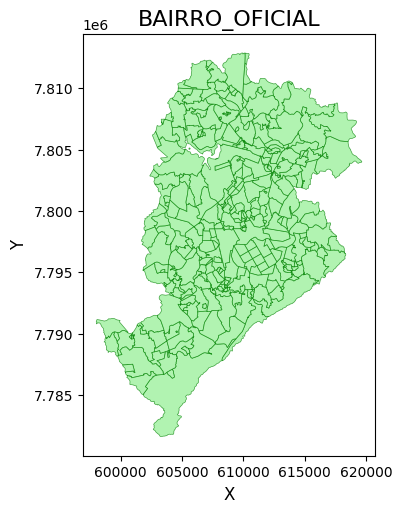

In [82]:
fig, ax = plt.subplots(figsize=(5, 5))
BAIRRO_OFICIAL.plot(ax=ax, color='lightgreen', edgecolor='green', linewidth=0.5, alpha=0.7)
ax.set_title('BAIRRO_OFICIAL', fontsize=16)
plt.tight_layout()
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
plt.show()

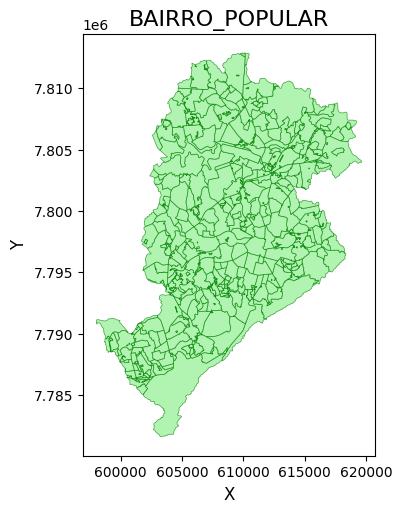

In [83]:
fig, ax = plt.subplots(figsize=(5, 5))
BAIRRO_POPULAR.plot(ax=ax, color='lightgreen', edgecolor='green', linewidth=0.5, alpha=0.7)
ax.set_title('BAIRRO_POPULAR', fontsize=16)
plt.tight_layout()
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
plt.show()

Função para corrigir a grafia de alguns bairros:

In [84]:
def CorrecaoBairros(dados,nome_bairro):
    for index, row in dados.iterrows():
        if (row[nome_bairro] == 'ALTO CAICARAS'): 
            dados.at[index, nome_bairro] = 'ALTO DOS CAICARAS'
        elif ((row[nome_bairro] == 'ALTO VERA CRUZ') | (row[nome_bairro] == 'VERA CRUZ I') | 
            (row[nome_bairro] == 'VERA CRUZ II')):
            dados.at[index, nome_bairro] = 'VERA CRUZ'
        elif (row[nome_bairro] == 'CDI JATOBA') | (row[nome_bairro] == 'JATOBA'): 
            dados.at[index, nome_bairro] = 'DISTRITO INDUSTRIAL DO JATOBA'
        elif ((row[nome_bairro] == 'CALIFORNIA') | (row[nome_bairro] == 'CONJUNTO CALIFORNIA I') | 
              (row[nome_bairro] == 'CONJUNTO CALIFORNIA II')): 
            dados.at[index, nome_bairro] = 'CONJUNTO CALIFORNIA'
        elif (row[nome_bairro] == 'CONJUNTO MINASCAIXA'): 
            dados.at[index, nome_bairro] = 'MINASCAIXA'
        elif (row[nome_bairro] == 'CONJUNTO SANTA MARIA'): 
            dados.at[index, nome_bairro] = 'SANTA MARIA'    
        elif (row[nome_bairro] == 'CONJUNTO TAQUARIL'): 
            dados.at[index, nome_bairro] = 'TAQUARIL'
        elif (row[nome_bairro] == 'ESTRELA'): 
            dados.at[index, nome_bairro] = 'ESTRELA DALVA'     
        elif (row[nome_bairro] == 'HORTO FLORESTAL'): 
            dados.at[index, nome_bairro] = 'HORTO'  
        elif (row[nome_bairro] == 'LAGOA DA PAMPULHA'): 
            dados.at[index, nome_bairro] = 'PAMPULHA'              
        elif (row[nome_bairro] == 'LAGOINHA LEBLON') | (row[nome_bairro] == 'PARQUE LEBLON'): 
            dados.at[index, nome_bairro] = 'JARDIM LEBLON'
        elif (row[nome_bairro] == 'RIO BRANCO'): 
            dados.at[index, nome_bairro] = 'VISCONDE DO RIO BRANCO'
        elif (row[nome_bairro] == 'TUPI A') | (row[nome_bairro] ==  'TUPI B'): 
            dados.at[index, nome_bairro] = 'TUPI'
        elif (row[nome_bairro] == 'VILA PUC'): 
            dados.at[index, nome_bairro] = 'CORACAO EUCARISTICO'        
        elif (row[nome_bairro] == 'PIRATININGA VENDA NOVA'): 
            dados.at[index, nome_bairro] = 'VENDA NOVA'   
        elif (row[nome_bairro] == 'CAMPUS UFMG'): 
            dados.at[index, nome_bairro] = 'PAMPULHA'
        elif (row[nome_bairro] == 'BOA UNIAO I') | (row[nome_bairro] ==  'BOA UNIAO II'): 
            dados.at[index, nome_bairro] = 'BOA UNIAO'            
        elif ((row[nome_bairro] == 'BAIRRO DAS INDUSTRIAS I') | (row[nome_bairro] == 'BAIRRO DAS INDUSTRIAS II') |
         (row[nome_bairro] == 'BAIRRO NOVO DAS INDUSTRIAS')): 
            dados.at[index, nome_bairro] = 'BAIRRO DAS INDUSTRIAS'              
        elif ((row[nome_bairro] == 'BARAO HOMEM DE MELO I') | (row[nome_bairro] == 'BARAO HOMEM DE MELO III') |
         (row[nome_bairro] == 'BARAO HOMEM DE MELO IV')): 
            dados.at[index, nome_bairro] = 'BARAO HOMEM DE MELO'             
        elif (row[nome_bairro] == 'SUZANA I') | (row[nome_bairro] == 'SUZANA II'): 
            dados.at[index, nome_bairro] = 'SUZANA'  
        elif ((row[nome_bairro] == 'SAO JORGE I') | (row[nome_bairro] == 'SAO JORGE II') |
         (row[nome_bairro] == 'SAO JORGE III')): 
            dados.at[index, nome_bairro] = 'SAO JORGE' 
        elif ((row[nome_bairro] == 'NOVA GAMELEIRA I') | (row[nome_bairro] == 'NOVA GAMELEIRA II') |
         (row[nome_bairro] == 'NOVA GAMELEIRA III')): 
            dados.at[index, nome_bairro] = 'NOVA GAMELEIRA'             
        elif ((row[nome_bairro] == 'NOVA CACHOEIRINHA I') | (row[nome_bairro] == 'NOVA CACHOEIRINHA II') |
         (row[nome_bairro] == 'NOVA CACHOEIRINHA IV')): 
            dados.at[index, nome_bairro] = 'NOVA CACHOEIRINHA'            
        elif ((row[nome_bairro] == 'MARIETA I') | (row[nome_bairro] == 'MARIETA II')): 
            dados.at[index, nome_bairro] = 'MARIETA'  
        elif ((row[nome_bairro] == 'MADRE GERTRUDES I') | (row[nome_bairro] == 'MADRE GERTRUDES II') |
         (row[nome_bairro] == 'MADRE GERTRUDES III') | (row[nome_bairro] == 'MADRE GERTRUDES V')): 
            dados.at[index, nome_bairro] = 'MADRE GERTRUDES'
        elif ((row[nome_bairro] == 'INDEPENDENCIA I') | (row[nome_bairro] == 'INDEPENDENCIA II') |
         (row[nome_bairro] == 'INDEPENDENCIA IV')): 
            dados.at[index, nome_bairro] = 'INDEPENDENCIA'
        elif (row[nome_bairro] == 'NOVO LETICIA'): 
            dados.at[index, nome_bairro] = 'LETICIA'            
        elif (row[nome_bairro] == 'SINIMBU'): 
            dados.at[index, nome_bairro] = 'BARREIRO'
    return dados

In [85]:
dados3_Bairros = CorrecaoBairros(dados3_Bairros,'Bairro')

In [86]:
dados3_Bairros.shape

(4985, 13)

**Academia a céu aberto**

In [87]:
ACADEMIA_CEU_ABERTO = gpd.read_file('./Dados BH/ACADEMIA_CEU_ABERTO.shp')
ACADEMIA_CEU_ABERTO['NOME_BAIRR'].fillna('', inplace=True)
ACADEMIA_CEU_ABERTO['NOME_BAIRR'] = ACADEMIA_CEU_ABERTO['NOME_BAIRR'].str.upper().apply(unidecode).str.replace("-", 
                                                                                                               " ").str.strip()
ACADEMIA_CEU_ABERTO = CorrecaoBairros(ACADEMIA_CEU_ABERTO,'NOME_BAIRR')
ACADEMIA_CEU_ABERTO_B = gpd.sjoin(ACADEMIA_CEU_ABERTO, BAIRRO_POPULAR, how='left', 
                                  op='intersects').groupby(["NOME_BAIRR"]).size().reset_index(name="ACADEMIA_CEU_ABERTO")
dados3_add0 = pd.merge(dados3_Bairros, ACADEMIA_CEU_ABERTO_B, left_on=['Bairro'], right_on=['NOME_BAIRR'], how='left')

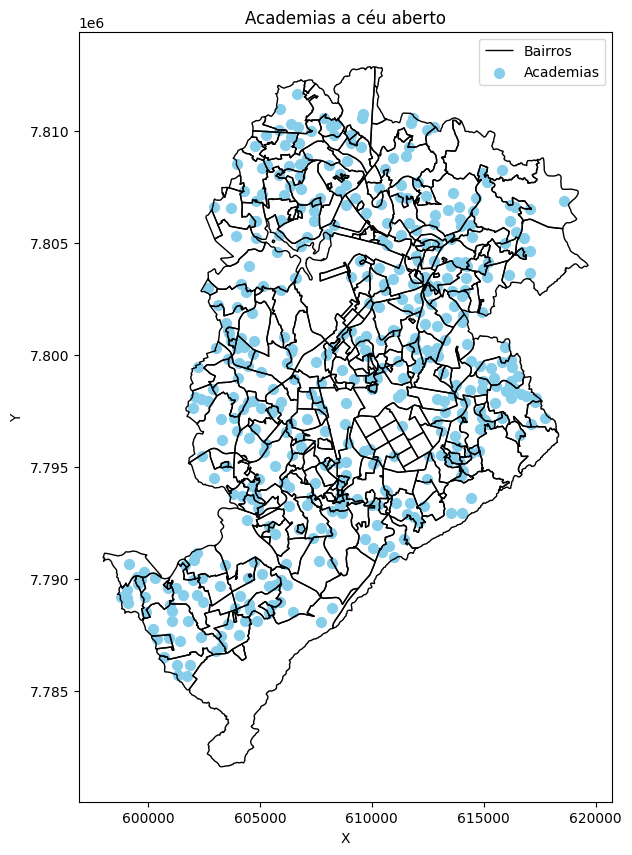

In [88]:
fig, ax = plt.subplots(figsize=(10, 10))
BAIRRO_OFICIAL.boundary.plot(ax=ax, color="black", linewidth=1)
ACADEMIA_CEU_ABERTO.plot(ax=ax, color="skyblue", markersize=50)
#joined_data.plot(ax=ax, color="green", markersize=50, marker="x")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Academias a céu aberto")
plt.legend(["Bairros", "Academias"])
plt.show()

**Área abrangência saúde**

In [89]:
AREA_ABRANGENCIA_SAUDE = gpd.read_file('./Dados BH/AREA_ABRANGENCIA_SAUDE.shp')
AREA_ABRANGENCIA_SAUDE['NOME_BAIRR'] = AREA_ABRANGENCIA_SAUDE['NOME_BAIRR'].str.upper().apply(unidecode).str.replace("-", 
                                                                                                                " ").str.strip()
AREA_ABRANGENCIA_SAUDE = CorrecaoBairros(AREA_ABRANGENCIA_SAUDE,'NOME_BAIRR')
AREA_ABRANGENCIA_SAUDE = AREA_ABRANGENCIA_SAUDE.query('NOME_BAIRR != "SANTA MARIA" or DISTRITO_S == "OESTE"')
AREA_ABRANGENCIA_SAUDE_B = gpd.sjoin(AREA_ABRANGENCIA_SAUDE, BAIRRO_POPULAR, how='left', 
                                     op='intersects').groupby(["NOME_BAIRR","DISTRITO_S"]).size().reset_index(
    name="AREA_ABRANGENCIA_SAUDE")
#dados3_add1 = pd.merge(dados3_add0, AREA_ABRANGENCIA_SAUDE_B.groupby('DISTRITO_S')['AREA_ABRANGENCIA_SAUDE'].sum().reset_index(),
#                       left_on=['REGIONAL'], right_on=['DISTRITO_S'], 
#                       how='left').drop(columns=['NOME_BAIRR','DISTRITO_S'],axis=1)

dados3_add1 = pd.merge(dados3_add0, AREA_ABRANGENCIA_SAUDE_B, left_on=['Bairro'], right_on=['NOME_BAIRR'], 
                       how='left').drop(columns=['NOME_BAIRR_y','DISTRITO_S'],axis=1)

**Área pública Wi-fi**

In [90]:
AREA_PUBLICA_WIFI = gpd.read_file('./Dados BH/AREA_PUBLICA_WIFI.shp')
AREA_PUBLICA_WIFI_B = gpd.sjoin(AREA_PUBLICA_WIFI, BAIRRO_POPULAR, how='left', 
                                op='intersects').groupby(["NOME_right"]).size().reset_index(name="AREA_PUBLICA_WIFI")
AREA_PUBLICA_WIFI_B['NOME_right'] = AREA_PUBLICA_WIFI_B['NOME_right'].str.upper().apply(unidecode).str.replace("-",
                                                                                                               " ").str.strip()
AREA_PUBLICA_WIFI_B = CorrecaoBairros(AREA_PUBLICA_WIFI_B,'NOME_right')
AREA_PUBLICA_WIFI_B = AREA_PUBLICA_WIFI_B.groupby('NOME_right')['AREA_PUBLICA_WIFI'].sum().reset_index()
dados3_add2 = pd.merge(dados3_add1, AREA_PUBLICA_WIFI_B, left_on=['Bairro'], right_on=['NOME_right'], 
                       how='left').drop(columns=['NOME_right'],axis=1)

**Área risco escorregamento**

In [91]:
AREA_RISCO_ESCORREGAMENTO = gpd.read_file('./Dados BH/AREA_RISCO_ESCORREGAMENTO.shp')
AREA_RISCO_ESCORREGAMENTO_B = gpd.sjoin(AREA_RISCO_ESCORREGAMENTO, BAIRRO_POPULAR, how='left', 
                                        op='intersects').groupby(["NOME"]).size().reset_index(name="AREA_RISCO_ESCORREGAMENTO")
AREA_RISCO_ESCORREGAMENTO_B['NOME'] = AREA_RISCO_ESCORREGAMENTO_B['NOME'].str.upper().apply(unidecode).str.replace(
    "-"," ").str.strip()
AREA_RISCO_ESCORREGAMENTO_B = CorrecaoBairros(AREA_RISCO_ESCORREGAMENTO_B,'NOME')
AREA_RISCO_ESCORREGAMENTO_B = AREA_RISCO_ESCORREGAMENTO_B.groupby('NOME')['AREA_RISCO_ESCORREGAMENTO'].sum().reset_index()
dados3_add3 = pd.merge(dados3_add2, AREA_RISCO_ESCORREGAMENTO_B, left_on=['Bairro'], right_on=['NOME'], 
                       how='left').drop(columns=['NOME'],axis=1)

**Área risco inundação**

In [92]:
AREA_RISCO_INUNDACAO = gpd.read_file('./Dados BH/AREA_RISCO_INUNDACAO.shp')
AREA_RISCO_INUNDACAO_B = gpd.sjoin(AREA_RISCO_INUNDACAO, BAIRRO_POPULAR, how='left', 
                                   op='intersects').groupby(["NOME"]).size().reset_index(name="AREA_RISCO_INUNDACAO")
AREA_RISCO_INUNDACAO_B['NOME'] = AREA_RISCO_INUNDACAO_B['NOME'].str.upper().apply(unidecode).str.replace("-"," ").str.strip()
AREA_RISCO_INUNDACAO_B = CorrecaoBairros(AREA_RISCO_INUNDACAO_B,'NOME')
AREA_RISCO_INUNDACAO_B = AREA_RISCO_INUNDACAO_B.groupby('NOME')['AREA_RISCO_INUNDACAO'].sum().reset_index()
dados3_add4 = pd.merge(dados3_add3, AREA_RISCO_INUNDACAO_B, left_on=['Bairro'], right_on=['NOME'], 
                       how='left').drop(columns=['NOME'],axis=1)

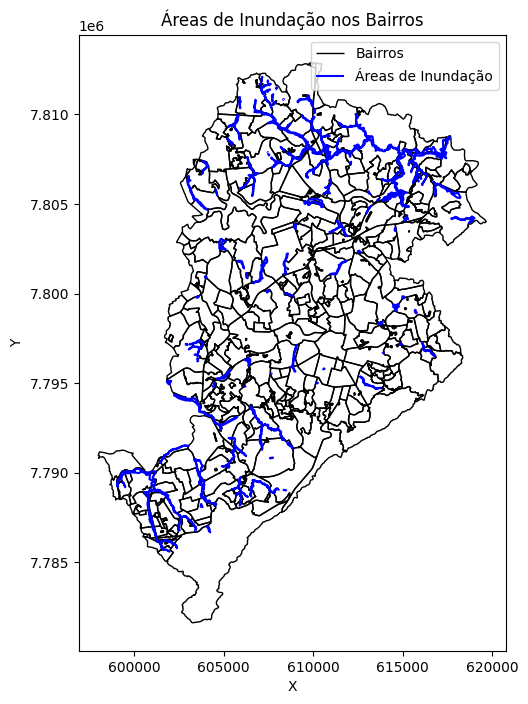

In [93]:
bairros_com_inundacao = gpd.sjoin(BAIRRO_POPULAR, AREA_RISCO_INUNDACAO, how='left', op='intersects')
bairros_com_inundacao = bairros_com_inundacao[~bairros_com_inundacao["ID_ARG"].isnull()]
fig, ax = plt.subplots(figsize=(8, 8))
BAIRRO_POPULAR.boundary.plot(ax=ax, color="black", linewidth=1)
#bairros_com_inundacao.plot(ax=ax, color="red", linewidth=0.5)
AREA_RISCO_INUNDACAO.boundary.plot(ax=ax, color="blue")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Áreas de Inundação nos Bairros")
plt.legend(["Bairros", "Áreas de Inundação", "Bairros com Inundação"])
plt.show()

**Atividade econômica**

Descompacte o arquivo ATIVIDADE_ECONOMICA_dbf.zip

In [94]:
def substituir_nome(nome):
    if nome in ('VILA CLORIS','VILA DIAS','VILA DO POMBAL','VILA DOS ANJOS','VILA FUMEC','VILA INESTAN','VILA MARIA',
                'VILA NOVA','VILA NOVA DOS MILIONARIOS','VILA OESTE','VILA PARIS'):
        return nome
    elif nome.startswith(('VILA DE', 'VILA DA', 'VILA DO', 'VILA DAS', 'VILA DOS')):
        return nome
    elif nome.startswith('VILA '): 
        partes = nome.split()
        if len(partes) > 1:
            return ' '.join(partes[1:])
    return nome

In [95]:
ATIVIDADE_ECONOMICA = gpd.read_file('./Dados BH/ATIVIDADE_ECONOMICA.shp')
ATIVIDADE_ECONOMICA['NOME_BAIRR'] = ATIVIDADE_ECONOMICA['NOME_BAIRR'].str.upper().apply(unidecode).str.replace("-", 
                                                                                                               " ").str.strip()
ATIVIDADE_ECONOMICA_B = gpd.sjoin(ATIVIDADE_ECONOMICA, BAIRRO_POPULAR, how='left', 
                                  op='intersects').groupby(["PORTE_EMPR","DESCRICAO_","TIPO_UNIDA","NOME_BAIRR",
                                                            "NOME_REGIO"]).size().reset_index(name="ATIVIDADE_ECONOMICA")

In [96]:
ATIVIDADE_ECONOMICA_B['NOME_BAIRR'] = ATIVIDADE_ECONOMICA_B['NOME_BAIRR'].apply(substituir_nome)
ATIVIDADE_ECONOMICA_B = CorrecaoBairros(ATIVIDADE_ECONOMICA_B,'NOME_BAIRR')
ATIVIDADE_ECONOMICA_B = ATIVIDADE_ECONOMICA_B.groupby('NOME_BAIRR')['ATIVIDADE_ECONOMICA'].sum().reset_index()
dados3_add5 = pd.merge(dados3_add4, ATIVIDADE_ECONOMICA_B, left_on=['Bairro'], right_on=['NOME_BAIRR'], 
                       how='left').drop(columns=['NOME_BAIRR'],axis=1)

**Atrativo turístico**

In [97]:
ATRATIVO_TURISTICO = gpd.read_file('./Dados BH/ATRATIVO_TURISTICO.shp')
ATRATIVO_TURISTICO['NOME_BAIRR'].fillna('', inplace=True)
ATRATIVO_TURISTICO['NOME_BAIRR'] = ATRATIVO_TURISTICO['NOME_BAIRR'].str.upper().apply(unidecode).str.replace("-", 
                                                                                                             " ").str.strip()
ATRATIVO_TURISTICO_B = CorrecaoBairros(ATRATIVO_TURISTICO,'NOME_BAIRR')
ATRATIVO_TURISTICO_B = gpd.sjoin(ATRATIVO_TURISTICO_B, BAIRRO_POPULAR, how='left', 
                                 op='intersects').groupby(["NOME_BAIRR"]).size().reset_index(name="ATRATIVO_TURISTICO")
dados3_add6 = pd.merge(dados3_add5, ATRATIVO_TURISTICO_B, left_on=['Bairro'], right_on=['NOME_BAIRR'], 
                       how='left').drop(columns=['NOME_BAIRR'],axis=1)

**Centro saúde**

In [98]:
CENTRO_SAUDE = gpd.read_file('./Dados BH/CENTRO_SAUDE.shp')
CENTRO_SAUDE['NOME_BAIRR'] = CENTRO_SAUDE['NOME_BAIRR'].str.upper().apply(unidecode).str.replace("-", " ").str.strip()
CENTRO_SAUDE = CorrecaoBairros(CENTRO_SAUDE,'NOME_BAIRR')
CENTRO_SAUDE_B = gpd.sjoin(CENTRO_SAUDE, BAIRRO_POPULAR, how='left', 
                           op='intersects').groupby(["NOME_BAIRR"]).size().reset_index(name="CENTRO_SAUDE")
dados3_add7 = pd.merge(dados3_add6, CENTRO_SAUDE_B, left_on=['Bairro'], right_on=['NOME_BAIRR'], 
                       how='left').drop(columns=['NOME_BAIRR'],axis=1)

**Coleta de resíduos ou seletiva**

Descompacte os arquivos COLETA_RESIDUOS_dbf.zip e COLETA_SELETIVA_PORTA_PORTA_dbf.zip

In [99]:
COLETA_RESIDUOS_orig = gpd.read_file('./Dados BH/COLETA_RESIDUOS.shp')
COLETA_SELETIVA_PORTA_PORTA_orig = gpd.read_file('./Dados BH/COLETA_SELETIVA_PORTA_PORTA.shp')

COLETA_RESIDUOS = COLETA_RESIDUOS_orig[COLETA_RESIDUOS_orig['PROGRAMACA']!='SEM COLETA PORTA A PORTA']
COLETA_SELETIVA_PORTA_PORTA = COLETA_SELETIVA_PORTA_PORTA_orig[COLETA_SELETIVA_PORTA_PORTA_orig['PROGRAMACA']!='SEM COLETA SELETIVA']

In [100]:
COLETA_RESIDUOS = COLETA_RESIDUOS[['PROGRAMACA', 'TURNO', 'geometry']]
COLETA_SELETIVA_PORTA_PORTA = COLETA_SELETIVA_PORTA_PORTA[['PROGRAMACA', 'TURNO', 'geometry']]
COLETA = pd.concat([COLETA_RESIDUOS, COLETA_SELETIVA_PORTA_PORTA], ignore_index=True)

In [101]:
COLETA_B = gpd.sjoin(COLETA, BAIRRO_POPULAR, how='left', op='intersects').groupby(["NOME"]).size().reset_index(name="COLETA")

In [102]:
COLETA_B['NOME'] = COLETA_B['NOME'].str.upper().apply(unidecode).str.replace("-"," ").str.strip()
COLETA_B = CorrecaoBairros(COLETA_B,'NOME')
COLETA_B = COLETA_B.groupby('NOME')['COLETA'].sum().reset_index()

In [103]:
dados3_add8 = pd.merge(dados3_add7, COLETA_B, left_on=['Bairro'], right_on=['NOME'], 
                       how='left').drop(columns=['NOME'],axis=1)

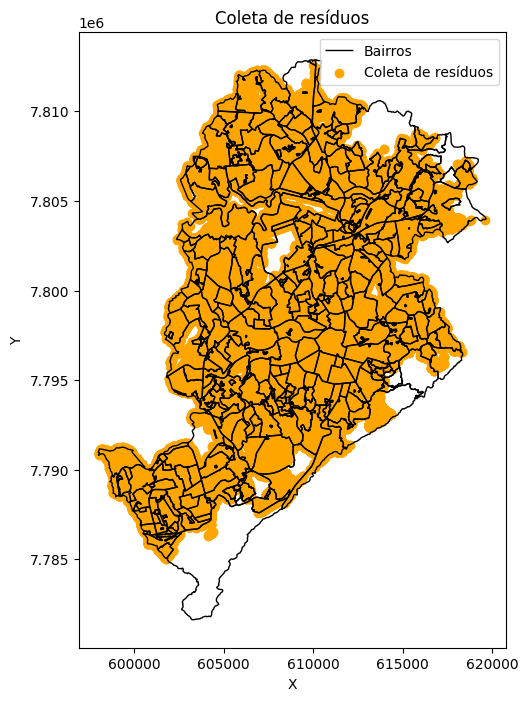

In [104]:
fig, ax = plt.subplots(figsize=(8, 8))
BAIRRO_POPULAR.boundary.plot(ax=ax, color="black", linewidth=1)
COLETA.boundary.plot(ax=ax, color="orange")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Coleta de resíduos")
plt.legend(["Bairros", "Coleta de resíduos"])
plt.show()

**Educação**

In [105]:
CRECHES_CONVENIADAS = gpd.read_file('./Dados BH/CRECHES_CONVENIADAS.shp')
ESCOLAS_ESTADUAIS = gpd.read_file('./Dados BH/ESCOLAS_ESTADUAIS.shp')
ESCOLAS_MUNICIPAIS_ENSINO_FUNDAMENTAL = gpd.read_file('./Dados BH/ESCOLAS_MUNICIPAIS_ENSINO_FUNDAMENTAL.shp')
ESCOLAS_PARTICULARES = gpd.read_file('./Dados BH/ESCOLAS_PARTICULARES.shp')
ENSINO_SUPERIOR = gpd.read_file('./Dados BH/ENSINO_SUPERIOR.shp')

ESCOLAS_ESTADUAIS['BAIRRO'].fillna('', inplace=True)

In [106]:
CRECHES_CONVENIADAS['BAIRRO'] = CRECHES_CONVENIADAS['BAIRRO'].str.upper().apply(unidecode).str.replace("-", " ").str.strip()
ESCOLAS_ESTADUAIS['BAIRRO'] = ESCOLAS_ESTADUAIS['BAIRRO'].str.upper().apply(unidecode).str.replace("-", " ").str.strip()
ESCOLAS_MUNICIPAIS_ENSINO_FUNDAMENTAL['BAIRRO'] = ESCOLAS_MUNICIPAIS_ENSINO_FUNDAMENTAL['BAIRRO'].str.upper().apply(
    unidecode).str.replace("-", " ").str.strip()
ESCOLAS_PARTICULARES['BAIRRO'] = ESCOLAS_PARTICULARES['BAIRRO'].str.upper().apply(unidecode).str.replace("-", " ").str.strip()
ENSINO_SUPERIOR['NOME_BAIRR'] = ENSINO_SUPERIOR['NOME_BAIRR'].str.upper().apply(unidecode).str.replace("-", " ").str.strip()

In [107]:
CRECHES_CONVENIADAS = CorrecaoBairros(CRECHES_CONVENIADAS,'BAIRRO')
ESCOLAS_ESTADUAIS = CorrecaoBairros(ESCOLAS_ESTADUAIS,'BAIRRO')
ESCOLAS_MUNICIPAIS_ENSINO_FUNDAMENTAL = CorrecaoBairros(ESCOLAS_MUNICIPAIS_ENSINO_FUNDAMENTAL,'BAIRRO')
ESCOLAS_PARTICULARES = CorrecaoBairros(ESCOLAS_PARTICULARES,'BAIRRO')
ENSINO_SUPERIOR = CorrecaoBairros(ENSINO_SUPERIOR,'NOME_BAIRR')

In [108]:
CRECHES_CONVENIADAS_B = gpd.sjoin(CRECHES_CONVENIADAS, BAIRRO_POPULAR, how='left', 
                                  op='intersects').groupby(["BAIRRO"]).size().reset_index(name="CRECHES_CONVENIADAS")
ESCOLAS_ESTADUAIS_B = gpd.sjoin(ESCOLAS_ESTADUAIS, BAIRRO_POPULAR, how='left', 
                                op='intersects').groupby(["BAIRRO"]).size().reset_index(name="ESCOLAS_ESTADUAIS")
ESCOLAS_MUNICIPAIS_ENSINO_FUNDAMENTAL_B = gpd.sjoin(ESCOLAS_MUNICIPAIS_ENSINO_FUNDAMENTAL, BAIRRO_POPULAR, how='left', 
                        op='intersects').groupby(["BAIRRO"]).size().reset_index(name="ESCOLAS_MUNICIPAIS_ENSINO_FUNDAMENTAL")
ESCOLAS_PARTICULARES_B = gpd.sjoin(ESCOLAS_PARTICULARES, BAIRRO_POPULAR, how='left', 
                                   op='intersects').groupby(["BAIRRO"]).size().reset_index(name="ESCOLAS_PARTICULARES")
ENSINO_SUPERIOR_B = gpd.sjoin(ENSINO_SUPERIOR, BAIRRO_POPULAR, how='left', 
                              op='intersects').groupby(["NOME_BAIRR"]).size().reset_index(name="ENSINO_SUPERIOR")

In [109]:
dados3_add9 = pd.merge(dados3_add8, CRECHES_CONVENIADAS_B, left_on=['Bairro'], right_on=['BAIRRO'], 
                       how='left').drop(columns=['BAIRRO'],axis=1)

In [110]:
dados3_add10 = pd.merge(dados3_add9, ESCOLAS_ESTADUAIS_B, left_on=['Bairro'], right_on=['BAIRRO'], 
                        how='left').drop(columns=['BAIRRO'],axis=1)

In [111]:
dados3_add11 = pd.merge(dados3_add10, ESCOLAS_MUNICIPAIS_ENSINO_FUNDAMENTAL_B, left_on=['Bairro'], right_on=['BAIRRO'], 
                        how='left').drop(columns=['BAIRRO'],axis=1)

In [112]:
dados3_add12 = pd.merge(dados3_add11, ESCOLAS_PARTICULARES_B, left_on=['Bairro'], right_on=['BAIRRO'], 
                        how='left').drop(columns=['BAIRRO'],axis=1)

In [113]:
dados3_add13 = pd.merge(dados3_add12, ENSINO_SUPERIOR_B, left_on=['Bairro'], right_on=['NOME_BAIRR'], 
                        how='left').drop(columns=['NOME_BAIRR'],axis=1)

**Hospitais**

In [114]:
HOSPITAIS = gpd.read_file('./Dados BH/HOSPITAIS.shp')
HOSPITAIS['NOME_BAIRR'] = HOSPITAIS['NOME_BAIRR'].str.upper().apply(unidecode).str.replace("-", " ").str.strip()
HOSPITAIS = CorrecaoBairros(HOSPITAIS,'NOME_BAIRR')
HOSPITAIS_B = gpd.sjoin(HOSPITAIS, BAIRRO_POPULAR, how='left', 
                        op='intersects').groupby(["NOME_BAIRR"]).size().reset_index(name="HOSPITAIS")
dados3_add14 = pd.merge(dados3_add13, HOSPITAIS_B, left_on=['Bairro'], right_on=['NOME_BAIRR'], 
                        how='left').drop(columns=['NOME_BAIRR'],axis=1)

**IVS**

In [115]:
IVS = gpd.read_file('./Dados BH/IVS_INDICE_VULNERAB_SAUDE.shp')

In [116]:
DescritivaCat(IVS,['IVS_2012'])

Variável      Categoria  Freq. Absoluta (N)  Freq. Relativa (%)
0  IVS_2012          Baixo                1330               33.79
1  IVS_2012        Elevado                 737               18.72
2  IVS_2012  Muito Elevado                 303                7.70
3  IVS_2012          Médio                1460               37.09
4  IVS_2012   Não Avaliado                 106                2.69

* Baixo = 0
* Médio = 1
* Elevado = 2
* Muito Elevado = 3

In [117]:
categoria_IVS = {"Baixo": 0, "Médio": 1, "Elevado": 2, "Muito Elevado": 3}
IVS['IVS'] = IVS['IVS_2012'].map(categoria_IVS)
IVS = IVS[['IVS','geometry']]
IVS_B = gpd.sjoin(IVS, BAIRRO_POPULAR, how='left', op='intersects').groupby(["NOME"])['IVS'].mean().reset_index()
IVS_B['NOME'] = IVS_B['NOME'].str.upper().apply(unidecode).str.replace("-"," ").str.strip()
IVS_B = CorrecaoBairros(IVS_B,'NOME')
IVS_B = IVS_B.groupby('NOME')['IVS'].mean().reset_index()
dados3_add15 = pd.merge(dados3_add14, IVS_B, left_on=['Bairro'], right_on=['NOME'], how='left').drop(columns=['NOME'],axis=1)

**Transportes público**

In [118]:
METRO = gpd.read_file('./Dados BH/METRO.shp')
PONTO_ONIBUS = gpd.read_file('./Dados BH/PONTO_ONIBUS.shp')
METRO = METRO[['ID_MTR','geometry']]
PONTO_ONIBUS = PONTO_ONIBUS[['NOME_SUB_L','geometry']]

In [119]:
METRO_B = gpd.sjoin(METRO, BAIRRO_POPULAR, how='left', op='intersects').groupby(["NOME"]).size().reset_index(name="METRO")
METRO_B['NOME'] = METRO_B['NOME'].str.upper().apply(unidecode).str.replace("-"," ").str.strip()
METRO_B = CorrecaoBairros(METRO_B,'NOME')
METRO_B = METRO_B.groupby('NOME')['METRO'].sum().reset_index()
dados3_add16 = pd.merge(dados3_add15, METRO_B, left_on=['Bairro'], right_on=['NOME'], how='left').drop(columns=['NOME'],axis=1)

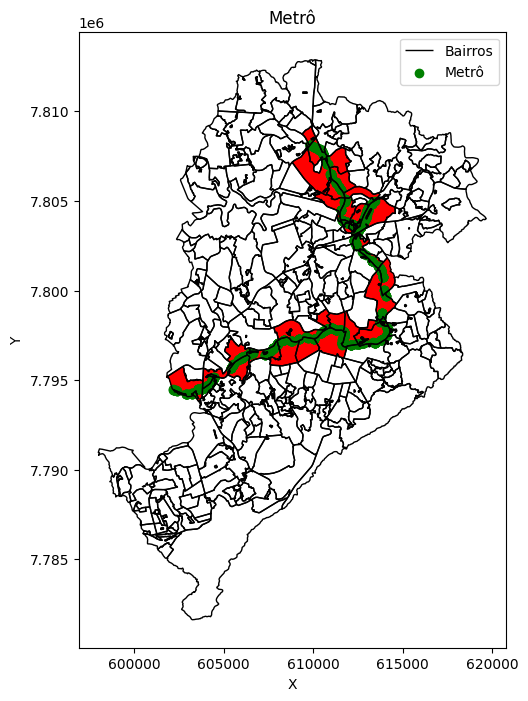

In [120]:
bairros_com_METRO = gpd.sjoin(BAIRRO_POPULAR, METRO, how='left', op='intersects')
bairros_com_METRO = bairros_com_METRO[~bairros_com_METRO["ID_MTR"].isnull()]
fig, ax = plt.subplots(figsize=(8, 8))
BAIRRO_POPULAR.boundary.plot(ax=ax, color="black", linewidth=1)
bairros_com_METRO.plot(ax=ax, color="red", linewidth=0.5)
METRO.boundary.plot(ax=ax, color="green")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Metrô")
plt.legend(["Bairros", "Metrô"])
plt.show()

In [121]:
PONTO_ONIBUS_B = gpd.sjoin(PONTO_ONIBUS, BAIRRO_POPULAR, how='left', 
                           op='intersects').groupby(["NOME"]).size().reset_index(name="PONTO_ONIBUS")
PONTO_ONIBUS_B['NOME'] = PONTO_ONIBUS_B['NOME'].str.upper().apply(unidecode).str.replace("-"," ").str.strip()
PONTO_ONIBUS_B = CorrecaoBairros(PONTO_ONIBUS_B,'NOME')
PONTO_ONIBUS_B = PONTO_ONIBUS_B.groupby('NOME')['PONTO_ONIBUS'].sum().reset_index()
dados3_add17 = pd.merge(dados3_add16, PONTO_ONIBUS_B, left_on=['Bairro'], right_on=['NOME'], 
                        how='left').drop(columns=['NOME'],axis=1)

**População**

In [122]:
POP_DOMIC_BAIRRO_2010 = gpd.read_file('./Dados BH/POP_DOMIC_BAIRRO_2010.shp')
POP_DOMIC_BAIRRO_2010 = POP_DOMIC_BAIRRO_2010[['NOME_BAIRR','POPULACAO','DOMICILIO','HAB_DOM','HAB_KM2']]

In [123]:
POP_DOMIC_BAIRRO_2010['NOME_BAIRR'] = POP_DOMIC_BAIRRO_2010['NOME_BAIRR'].str.upper().apply(unidecode).str.replace("-",
                                                                                                            " ").str.strip()

In [124]:
POP_DOMIC_BAIRRO_2010 = CorrecaoBairros(POP_DOMIC_BAIRRO_2010,'NOME_BAIRR')

In [125]:
POP_DOMIC_BAIRRO_2010_agg = POP_DOMIC_BAIRRO_2010.groupby('NOME_BAIRR').agg({'POPULACAO': 'sum', 'DOMICILIO': 'sum', 
                                                                             'HAB_KM2': 'sum', 'HAB_DOM': 'mean'}).reset_index()
POP_DOMIC_BAIRRO_2010_agg.columns = ['NOME_BAIRR', 'POPULACAO_TOTAL', 'DOMICILIO_TOTAL', 'HAB_KM2_TOTAL', 'HAB_DOM_MEDIA']

In [126]:
dados3_add18 = pd.merge(dados3_add17, POP_DOMIC_BAIRRO_2010_agg, left_on=['Bairro'], right_on=['NOME_BAIRR'], 
                        how='left').drop(columns=['PertenceBH','NOME_BAIRR_x','NOME_BAIRR'],axis=1)

Após enriquecer o conjunto de dados, chegamos no seguinte dataframe:

In [127]:
dados3_add18.head()

Endereço  Taxas adm  Garagem      Preço  Quartos  \
0      Avenida Raja Gabaglia, 1583      470.0        1   330000.0        1   
1          Rua Marechal Hermes, 81      750.0        4  1590000.0        4   
2                  Rua Juruna, 110        NaN        6   550000.0        3   
3  Rua Maria Pereira de Araújo, 15      500.0        1   450000.0        3   
4                  Rua Matipó, 455      750.0        2   549900.0        4   

   Área do imóvel         Bairro          Cidade   Latitude  Longitude  \
0              40     LUXEMBURGO  Belo Horizonte -19.936415 -43.953396   
1             158      GUTIERREZ  Belo Horizonte -19.937155 -43.958694   
2             278      PINDORAMA  Belo Horizonte -19.912982 -44.019944   
3              87        CASTELO  Belo Horizonte -19.886147 -44.004236   
4             153  SANTO ANTONIO  Belo Horizonte -19.947351 -43.943470   

  Tipo_Imovel    REGIONAL  ACADEMIA_CEU_ABERTO  AREA_ABRANGENCIA_SAUDE  \
0      Prédio  CENTRO SUL                  1.0                     NaN   
1      Prédio       OESTE                  1.0                     NaN   
2        Casa    NOROESTE                  3.0                     3.0   
3      Prédio    PAMPULHA                  2.0                     NaN   
4      Prédio  CENTRO SUL                  1.0                    21.0   

   AREA_PUBLICA_WIFI  AREA_RISCO_ESCORREGAMENTO  AREA_RISCO_INUNDACAO  \
0                NaN                        2.0                   NaN   
1                NaN                        1.0                   1.0   
2                NaN                        1.0                   NaN   
3                NaN                        NaN                   2.0   
4                1.0                        1.0                   1.0   

   ATIVIDADE_ECONOMICA  ATRATIVO_TURISTICO  CENTRO_SAUDE  COLETA  \
0                 2088                 1.0           NaN     278   
1                 4125                 NaN           NaN     746   
2                 2849                 NaN           1.0     559   
3                 6287                 1.0           NaN     678   
4                 5701                 1.0           2.0     821   

   CRECHES_CONVENIADAS  ESCOLAS_ESTADUAIS  \
0                  NaN                NaN   
1                  NaN                NaN   
2                  1.0                4.0   
3                  1.0                NaN   
4                  1.0                1.0   

   ESCOLAS_MUNICIPAIS_ENSINO_FUNDAMENTAL  ESCOLAS_PARTICULARES  \
0                                    NaN                   2.0   
1                                    NaN                  10.0   
2                                    NaN                   2.0   
3                                    NaN                  11.0   
4                                    4.0                  11.0   

   ENSINO_SUPERIOR  HOSPITAIS       IVS  METRO  PONTO_ONIBUS  POPULACAO_TOTAL  \
0              3.0        2.0  0.461538    NaN            85           6412.0   
1              4.0        3.0  0.529412    NaN           253          17507.0   
2              NaN        NaN  1.393939    NaN           177          17579.0   
3              7.0        NaN  0.133333    NaN           224          17083.0   
4              2.0        NaN  0.216667    NaN           145          21642.0   

   DOMICILIO_TOTAL  HAB_KM2_TOTAL  HAB_DOM_MEDIA  
0           2244.0        10309.0           2.86  
1           6059.0        14039.0           2.89  
2           5497.0        10946.0           3.20  
3           6093.0         7088.0           2.80  
4           8322.0        16559.0           2.60

As colunas adicionadas que tiverem dados ausentes serão preenchidas com 0.

In [128]:
columns_to_fill = ['ACADEMIA_CEU_ABERTO', 'AREA_ABRANGENCIA_SAUDE', 'AREA_PUBLICA_WIFI', 'AREA_RISCO_ESCORREGAMENTO', 
                   'AREA_RISCO_INUNDACAO', 'ATIVIDADE_ECONOMICA', 'ATRATIVO_TURISTICO', 'CENTRO_SAUDE', 'COLETA', 
                   'CRECHES_CONVENIADAS', 'ESCOLAS_ESTADUAIS', 'ESCOLAS_MUNICIPAIS_ENSINO_FUNDAMENTAL', 'ESCOLAS_PARTICULARES', 
                   'ENSINO_SUPERIOR', 'HOSPITAIS', 'METRO', 'PONTO_ONIBUS']
dados3_add18[columns_to_fill] = dados3_add18[columns_to_fill].fillna(0)

Vamos criar um dicionário para indicar o significado das variáveis que foram inseridas:
* ACADEMIA_CEU_ABERTO: número de equipamentos esportivos a céu aberto
* AREA_ABRANGENCIA_SAUDE: número de vezes que aquele bairro está contido em alguma área com abrangência saúde
* AREA_PUBLICA_WIFI: número de áreas públicas com Wi-Fi
* AREA_RISCO_ESCORREGAMENTO: número de vezes que aquele bairro está contido em áreas com risco escorregamento
* AREA_RISCO_INUNDACAO: número de vezes que aquele bairro está contido em áreas com risco inundação
* ATIVIDADE_ECONOMICA: número de atividades econômicas
* ATRATIVO_TURISTICO: número de atrativos turísticos
* CENTRO_SAUDE: número de centros de saúde
* COLETA: número de coletas de resíduos ou seletivas
* CRECHES_CONVENIADAS: número de creches conveniadas
* ESCOLAS_ESTADUAIS: número de escolas estaduais
* ESCOLAS_MUNICIPAIS_ENSINO_FUNDAMENTAL: número de escolas municipais de ensino fundamental
* ESCOLAS_PARTICULARES: número de escolas particulares
* ENSINO_SUPERIOR: número de faculdades/universidades
* HOSPITAIS: número de hospitais nos bairros
* IVS: IVS médio do bairro, valores entre 0 e 3, 0 = Baixo e 3 = Muito elevado
* METRO: bairros que contém estações de metrô
* PONTO_ONIBUS: número de pontos de ônibus nos bairros
* POPULACAO_TOTAL: população total dos bairros
* DOMICILIO_TOTAL: número total de domicílios nos bairros
* HAB_KM2_TOTAL: quantidade total de habitantes por km² nos bairros
* HAB_DOM_MEDIA: quantidade média de habitantes por domicílio nos bairros

Agrupamento das informações que se referem ao mesmo setor:
* Educação pública;
* Centro de saúde e hospital;
* Metrô.

In [129]:
dados3_add18['CENTRO_SAUDE_HOSPITAL'] = dados3_add18['CENTRO_SAUDE']+dados3_add18['HOSPITAIS']
dados3_add18['EDUCACAO_PUBLICA'] = dados3_add18['CRECHES_CONVENIADAS']+dados3_add18['ESCOLAS_ESTADUAIS']+dados3_add18['ESCOLAS_MUNICIPAIS_ENSINO_FUNDAMENTAL']
dados3_add18['TEM_ESTACAO_METRO'] = np.where(dados3_add18['METRO'] > 0, 'Sim', 'Não')

# Análise descritiva - Univariada

In [130]:
def Descritiva1Num1Cat(dados,var_num,var_cat):
    dados = dados.dropna(subset=[var_num])
    tabela = dados.groupby(var_cat)[var_num].describe().round(2)
    tabela = tabela.reset_index()
    tabela.columns = ['Variável','Freq. Absoluta','Média','Desvio Padrão','Mínimo','Q1','Q2 (Mediana)','Q3','Máximo']
    return tabela

In [131]:
dados_completos = dados3_add18.copy()

#### Preço

In [132]:
DescritivaNum(dados_completos,['Preço']).round(2)

Variável  Freq. Absoluta       Média  Desvio Padrão   Mínimo        Q1  \
0    Preço          4985.0  1039213.49     1063970.39  95000.0  435000.0   

   Q2 (Mediana)         Q3      Máximo  
0      700000.0  1250000.0  11900000.0

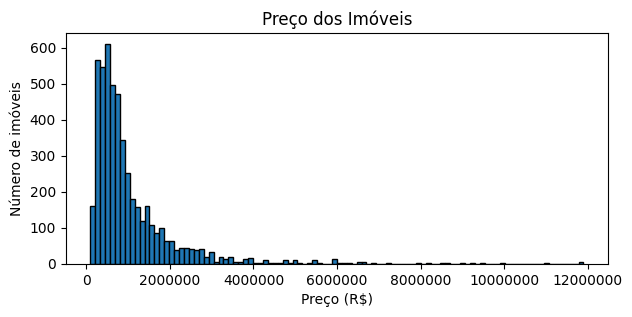

In [133]:
plt.figure(figsize=(7, 3))
plt.hist(dados_completos['Preço'], bins=100, edgecolor='black')
plt.xlabel('Preço (R$)')
plt.xticks(rotation=0)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.ylabel('Número de imóveis')
plt.title('Preço dos Imóveis')
plt.show()

In [134]:
#Cálculo do preço do m²
dados_completos['Preço_m2'] = dados_completos["Preço"] / dados_completos["Área do imóvel"]
DescritivaNum(dados_completos,['Preço_m2']).round(2)

Variável  Freq. Absoluta    Média  Desvio Padrão   Mínimo       Q1  \
0  Preço_m2          4985.0  7058.07        3794.42  1104.17  4266.67   

   Q2 (Mediana)       Q3    Máximo  
0       5888.89  9038.46  40714.29

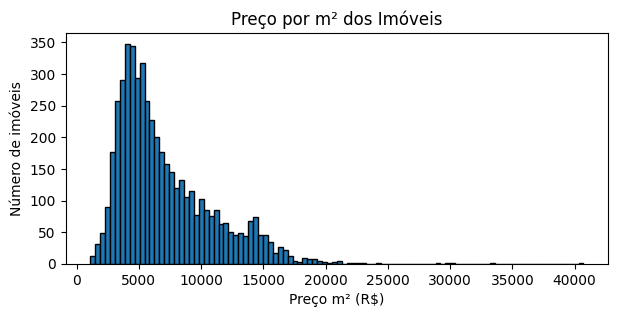

In [135]:
plt.figure(figsize=(7, 3))
plt.hist(dados_completos['Preço_m2'], bins=100, edgecolor='black')
plt.xlabel('Preço m² (R$)')
plt.xticks(rotation=0)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.ylabel('Número de imóveis')
plt.title('Preço por m² dos Imóveis')
plt.show()

#### Bairros e regionais

In [136]:
DescritivaCat(dados_completos,['Bairro']).sort_values(by='Freq. Absoluta (N)', ascending=False).head(5)

Variável        Categoria  Freq. Absoluta (N)  Freq. Relativa (%)
20    Bairro          BURITIS                 459                9.21
95    Bairro          LOURDES                 328                6.58
169   Bairro            SERRA                 221                4.43
139   Bairro  SAGRADA FAMILIA                 218                4.37
65    Bairro     FUNCIONARIOS                 210                4.21

In [137]:
DescritivaCat(dados_completos,['Bairro']).sort_values(by='Freq. Absoluta (N)', ascending=False).tail(35)

Variável                      Categoria  Freq. Absoluta (N)  \
4     Bairro                ALVARO CAMARGOS                   1   
183   Bairro                     VILA OESTE                   1   
186   Bairro                   VISTA ALEGRE                   1   
18    Bairro              BRASIL INDUSTRIAL                   1   
28    Bairro                        CARDOSO                   1   
181   Bairro                      VERA CRUZ                   1   
175   Bairro                  TEIXEIRA DIAS                   1   
179   Bairro                           URCA                   1   
111   Bairro                         NAZARE                   1   
151   Bairro                    SANTA SOFIA                   1   
43    Bairro         CONJUNTO CELSO MACHADO                   1   
92    Bairro                       LAGOINHA                   1   
118   Bairro                         OLARIA                   1   
109   Bairro                        MIRAMAR                   1   
104   Bairro                 MARIA VIRGINIA                   1   
102   Bairro                  MARIA GORETTI                   1   
127   Bairro                          PENHA                   1   
128   Bairro                     PETROPOLIS                   1   
129   Bairro                      PINDORAMA                   1   
130   Bairro                         PIRAJA                   1   
97    Bairro                MADRE GERTRUDES                   1   
132   Bairro                       PIRINEUS                   1   
90    Bairro                    JONAS VEIGA                   1   
157   Bairro                  SAO CRISTOVAO                   1   
136   Bairro               PRIMEIRO DE MAIO                   1   
137   Bairro                    PROVIDENCIA                   1   
87    Bairro               JARDIM MONTANHES                   1   
72    Bairro              GRANJA DE FREITAS                   1   
68    Bairro                         GLORIA                   1   
148   Bairro                    SANTA MARIA                   1   
61    Bairro          FLAVIO MARQUES LISBOA                   1   
58    Bairro              ETELVINA CARNEIRO                   1   
50    Bairro  DISTRITO INDUSTRIAL DO JATOBA                   1   
45    Bairro                      COQUEIROS                   1   
0     Bairro                      AEROPORTO                   1   

     Freq. Relativa (%)  
4                  0.02  
183                0.02  
186                0.02  
18                 0.02  
28                 0.02  
181                0.02  
175                0.02  
179                0.02  
111                0.02  
151                0.02  
43                 0.02  
92                 0.02  
118                0.02  
109                0.02  
104                0.02  
102                0.02  
127                0.02  
128                0.02  
129                0.02  
130                0.02  
97                 0.02  
132                0.02  
90                 0.02  
157                0.02  
136                0.02  
137                0.02  
87                 0.02  
72                 0.02  
68                 0.02  
148                0.02  
61                 0.02  
58                 0.02  
50                 0.02  
45                 0.02  
0                  0.02

In [138]:
topbairros_maior_freq = dados_completos['Bairro'].value_counts(normalize=True).head(25)
#topbairros_menor_freq = dados_completos['Bairro'].value_counts(normalize=True).tail(40)
topbairros_maior_freq = topbairros_maior_freq[::-1]
#topbairros_menor_freq = top20bairros_menor_freq[::-1]

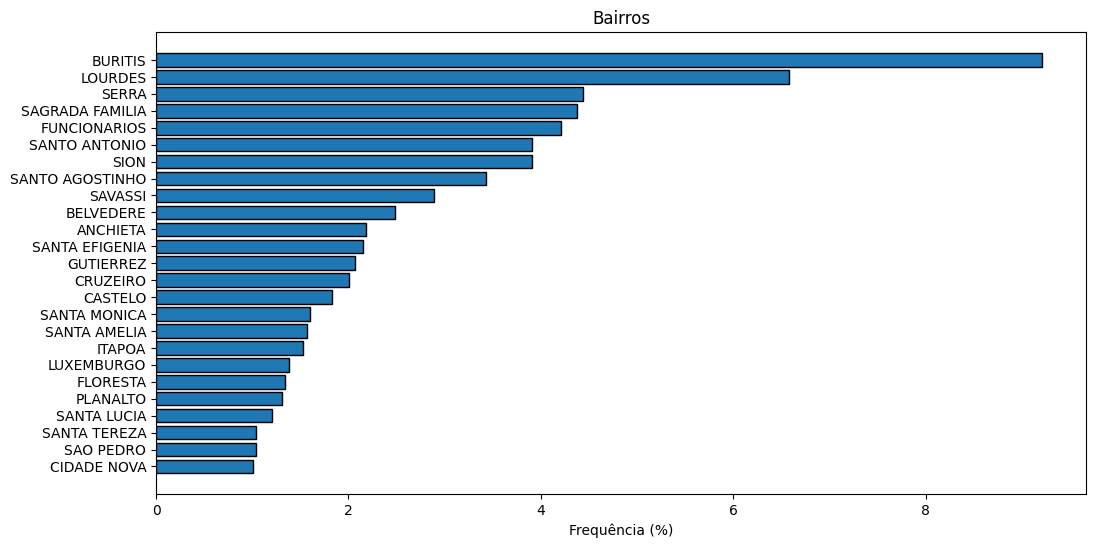

In [139]:
plt.figure(figsize=(12, 6))
plt.barh(topbairros_maior_freq.index, topbairros_maior_freq.values*100, edgecolor='black')
plt.title('Bairros')
plt.xlabel('Frequência (%)')
plt.ylabel("")
plt.show()

In [140]:
DescritivaCat(dados_completos,['REGIONAL']).sort_values(by='Freq. Absoluta (N)', ascending=False)

Variável   Categoria  Freq. Absoluta (N)  Freq. Relativa (%)
1  REGIONAL  CENTRO SUL                2155               43.23
6  REGIONAL       OESTE                 853               17.11
7  REGIONAL    PAMPULHA                 522               10.47
2  REGIONAL       LESTE                 489                9.81
3  REGIONAL    NORDESTE                 343                6.88
8  REGIONAL  VENDA NOVA                 248                4.97
4  REGIONAL    NOROESTE                 170                3.41
5  REGIONAL       NORTE                 131                2.63
0  REGIONAL    BARREIRO                  74                1.48

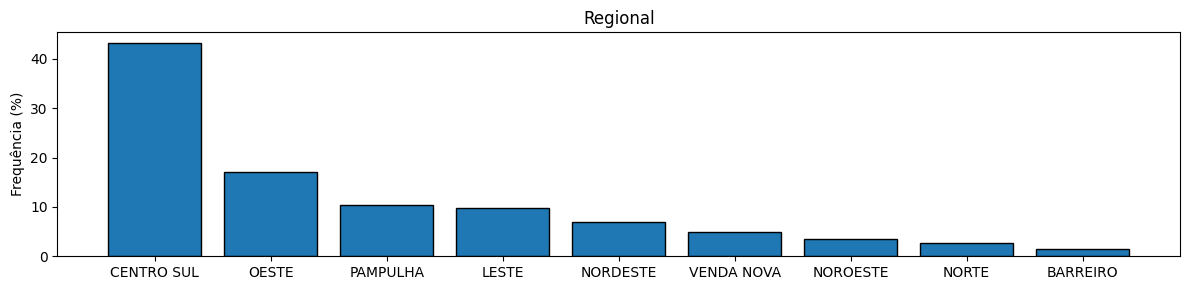

In [141]:
plt.figure(figsize=(12, 3))
plt.bar(dados_completos['REGIONAL'].value_counts(normalize=True).index, 
        dados_completos['REGIONAL'].value_counts(normalize=True).values*100, edgecolor='black')
plt.xlabel('')
plt.ylabel('Frequência (%)')
plt.title('Regional')
plt.xticks(dados_completos['REGIONAL'].value_counts().index)
plt.tight_layout()
plt.show()

#### Taxas administrativas, quartos, garagens e tipo de imóvel

In [142]:
dados_completos['Taxa_m2'] = dados_completos["Taxas adm"] / dados_completos["Área do imóvel"]

In [143]:
#DescritivaNum(dados_completos,['Taxas adm','Quartos','Garagem']).round(2)
DescritivaNum(dados_completos,['Taxas adm']).round(2)

Variável  Freq. Absoluta   Média  Desvio Padrão  Mínimo     Q1  \
0  Taxas adm          3661.0  766.52         777.31     1.0  300.0   

   Q2 (Mediana)      Q3  Máximo  
0         502.0  1000.0  9850.0

In [144]:
DescritivaNum(dados_completos,['Taxa_m2']).round(2)

Variável  Freq. Absoluta  Média  Desvio Padrão  Mínimo    Q1  Q2 (Mediana)  \
0  Taxa_m2          3661.0   5.82           4.22     0.0  3.02          5.08   

     Q3  Máximo  
0  8.24   82.08

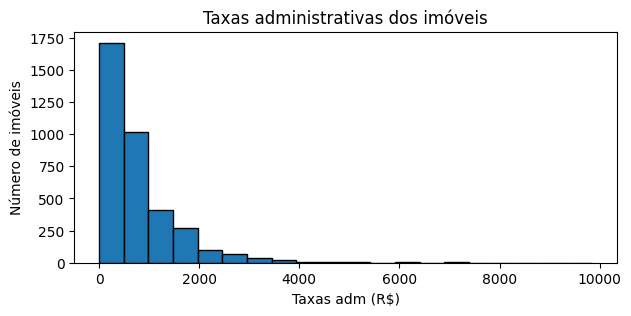

In [145]:
plt.figure(figsize=(7, 3))
plt.hist(dados_completos['Taxas adm'], bins=20, edgecolor='black')
plt.xlabel('Taxas adm (R$)')
plt.xticks(rotation=0)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.ylabel('Número de imóveis')
plt.title('Taxas administrativas dos imóveis')
plt.show()

In [146]:
DescritivaCat(dados_completos,['Quartos']).sort_values(by='Freq. Absoluta (N)', ascending=False).head(5)

Variável  Categoria  Freq. Absoluta (N)  Freq. Relativa (%)
2  Quartos          3                2047               41.06
3  Quartos          4                1493               29.95
1  Quartos          2                1106               22.19
4  Quartos          5                 140                2.81
0  Quartos          1                 139                2.79

In [147]:
DescritivaCat(dados_completos,['Garagem']).sort_values(by='Freq. Absoluta (N)', ascending=False).head(5)

Variável  Categoria  Freq. Absoluta (N)  Freq. Relativa (%)
1  Garagem          2                2123               42.59
0  Garagem          1                1325               26.58
2  Garagem          3                 769               15.43
3  Garagem          4                 532               10.67
4  Garagem          5                  98                1.97

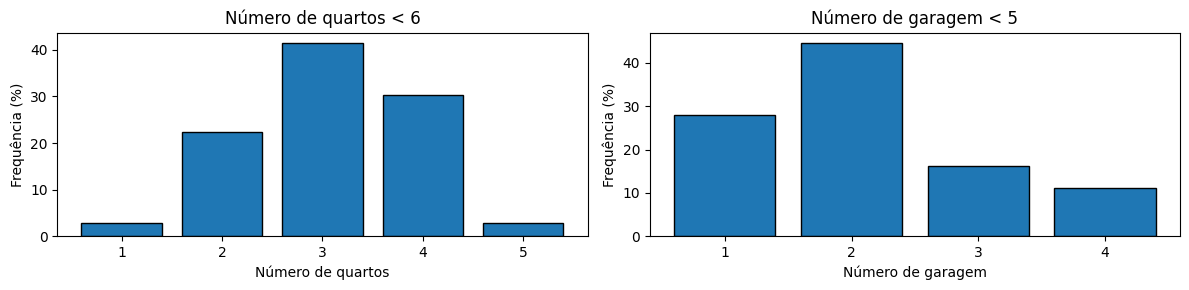

In [148]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].bar(dados_completos[dados_completos['Quartos'] < 6]['Quartos'].value_counts(normalize=True).index, 
           dados_completos[dados_completos['Quartos'] < 6]['Quartos'].value_counts(normalize=True).values*100, 
           edgecolor='black')
axs[0].set_xlabel('Número de quartos')
axs[0].set_ylabel('Frequência (%)')
axs[0].set_title('Número de quartos < 6')
axs[0].set_xticks(dados_completos[dados_completos['Quartos'] < 6]['Quartos'].value_counts().index)

axs[1].bar(dados_completos[dados_completos['Garagem'] < 5]['Garagem'].value_counts(normalize=True).index, 
           dados_completos[dados_completos['Garagem'] < 5]['Garagem'].value_counts(normalize=True).values*100, 
           edgecolor='black')
axs[1].set_xlabel('Número de garagem')
axs[1].set_ylabel('Frequência (%)')
axs[1].set_title('Número de garagem < 5')
axs[1].set_xticks(dados_completos[dados_completos['Garagem'] < 5]['Garagem'].value_counts().index)
plt.tight_layout()
plt.show()

In [149]:
DescritivaCat(dados_completos,['Tipo_Imovel']).sort_values(by='Freq. Absoluta (N)')

Variável            Categoria  Freq. Absoluta (N)  Freq. Relativa (%)
2  Tipo_Imovel                Hotel                   1                0.02
1  Tipo_Imovel  Estacionamento/Lote                   4                0.08
0  Tipo_Imovel                 Casa                1323               26.54
3  Tipo_Imovel               Prédio                3657               73.36

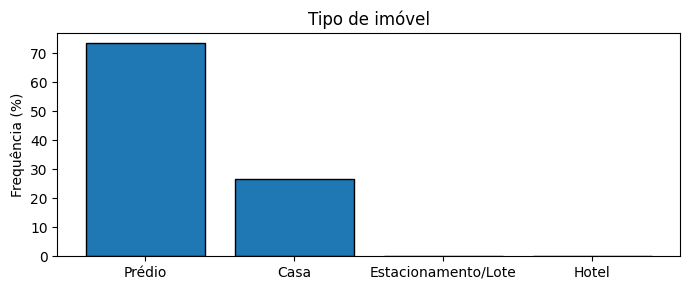

In [150]:
plt.figure(figsize=(7, 3))
plt.bar(dados_completos['Tipo_Imovel'].value_counts(normalize=True).index, 
        dados_completos['Tipo_Imovel'].value_counts(normalize=True).values*100, edgecolor='black')
plt.xlabel('')
plt.ylabel('Frequência (%)')
plt.title('Tipo de imóvel')
plt.xticks(dados_completos['Tipo_Imovel'].value_counts().index)
plt.tight_layout()
plt.show()

#### Variáveis socioeconômicas

In [151]:
DescritivaNum(dados_completos,['ACADEMIA_CEU_ABERTO','AREA_ABRANGENCIA_SAUDE','AREA_PUBLICA_WIFI','AREA_RISCO_ESCORREGAMENTO',
        'AREA_RISCO_INUNDACAO','ATIVIDADE_ECONOMICA','ATRATIVO_TURISTICO','CENTRO_SAUDE_HOSPITAL','COLETA','EDUCACAO_PUBLICA',
        'ESCOLAS_PARTICULARES','ENSINO_SUPERIOR','IVS','PONTO_ONIBUS','POPULACAO_TOTAL','DOMICILIO_TOTAL','HAB_KM2_TOTAL',
        'HAB_DOM_MEDIA']).round(2)

Variável  Freq. Absoluta     Média  Desvio Padrão  \
0         ACADEMIA_CEU_ABERTO          4985.0      1.84           1.50   
1      AREA_ABRANGENCIA_SAUDE          4985.0      4.73           6.74   
2           AREA_PUBLICA_WIFI          4985.0      0.64           1.17   
3   AREA_RISCO_ESCORREGAMENTO          4985.0      1.35           1.80   
4        AREA_RISCO_INUNDACAO          4985.0      1.11           1.52   
5         ATIVIDADE_ECONOMICA          4985.0   4907.76        3213.68   
6          ATRATIVO_TURISTICO          4985.0      1.94           3.13   
7       CENTRO_SAUDE_HOSPITAL          4985.0      2.28           3.45   
8                      COLETA          4985.0    646.02         313.77   
9            EDUCACAO_PUBLICA          4985.0      2.26           2.10   
10       ESCOLAS_PARTICULARES          4985.0      6.88           3.63   
11            ENSINO_SUPERIOR          4985.0      4.92           5.83   
12                        IVS          4985.0      0.38           0.39   
13               PONTO_ONIBUS          4985.0    308.20         231.52   
14            POPULACAO_TOTAL          4985.0  15513.14        8384.16   
15            DOMICILIO_TOTAL          4985.0   5612.92        3058.56   
16              HAB_KM2_TOTAL          4985.0  10899.43        4439.10   
17              HAB_DOM_MEDIA          4985.0      2.79           0.29   

    Mínimo       Q1  Q2 (Mediana)        Q3    Máximo  
0      0.0     1.00          2.00      2.00      6.00  
1      0.0     0.00          0.00     10.00     24.00  
2      0.0     0.00          0.00      1.00     10.00  
3      0.0     0.00          1.00      2.00     15.00  
4      0.0     0.00          1.00      1.00     10.00  
5    107.0  2508.00       4366.00   6945.00  22365.00  
6      0.0     0.00          1.00      2.00     23.00  
7      0.0     0.00          1.00      2.00     20.00  
8     31.0   384.00        614.00    839.00   1335.00  
9      0.0     1.00          2.00      3.00     11.00  
10     0.0     4.00          7.00     10.00     21.00  
11     0.0     1.00          2.00      7.00     22.00  
12     0.0     0.07          0.31      0.46      2.80  
13     1.0   180.00        291.00    356.00   1850.00  
14     0.0  8838.00      15285.00  20277.00  34395.00  
15     0.0  3126.00       5243.00   7486.00  12216.00  
16     0.0  7679.00      10794.00  15007.00  32787.00  
17     0.0     2.60          2.75      2.97      3.76

In [152]:
DescritivaCat(dados_completos,['TEM_ESTACAO_METRO'])

Variável Categoria  Freq. Absoluta (N)  Freq. Relativa (%)
0  TEM_ESTACAO_METRO       Não                4543               91.13
1  TEM_ESTACAO_METRO       Sim                 442                8.87

**Resultados:**
* Preço:
    * O imóvel com maior preço é R$\$$11.900.00,00 e o menor R$\$$95.000,00.
    * 50\% dos imóveis custam até R$\$$700.000,00.
    * O preço do m² dos imóveis é R$\$$7058,07.
    * R$\$$5,82 é o valor da taxa administrativa média por m².

* Bairros e regionais:
    * Buritis e Lourdes são os bairros com mais imóveis.
    * 35 bairros tiveram apenas um imóvel.
    * Por consequência, as regionais Centro Sul e Barreiro tiveram as maiores e menores quantidade de imóveis, respectivamente.

* Taxas administrativas, quartos, garagens e tipo de imóveis:
    * O taxa administrativa média geral é R$\$$766,52, podendo chegar a R$\$$9850,00.
    * Aproximadamente 41\% dos imóveis tem 3 quartos e 43\% 2 garagens.
    * 73\% dos imóves podem ser considerados prédios e 26\% casas.

* Variáveis socioeconômicas:
    * Em média, os imóveis tem no seu bairro 4907 atividades econômicas registradas, podendo chegar a 22365.
    * 442 imóveis tem estação de metrô perto.
    * IVS médio é 0,38.

# Análises bivariadas e multivariadas

#### Bairros e regionais

In [153]:
Descritiva1Num1Cat(dados_completos,'Preço','Bairro').sort_values(by='Média', ascending=False)

Variável  Freq. Absoluta       Média  Desvio Padrão  \
50   DISTRITO INDUSTRIAL DO JATOBA             1.0  4800000.00            NaN   
8                     BANDEIRANTES            22.0  4138363.64     3314671.76   
99                     MANGABEIRAS            23.0  3200391.30     1873292.89   
36                   CIDADE JARDIM             4.0  3112500.00     2760137.38   
19                         BRAUNAS             3.0  3016666.67     1375075.76   
..                             ...             ...         ...            ...   
175                  TEIXEIRA DIAS             1.0   150000.00            NaN   
17                      BONSUCESSO             2.0   145000.00       35355.34   
174              SOLAR DO BARREIRO             3.0   133000.00       24637.37   
72               GRANJA DE FREITAS             1.0   130000.00            NaN   
157                  SAO CRISTOVAO             1.0    95000.00            NaN   

        Mínimo         Q1  Q2 (Mediana)         Q3      Máximo  
50   4800000.0  4800000.0     4800000.0  4800000.0   4800000.0  
8     159000.0  1990000.0     3100000.0  5600000.0  11900000.0  
99    870000.0  1875000.0     2850000.0  3450000.0   7900000.0  
36    560000.0   807500.0     3195000.0  5500000.0   5500000.0  
19   1650000.0  2325000.0     3000000.0  3700000.0   4400000.0  
..         ...        ...           ...        ...         ...  
175   150000.0   150000.0      150000.0   150000.0    150000.0  
17    120000.0   132500.0      145000.0   157500.0    170000.0  
174   110000.0   120000.0      130000.0   144500.0    159000.0  
72    130000.0   130000.0      130000.0   130000.0    130000.0  
157    95000.0    95000.0       95000.0    95000.0     95000.0  

[188 rows x 9 columns]

Obs: o fato de ter apenas um imóvel no bairro, pode trazer viés ao analisar o preço médio.

In [154]:
Descritiva1Num1Cat(dados_completos,'Preço','Bairro').dropna().sort_values(by='Média', ascending=False)

Variável  Freq. Absoluta       Média  Desvio Padrão     Mínimo  \
8         BANDEIRANTES            22.0  4138363.64     3314671.76   159000.0   
99         MANGABEIRAS            23.0  3200391.30     1873292.89   870000.0   
36       CIDADE JARDIM             4.0  3112500.00     2760137.38   560000.0   
19             BRAUNAS             3.0  3016666.67     1375075.76  1650000.0   
13           BELVEDERE           124.0  2784806.45     1877249.94   535000.0   
..                 ...             ...         ...            ...        ...   
170        SERRA VERDE             3.0   190000.00        8660.25   185000.0   
66           GAMELEIRA             2.0   179000.00        1414.21   178000.0   
64       FREI LEOPOLDO             2.0   177000.00        2828.43   175000.0   
17          BONSUCESSO             2.0   145000.00       35355.34   120000.0   
174  SOLAR DO BARREIRO             3.0   133000.00       24637.37   110000.0   

            Q1  Q2 (Mediana)         Q3      Máximo  
8    1990000.0     3100000.0  5600000.0  11900000.0  
99   1875000.0     2850000.0  3450000.0   7900000.0  
36    807500.0     3195000.0  5500000.0   5500000.0  
19   2325000.0     3000000.0  3700000.0   4400000.0  
13   1287500.0     2300000.0  3812500.0   8950000.0  
..         ...           ...        ...         ...  
170   185000.0      185000.0   192500.0    200000.0  
66    178500.0      179000.0   179500.0    180000.0  
64    176000.0      177000.0   178000.0    179000.0  
17    132500.0      145000.0   157500.0    170000.0  
174   120000.0      130000.0   144500.0    159000.0  

[153 rows x 9 columns]

In [155]:
Descritiva1Num1Cat(dados_completos,'Preço','REGIONAL').sort_values(by='Média', ascending=False)

Variável  Freq. Absoluta       Média  Desvio Padrão    Mínimo        Q1  \
1  CENTRO SUL          2155.0  1510441.68     1241199.76  170000.0  730000.0   
7    PAMPULHA           522.0   886012.42     1233757.17  148000.0  360000.0   
6       OESTE           853.0   786213.33      696283.83  170000.0  410000.0   
2       LESTE           489.0   601371.31      354988.01  130000.0  360000.0   
3    NORDESTE           343.0   596199.60      381762.44  120000.0  355000.0   
0    BARREIRO            74.0   595717.41      698340.48  110000.0  225000.0   
4    NOROESTE           170.0   530383.88      369249.93   95000.0  272500.0   
5       NORTE           131.0   504546.56      419908.24  135000.0  290000.0   
8  VENDA NOVA           248.0   376725.74      232356.97  130000.0  220000.0   

   Q2 (Mediana)         Q3      Máximo  
1     1129008.0  1850000.0  11790000.0  
7      560000.0   890000.0  11900000.0  
6      602615.0   920000.0   9500000.0  
2      500000.0   750000.0   3600000.0  
3      500000.0   690000.0   2860000.0  
0      400294.0   647500.0   4800000.0  
4      440000.0   650000.0   2690000.0  
5      394000.0   625500.0   4200000.0  
8      310000.0   450000.0   1690000.0

In [156]:
preco_bairro = dados_completos.groupby("Bairro").agg({"Preço": "mean"}).sort_values(by="Preço")
preco_m2_bairro = dados_completos.groupby("Bairro").agg({"Preço_m2": "mean"}).sort_values(by="Preço_m2")
preco_m2_regional = dados_completos.groupby("REGIONAL").agg({"Preço_m2": "mean"}).sort_values(by="Preço_m2")
preco_m2_tipo_imovel = dados_completos.groupby("Tipo_Imovel").agg({"Preço_m2": "mean"}).sort_values(by="Preço_m2")

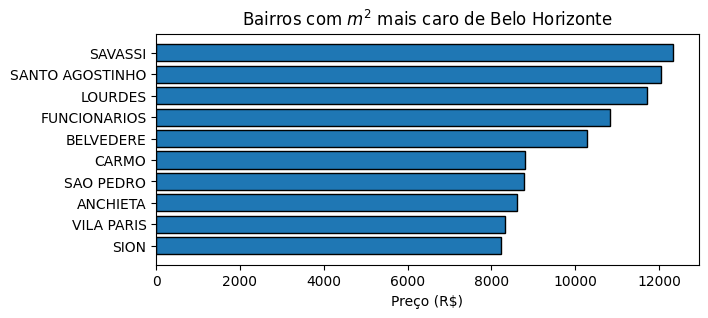

In [157]:
plt.figure(figsize=(7, 3))
plt.barh(preco_m2_bairro[-10:].index, preco_m2_bairro[-10:].values.reshape(-1), edgecolor='black')
plt.title("Bairros com $m^2$ mais caro de Belo Horizonte")
plt.xlabel("Preço (R$)")
plt.ylabel("")
plt.show()

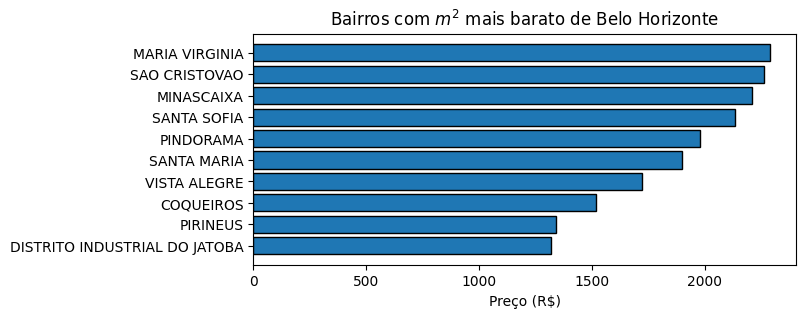

In [158]:
plt.figure(figsize=(7, 3))
plt.barh(preco_m2_bairro[:10].index, preco_m2_bairro[:10].values.reshape(-1), edgecolor='black')
plt.title("Bairros com $m^2$ mais barato de Belo Horizonte")
plt.xlabel("Preço (R$)")
plt.ylabel("")
plt.show()

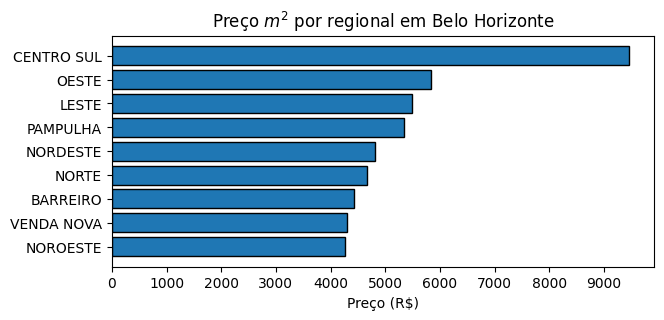

In [159]:
plt.figure(figsize=(7, 3))
plt.barh(preco_m2_regional.index, preco_m2_regional.values.reshape(-1), edgecolor='black')
plt.title("Preço $m^2$ por regional em Belo Horizonte")
plt.xlabel("Preço (R$)")
plt.ylabel("")
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.show()

In [160]:
Descritiva1Num1Cat(dados_completos,'Preço','Tipo_Imovel').sort_values(by='Média', ascending=False)

Variável  Freq. Absoluta        Média  Desvio Padrão  \
2                Hotel             1.0  11790000.00            NaN   
1  Estacionamento/Lote             4.0   3935660.00     3500232.77   
0                 Casa          1323.0   1182628.03     1217762.57   
3               Prédio          3657.0    981222.24      972290.71   

       Mínimo          Q1  Q2 (Mediana)          Q3      Máximo  
2  11790000.0  11790000.0    11790000.0  11790000.0  11790000.0  
1    752640.0   1455660.0     3245000.0   5725000.0   8500000.0  
0    130000.0    499000.0      835000.0   1422970.0  11900000.0  
3     95000.0    420000.0      676000.0   1180000.0  11800000.0

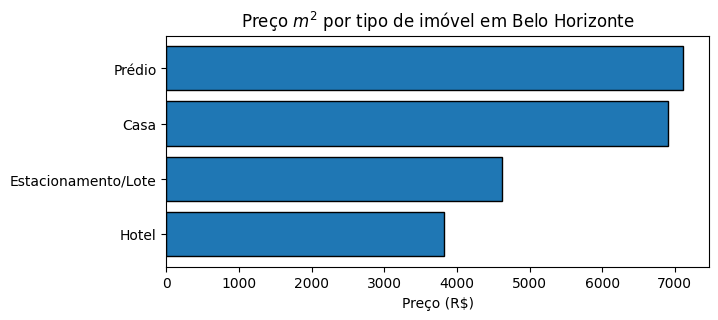

In [161]:
plt.figure(figsize=(7, 3))
plt.barh(preco_m2_tipo_imovel.index, preco_m2_tipo_imovel.values.reshape(-1), edgecolor='black')
plt.title("Preço $m^2$ por tipo de imóvel em Belo Horizonte")
plt.xlabel("Preço (R$)")
plt.ylabel("")
plt.show()

In [162]:
preco_bairro1 = preco_bairro.reset_index()
preco_m2_bairro1 = preco_m2_bairro.reset_index()
BAIRRO_POPULAR1 = BAIRRO_POPULAR.copy()
BAIRRO_POPULAR1['NOME'] = BAIRRO_POPULAR1['NOME'].str.upper().apply(unidecode).str.replace("-"," ").str.strip()
preco_bairro2 = pd.merge(preco_bairro1, BAIRRO_POPULAR1, left_on=['Bairro'], 
                         right_on=['NOME'], how='left').drop(columns=['Bairro','AREA_KM2','PERIMETR_M'],axis=1)
preco_m2_bairro2 = pd.merge(preco_m2_bairro1, BAIRRO_POPULAR1, left_on=['Bairro'], 
                            right_on=['NOME'], how='left').drop(columns=['Bairro','AREA_KM2','PERIMETR_M'],axis=1)
preco_bairro3 = gpd.GeoDataFrame(preco_bairro2, geometry='geometry')
preco_m2_bairro3 = gpd.GeoDataFrame(preco_m2_bairro2, geometry='geometry')

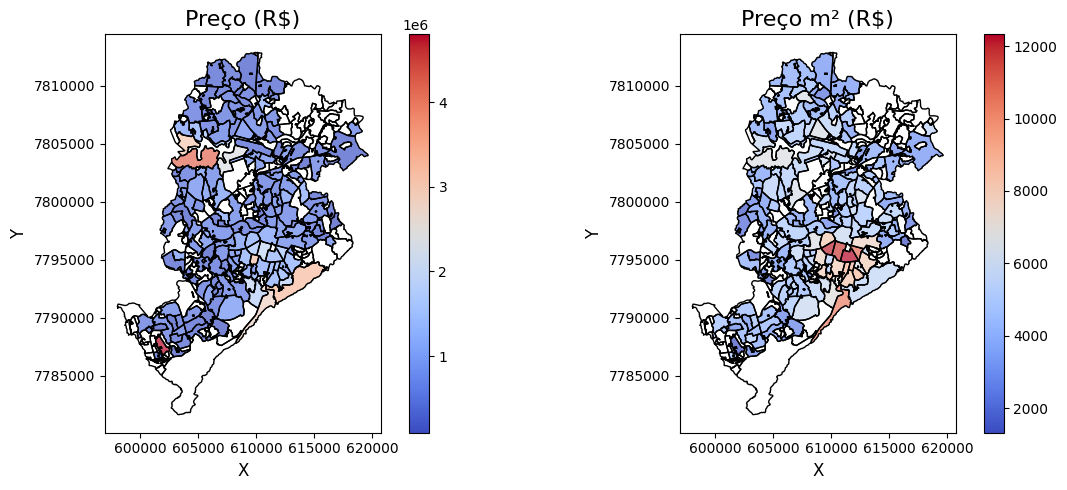

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
BAIRRO_POPULAR.boundary.plot(ax=axes[0], color="black", linewidth=1)
preco_bairro3.plot(ax=axes[0], column='Preço', cmap='coolwarm', legend=True, linewidth=0.5, edgecolor='black', alpha=0.7)
axes[0].set_title('Preço (R$)', fontsize=16)
axes[0].set_xlabel('X', fontsize=12)
axes[0].set_ylabel('Y', fontsize=12)
axes[0].ticklabel_format(style='plain', axis='y')

BAIRRO_POPULAR.boundary.plot(ax=axes[1], color="black", linewidth=1)
preco_m2_bairro3.plot(ax=axes[1], column='Preço_m2', cmap='coolwarm', legend=True, linewidth=0.5, edgecolor='black', alpha=0.7)
axes[1].set_title('Preço m² (R$)', fontsize=16)
axes[1].set_xlabel('X', fontsize=12)
axes[1].set_ylabel('Y', fontsize=12)
axes[1].ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

#### Taxas administrativas, quartos, garagens e tipo de imóvel

In [164]:
Descritiva1Num1Cat(dados_completos,'Taxas adm','Bairro').dropna().sort_values(by='Média', ascending=False).head()

Variável  Freq. Absoluta    Média  Desvio Padrão  Mínimo       Q1  \
11         BELVEDERE            96.0  2305.54        1455.76     1.0  1172.50   
91       MANGABEIRAS             2.0  1550.00          70.71  1500.0  1525.00   
33     CIDADE JARDIM             2.0  1440.00         509.12  1080.0  1260.00   
87           LOURDES           270.0  1431.72        1108.36     1.0   633.75   
131  SANTO AGOSTINHO           133.0  1209.57         843.05     1.0   660.00   

     Q2 (Mediana)      Q3  Máximo  
11         2284.0  3100.0  7000.0  
91         1550.0  1575.0  1600.0  
33         1440.0  1620.0  1800.0  
87         1250.0  2000.0  6082.0  
131        1300.0  1680.0  3600.0

In [165]:
Descritiva1Num1Cat(dados_completos,'Taxa_m2','Bairro').dropna().sort_values(by='Média', ascending=False).head()

Variável  Freq. Absoluta  Média  Desvio Padrão  Mínimo    Q1  \
11    BELVEDERE            96.0  11.18           4.07    0.00  9.69   
88   LUXEMBURGO            61.0   8.48           3.95    2.38  5.00   
148    SILVEIRA             7.0   8.38           7.95    3.66  4.62   
87      LOURDES           270.0   8.37           5.16    0.00  5.93   
108    PAMPULHA            10.0   8.30          10.15    3.33  4.36   

     Q2 (Mediana)     Q3  Máximo  
11          12.00  14.01   18.38  
88           8.49  11.43   23.31  
148          4.78   7.48   26.00  
87           8.50  10.91   53.57  
108          4.96   6.62   36.96

In [166]:
dados_completos['Taxa_m2'] = dados_completos["Taxas adm"] / dados_completos["Área do imóvel"]

In [167]:
taxa_m2_bairro = dados_completos.groupby("Bairro").agg({"Taxa_m2": "mean"}).dropna().sort_values(by="Taxa_m2")
taxa_m2_regional = dados_completos.groupby("REGIONAL").agg({"Taxa_m2": "mean"}).sort_values(by="Taxa_m2")
taxa_m2_tipo_imovel = dados_completos.groupby("Tipo_Imovel").agg({"Taxa_m2": "mean"}).sort_values(by="Taxa_m2")

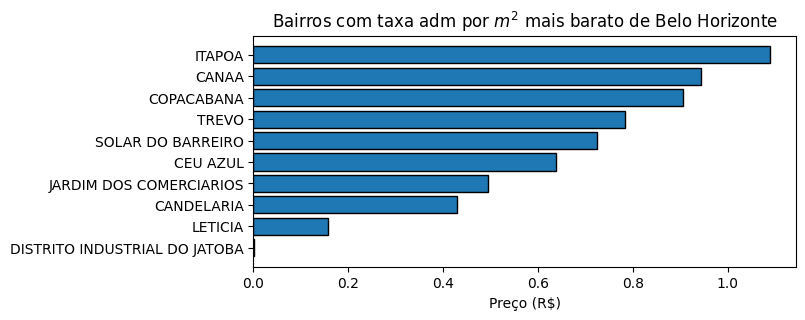

In [168]:
plt.figure(figsize=(7, 3))
plt.barh(taxa_m2_bairro[:10].index, taxa_m2_bairro[:10].values.reshape(-1), edgecolor='black')
plt.title("Bairros com taxa adm por $m^2$ mais barato de Belo Horizonte")
plt.xlabel("Preço (R$)")
plt.ylabel("")
plt.show()

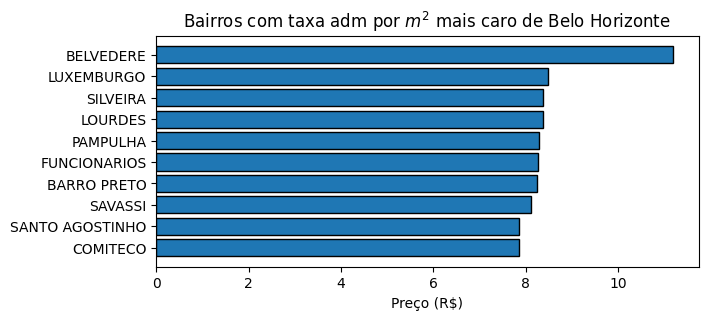

In [169]:
plt.figure(figsize=(7, 3))
plt.barh(taxa_m2_bairro[-10:].index, taxa_m2_bairro[-10:].values.reshape(-1), edgecolor='black')
plt.title("Bairros com taxa adm por $m^2$ mais caro de Belo Horizonte")
plt.xlabel("Preço (R$)")
plt.ylabel("")
plt.show()

In [170]:
Descritiva1Num1Cat(dados_completos,'Preço','Quartos')

Variável  Freq. Absoluta        Média  Desvio Padrão      Mínimo  \
0          1           139.0    655293.75      804926.32     95000.0   
1          2          1106.0    514793.70      330620.21    110000.0   
2          3          2047.0    702685.93      459152.99    130000.0   
3          4          1493.0   1735157.72     1225424.18    249000.0   
4          5           140.0   2176207.14     1875462.24    395000.0   
5          6            37.0   3491594.59     3412625.40    495000.0   
6          7             8.0   2048500.00     1490286.93    850000.0   
7          8             5.0   1588000.00      647472.01    950000.0   
8          9             3.0   1396666.67      438786.20    890000.0   
9         10             1.0    897000.00            NaN    897000.0   
10        12             1.0   3200000.00            NaN   3200000.0   
11        13             1.0   4200000.00            NaN   4200000.0   
12        15             1.0   2290000.00            NaN   2290000.0   
13        16             1.0   3600000.00            NaN   3600000.0   
14        18             1.0   2690000.00            NaN   2690000.0   
15        50             1.0  11790000.00            NaN  11790000.0   

            Q1  Q2 (Mediana)          Q3      Máximo  
0     391500.0      495000.0    704478.0   8500000.0  
1     260000.0      405335.0    690000.0   3190000.0  
2     420000.0      580000.0    849000.0   5000000.0  
3     890000.0     1450000.0   2198000.0   9500000.0  
4     957500.0     1570000.0   2700000.0  11000000.0  
5    1200000.0     2000000.0   3500000.0  11900000.0  
6     937000.0     1400000.0   2735000.0   4950000.0  
7    1150000.0     1300000.0   2090000.0   2450000.0  
8    1270000.0     1650000.0   1650000.0   1650000.0  
9     897000.0      897000.0    897000.0    897000.0  
10   3200000.0     3200000.0   3200000.0   3200000.0  
11   4200000.0     4200000.0   4200000.0   4200000.0  
12   2290000.0     2290000.0   2290000.0   2290000.0  
13   3600000.0     3600000.0   3600000.0   3600000.0  
14   2690000.0     2690000.0   2690000.0   2690000.0  
15  11790000.0    11790000.0  11790000.0  11790000.0

In [171]:
Descritiva1Num1Cat(dados_completos,'Preço','Garagem')

Variável  Freq. Absoluta       Média  Desvio Padrão     Mínimo         Q1  \
0          1          1325.0   408772.04      243401.29    95000.0   255000.0   
1          2          2123.0   778858.72      389587.50   155000.0   495000.0   
2          3           769.0  1396490.22      672944.92   310000.0   860000.0   
3          4           532.0  2168412.49     1266040.99   379000.0  1250000.0   
4          5            98.0  2770042.55     1835081.18   329000.0  1382500.0   
5          6            73.0  3304616.44     2638397.77   450000.0  1200000.0   
6          7            13.0  3224538.38     2779218.09   700000.0  1600000.0   
7          8            22.0  2748181.82     1780250.48   360000.0  1347500.0   
8          9             1.0  2000000.00            NaN  2000000.0  2000000.0   
9         10            19.0  4857631.58     3883575.95   650000.0  2285000.0   
10        12             1.0  5900000.00            NaN  5900000.0  5900000.0   
11        13             3.0  4611666.67     2886712.37  2495000.0  2967500.0   
12        15             1.0  1200000.00            NaN  1200000.0  1200000.0   
13        20             2.0  8295000.00     4942676.40  4800000.0  6547500.0   
14        22             1.0   752640.00            NaN   752640.0   752640.0   
15        28             1.0  1690000.00            NaN  1690000.0  1690000.0   
16        50             1.0  8500000.00            NaN  8500000.0  8500000.0   

    Q2 (Mediana)          Q3      Máximo  
0       350000.0    495000.0   4200000.0  
1       690000.0    955000.0   3900000.0  
2      1300000.0   1810473.0   5600000.0  
3      1890000.0   2704437.0   6900000.0  
4      2525000.0   3980000.0   8200000.0  
5      2700000.0   3990000.0  11000000.0  
6      2400000.0   3300000.0   9500000.0  
7      2725000.0   3650000.0   7250000.0  
8      2000000.0   2000000.0   2000000.0  
9      3200000.0   6200000.0  11900000.0  
10     5900000.0   5900000.0   5900000.0  
11     3440000.0   5670000.0   7900000.0  
12     1200000.0   1200000.0   1200000.0  
13     8295000.0  10042500.0  11790000.0  
14      752640.0    752640.0    752640.0  
15     1690000.0   1690000.0   1690000.0  
16     8500000.0   8500000.0   8500000.0

Text(0.5, 1.0, 'Garagem')

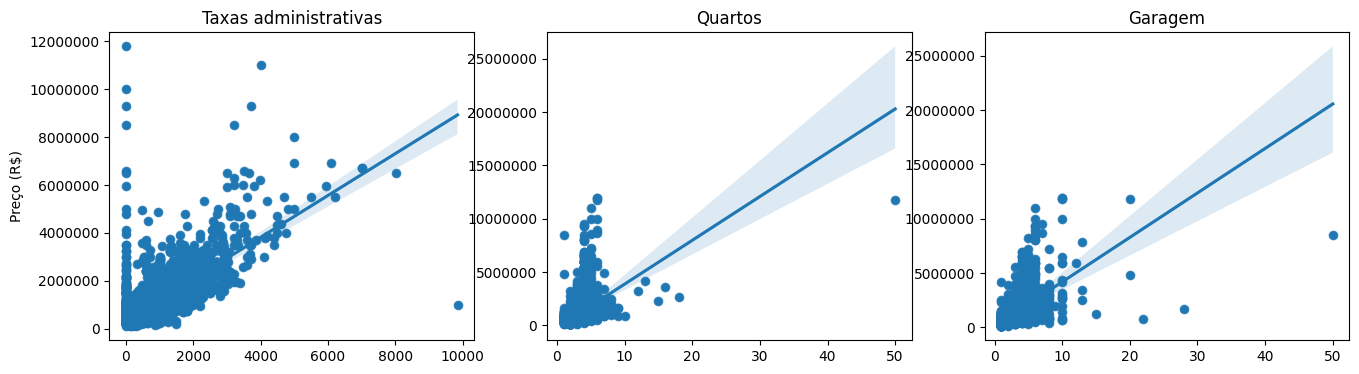

In [172]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (16,4), ncols = 3, sharey = False) 
sns.scatterplot(x = dados_completos['Taxas adm'], y = dados_completos['Preço'],  ax = ax1)
sns.regplot(x = dados_completos['Taxas adm'], y = dados_completos['Preço'], ax = ax1)
ax1.get_yaxis().get_major_formatter().set_scientific(False)
ax1.set_ylabel('Preço (R$)')
ax1.set_xlabel('')
ax1.set_title('Taxas administrativas')

sns.scatterplot(x = dados_completos['Quartos'], y = dados_completos['Preço'], ax = ax2) 
sns.regplot(x = dados_completos['Quartos'], y = dados_completos['Preço'], ax = ax2)
ax2.get_yaxis().get_major_formatter().set_scientific(False)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_title('Quartos')

sns.scatterplot(x = dados_completos['Garagem'], y = dados_completos['Preço'], ax = ax3) 
sns.regplot(x = dados_completos['Garagem'], y = dados_completos['Preço'], ax = ax3)
ax3.get_yaxis().get_major_formatter().set_scientific(False)
ax3.set_ylabel('')
ax3.set_xlabel('')
ax3.set_title('Garagem')

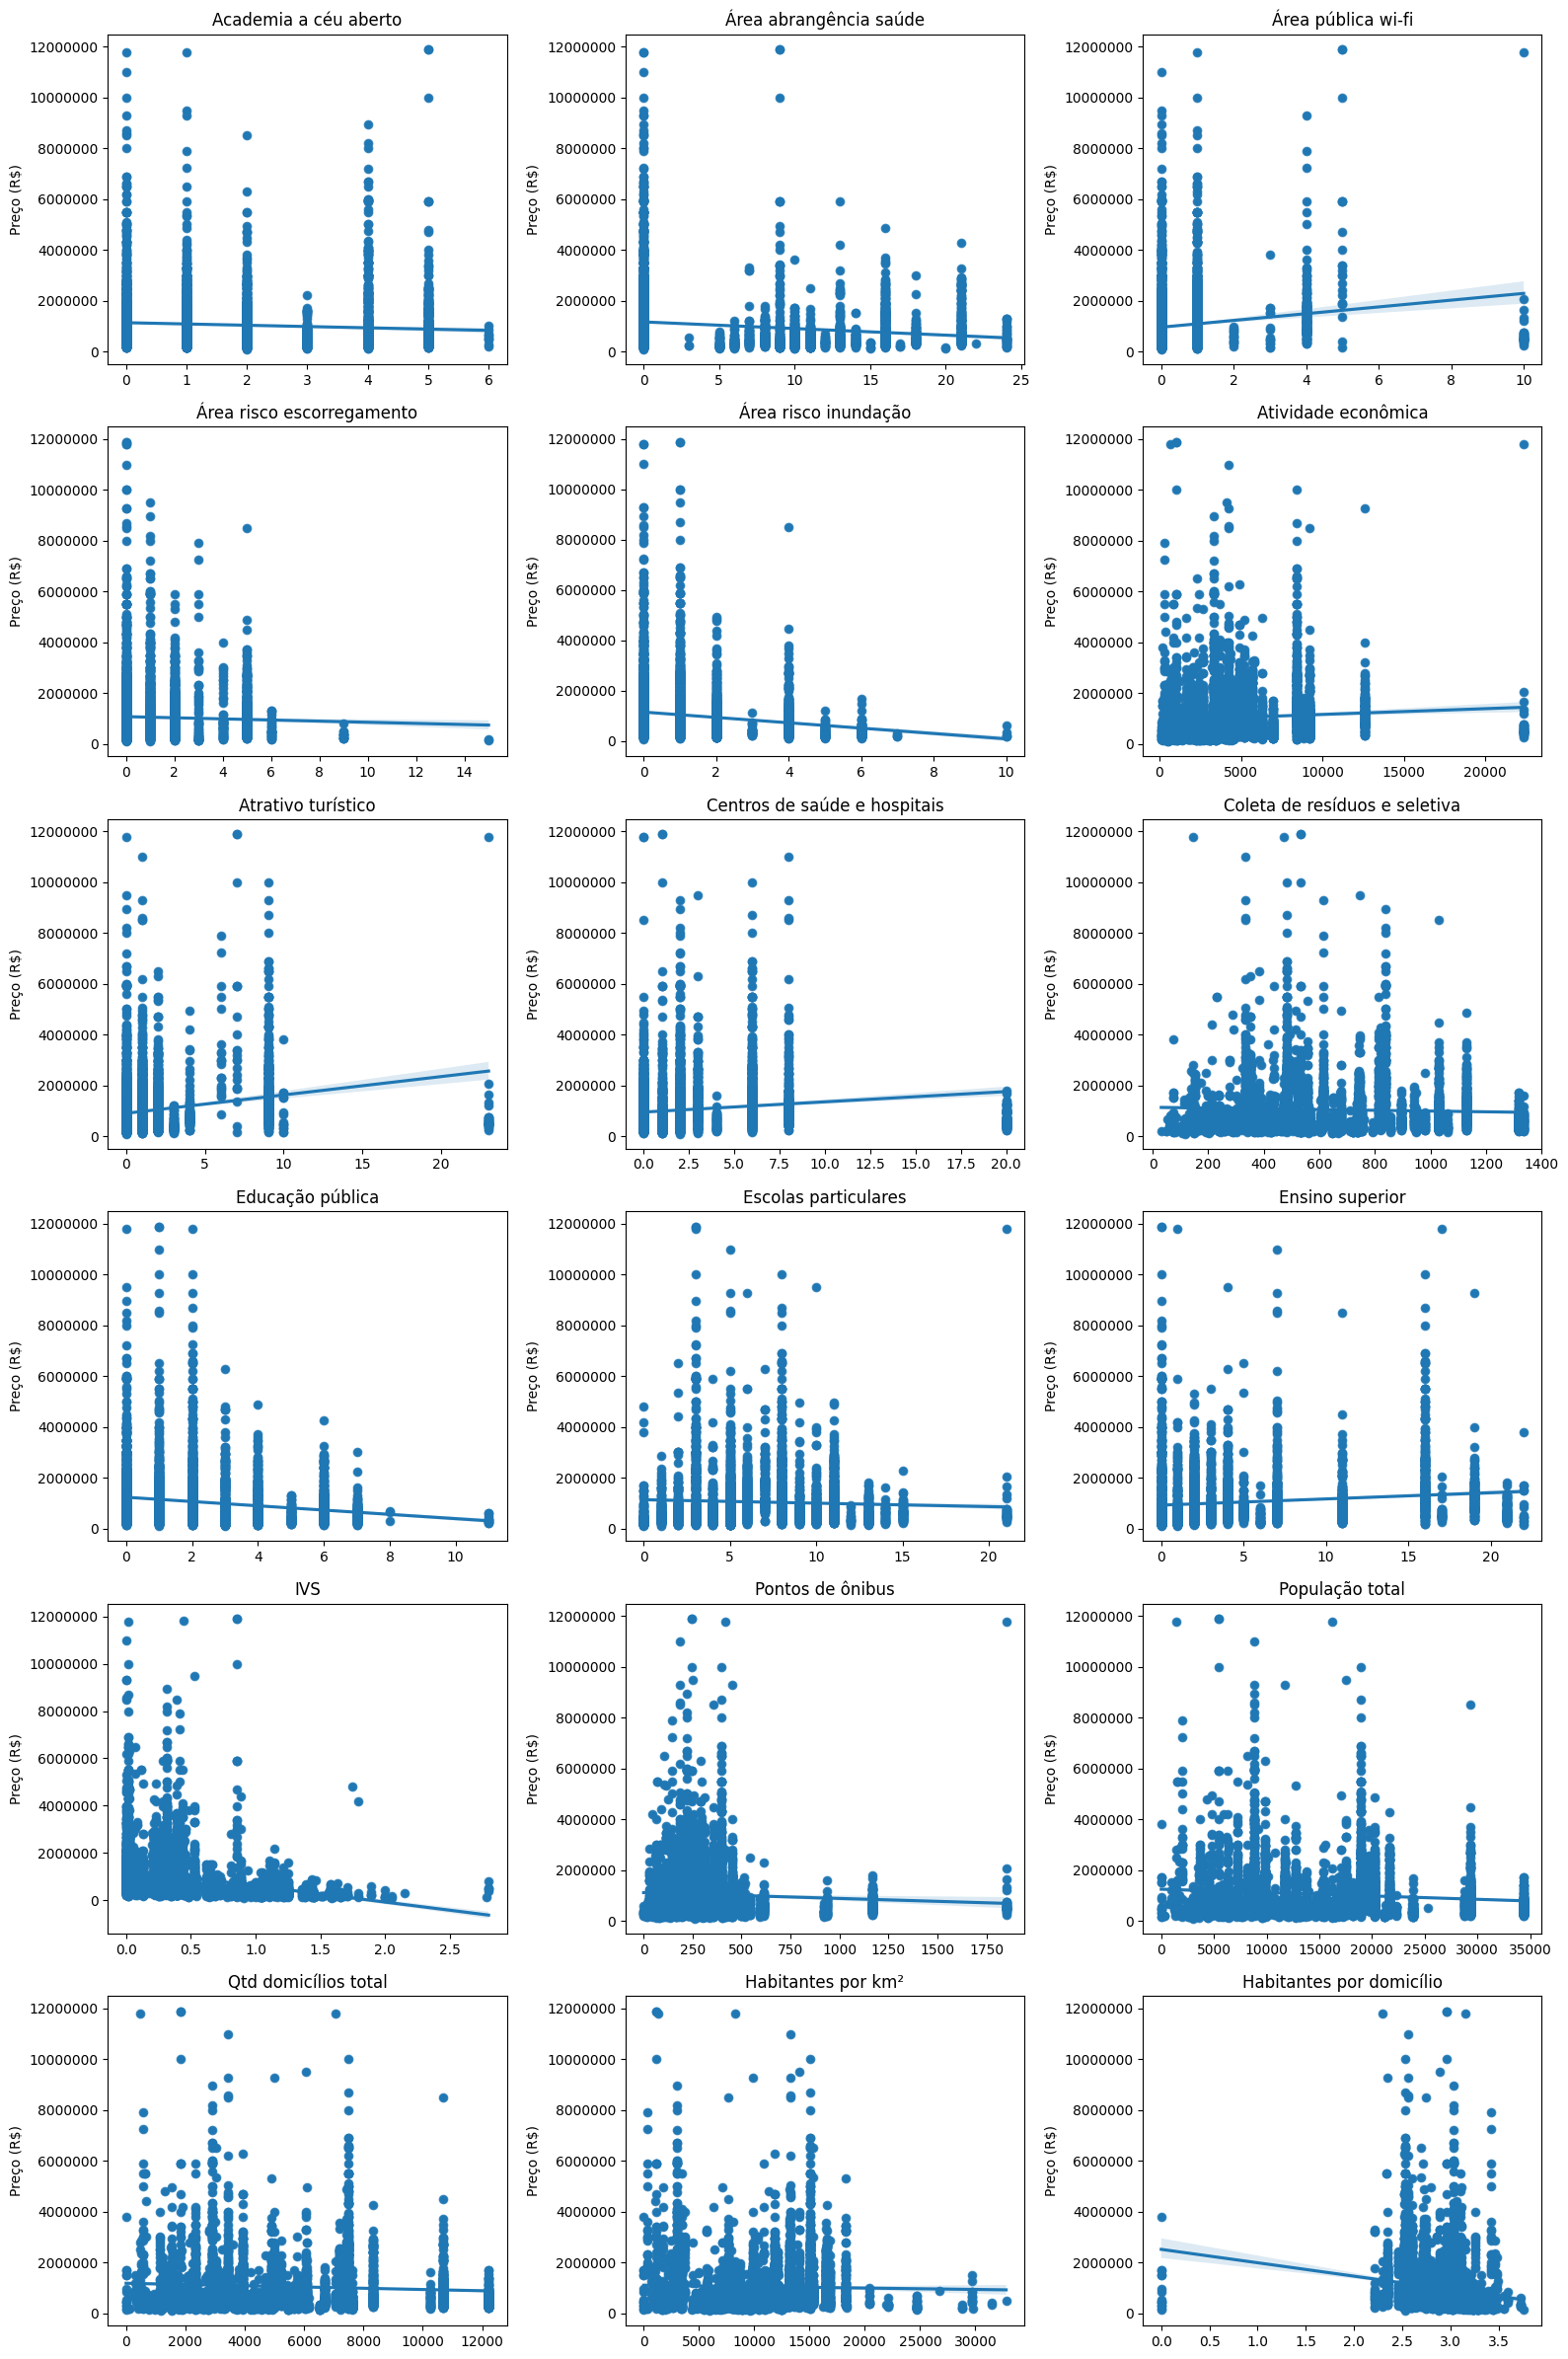

In [173]:
titulos = [['Academia a céu aberto','Área abrangência saúde','Área pública wi-fi'],
           ['Área risco escorregamento','Área risco inundação','Atividade econômica'],
           ['Atrativo turístico','Centros de saúde e hospitais','Coleta de resíduos e seletiva'], 
           ['Educação pública','Escolas particulares','Ensino superior'],
           ['IVS','Pontos de ônibus','População total'],
           ['Qtd domicílios total','Habitantes por km²','Habitantes por domicílio']]
colunas = [['ACADEMIA_CEU_ABERTO','AREA_ABRANGENCIA_SAUDE','AREA_PUBLICA_WIFI'],
           ['AREA_RISCO_ESCORREGAMENTO','AREA_RISCO_INUNDACAO','ATIVIDADE_ECONOMICA'],
           ['ATRATIVO_TURISTICO','CENTRO_SAUDE_HOSPITAL','COLETA'], 
           ['EDUCACAO_PUBLICA','ESCOLAS_PARTICULARES','ENSINO_SUPERIOR'],
           ['IVS','PONTO_ONIBUS','POPULACAO_TOTAL'],
           ['DOMICILIO_TOTAL','HAB_KM2_TOTAL','HAB_DOM_MEDIA']]
fig, axes = plt.subplots(figsize=(16, 24), nrows=6, ncols=3, sharey=False)
for i, ax in enumerate(axes.flat):
    linha = i // 3
    coluna = i % 3
    sns.scatterplot(x=dados_completos[colunas[linha][coluna]], y=dados_completos['Preço'], ax=ax)
    sns.regplot(x=dados_completos[colunas[linha][coluna]], y=dados_completos['Preço'], ax=ax)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_ylabel('Preço (R$)')
    ax.set_xlabel('')
    ax.set_title(titulos[linha][coluna])
plt.tight_layout()
plt.show()

**Resultados dos preços por:**
* Bairros e regionais:
    * Sem verificar o número de imóveis daquele bairro - 5 bairros com imóveis com maiores preços médios: Distrito Industrial do Jatobá, Bandeirantes, Mangabeiras, Cidade Jardim e Braúnas.
    * Retirando os bairros com apenas um imóvel - 5 bairros com imóveis com maiores preços médios: Bandeirantes, Mangabeiras, Cidade Jardim, Braúnas e Belvedere.
    * Sem verificar o número de imóveis daquele bairro - 5 bairros com imóveis com menores preços médios: Teixeira Dias, Bonsucesso, Solar do Barreiro, Granja de Freitas e São Cristovão.
    * Retirando os bairros com apenas um imóvel - 5 bairros com imóveis com menores preços médios: Serra Verde, Gameleira, Frei Leopoldo, Bonsucesso e Solar do Barreiro.
    * Regional Centro-Sul tem maior preço médio e preço/m², ao passo que Venda Nova tem menor preço médio.
    * Savassi, Santo Agostinho e Lourdes os 3 bairros com m² mais caro.
    * Coqueiros, Pirineus e Distrito Industrial do Jatobá são os 3 bairros com m² mais barato.
* Taxas administrativas, quartos, garagens e tipo de imóvel
    * Belvedere é o bairro com taxa administrativa média mais cara, assim como por m².
    * Um imóvel com:
        * 2 quartos custa em média aproximadamente R$\$$515.000,00;
        * 3 quartos custa em média aproximadamente R$\$$703.000,00;
        * 4 quartos custa em média aproximadamente R$\$$1.735.000,00.
    * Se um imóvel tiver:
        * 1 garagem, o valor médio é R$\$$409.000,00;
        * 2 garagem, o valor médio é R$\$$779.000,00.
    * Prédio tem m² mais caro que casa.

**ACADEMIA CEU ABERTO, AREA ABRANGENCIA SAUDE, AREA PUBLICA WIFI, AREA RISCO ESCORREGAMENTO, AREA RISCO INUNDACAO, ATIVIDADE ECONOMICA, ATRATIVO TURISTICO, CENTRO SAUDE HOSPITAL, COLETA, EDUCACAO PUBLICA, ESCOLAS PARTICULARES, ENSINO SUPERIOR, IVS, TEM ESTACAO METRO, PONTO ONIBUS, POPULACAO TOTAL, DOMICILIO TOTAL, HAB KM2 TOTAL e HAB DOM MEDIA**

**ACADEMIA_CEU_ABERTO, AREA_ABRANGENCIA_SAUDE, AREA_PUBLICA_WIFI, AREA_RISCO_ESCORREGAMENTO, AREA_RISCO_INUNDACAO, ATIVIDADE_ECONOMICA, ATRATIVO_TURISTICO, CENTRO_SAUDE_HOSPITAL, COLETA, EDUCACAO_PUBLICA, ESCOLAS_PARTICULARES, ENSINO_SUPERIOR, IVS, TEM_ESTACAO_METRO, PONTO_ONIBUS, POPULACAO_TOTAL, DOMICILIO_TOTAL, HAB_KM2_TOTAL e HAB_DOM_MEDIA**

In [174]:
#Distribuição das variáveis
def TesteNormalidade(df,cols):
    frames = []
    for col in cols:
        AndersonDarling = round(statsmodels.stats.diagnostic.normal_ad(df[col], axis=0)[1],5)
        KolmogorovSmirnov = stats.kstest(df[col].dropna(), 'norm').pvalue.round(5)
        JarqueBera = stats.jarque_bera(df[col].dropna()).pvalue.round(5)
        DAgostinoPearson = stats.normaltest(df[col].dropna()).pvalue.round(5)
        Lilliefors = round(lilliefors(df[col].dropna(axis=0, how='any'), dist='norm', pvalmethod='approx')[1],5)
        if len(df[col].dropna()) > 5000:
            ShapiroWilk = 'N > 5000'
        else:
            ShapiroWilk = round(stats.shapiro(df[col].dropna()).pvalue,5)
        frame = pd.DataFrame({'Shapiro-Wilk':[ShapiroWilk], 'Anderson-Darling':[AndersonDarling],
                              'Kolmogorov-Smirnov':[KolmogorovSmirnov], 
                              'Jarque-Bera':[JarqueBera],'DAgostino e Pearson':[DAgostinoPearson],
                              'Lilliefors':[Lilliefors]})
        frames.append(frame)
        frame.insert(0, 'Variáveis', col)
    result = pd.concat(frames)
    result = result.reset_index()
    result = result.drop(result.columns[0], axis=1) 
    return result
TesteNormalidade(dados_completos,['Preço','Taxas adm','Garagem','Quartos','Área do imóvel','ACADEMIA_CEU_ABERTO',
        'AREA_ABRANGENCIA_SAUDE','AREA_PUBLICA_WIFI','AREA_RISCO_ESCORREGAMENTO','AREA_RISCO_INUNDACAO','ATIVIDADE_ECONOMICA',
        'ATRATIVO_TURISTICO','CENTRO_SAUDE_HOSPITAL','COLETA','EDUCACAO_PUBLICA','ESCOLAS_PARTICULARES','ENSINO_SUPERIOR',
        'IVS','PONTO_ONIBUS','POPULACAO_TOTAL','DOMICILIO_TOTAL','HAB_KM2_TOTAL','HAB_DOM_MEDIA'])

Variáveis  Shapiro-Wilk  Anderson-Darling  \
0                       Preço           0.0               0.0   
1                   Taxas adm           0.0               0.0   
2                     Garagem           0.0               0.0   
3                     Quartos           0.0               0.0   
4              Área do imóvel           0.0               0.0   
5         ACADEMIA_CEU_ABERTO           0.0               0.0   
6      AREA_ABRANGENCIA_SAUDE           0.0               0.0   
7           AREA_PUBLICA_WIFI           0.0               0.0   
8   AREA_RISCO_ESCORREGAMENTO           0.0               0.0   
9        AREA_RISCO_INUNDACAO           0.0               0.0   
10        ATIVIDADE_ECONOMICA           0.0               0.0   
11         ATRATIVO_TURISTICO           0.0               0.0   
12      CENTRO_SAUDE_HOSPITAL           0.0               0.0   
13                     COLETA           0.0               0.0   
14           EDUCACAO_PUBLICA           0.0               0.0   
15       ESCOLAS_PARTICULARES           0.0               0.0   
16            ENSINO_SUPERIOR           0.0               0.0   
17                        IVS           0.0               0.0   
18               PONTO_ONIBUS           0.0               0.0   
19            POPULACAO_TOTAL           0.0               0.0   
20            DOMICILIO_TOTAL           0.0               0.0   
21              HAB_KM2_TOTAL           0.0               0.0   
22              HAB_DOM_MEDIA           0.0               0.0   

    Kolmogorov-Smirnov  Jarque-Bera  DAgostino e Pearson  Lilliefors  
0                  0.0          0.0                  0.0         0.0  
1                  0.0          0.0                  0.0         0.0  
2                  0.0          0.0                  0.0         0.0  
3                  0.0          0.0                  0.0         0.0  
4                  0.0          0.0                  0.0         0.0  
5                  0.0          0.0                  0.0         0.0  
6                  0.0          0.0                  0.0         0.0  
7                  0.0          0.0                  0.0         0.0  
8                  0.0          0.0                  0.0         0.0  
9                  0.0          0.0                  0.0         0.0  
10                 0.0          0.0                  0.0         0.0  
11                 0.0          0.0                  0.0         0.0  
12                 0.0          0.0                  0.0         0.0  
13                 0.0          0.0                  0.0         0.0  
14                 0.0          0.0                  0.0         0.0  
15                 0.0          0.0                  0.0         0.0  
16                 0.0          0.0                  0.0         0.0  
17                 0.0          0.0                  0.0         0.0  
18                 0.0          0.0                  0.0         0.0  
19                 0.0          0.0                  0.0         0.0  
20                 0.0          0.0                  0.0         0.0  
21                 0.0          0.0                  0.0         0.0  
22                 0.0          0.0                  0.0         0.0

Valores-p dos testes de normalidade são próximos de 0, portanto as não seguem distribuição normal.

In [175]:
dados_corr = dados_completos[['Preço','Taxas adm','Garagem','Quartos','Área do imóvel','ACADEMIA_CEU_ABERTO',
        'AREA_ABRANGENCIA_SAUDE','AREA_PUBLICA_WIFI','AREA_RISCO_ESCORREGAMENTO','AREA_RISCO_INUNDACAO','ATIVIDADE_ECONOMICA',
        'ATRATIVO_TURISTICO','CENTRO_SAUDE_HOSPITAL','COLETA','EDUCACAO_PUBLICA','ESCOLAS_PARTICULARES','ENSINO_SUPERIOR',
        'IVS','PONTO_ONIBUS','POPULACAO_TOTAL','DOMICILIO_TOTAL','HAB_KM2_TOTAL','HAB_DOM_MEDIA']].corr(method='spearman')
dados_corr.round(2)

Preço  Taxas adm  Garagem  Quartos  Área do imóvel  \
Preço                       1.00       0.68     0.74     0.62            0.73   
Taxas adm                   0.68       1.00     0.49     0.50            0.55   
Garagem                     0.74       0.49     1.00     0.59            0.68   
Quartos                     0.62       0.50     0.59     1.00            0.76   
Área do imóvel              0.73       0.55     0.68     0.76            1.00   
ACADEMIA_CEU_ABERTO        -0.16      -0.19     0.02     0.02            0.00   
AREA_ABRANGENCIA_SAUDE     -0.27      -0.28    -0.13    -0.10           -0.11   
AREA_PUBLICA_WIFI           0.24       0.24     0.10     0.05            0.07   
AREA_RISCO_ESCORREGAMENTO   0.03       0.13     0.09     0.10            0.08   
AREA_RISCO_INUNDACAO       -0.19      -0.14    -0.01    -0.07           -0.09   
ATIVIDADE_ECONOMICA         0.19       0.21     0.05     0.01            0.01   
ATRATIVO_TURISTICO          0.28       0.22     0.07     0.05            0.07   
CENTRO_SAUDE_HOSPITAL       0.25       0.22     0.02    -0.02            0.01   
COLETA                      0.01       0.02     0.07     0.06            0.05   
EDUCACAO_PUBLICA           -0.19      -0.25    -0.15    -0.14           -0.13   
ESCOLAS_PARTICULARES        0.03      -0.01     0.01     0.01            0.00   
ENSINO_SUPERIOR             0.28       0.30     0.06     0.04            0.05   
IVS                        -0.41      -0.36    -0.07    -0.10           -0.12   
PONTO_ONIBUS               -0.01      -0.04    -0.02    -0.08           -0.06   
POPULACAO_TOTAL            -0.04       0.01    -0.01     0.00           -0.02   
DOMICILIO_TOTAL             0.02       0.07     0.00     0.01           -0.01   
HAB_KM2_TOTAL               0.15       0.22    -0.06     0.03            0.02   
HAB_DOM_MEDIA              -0.37      -0.42    -0.03    -0.05           -0.05   

                           ACADEMIA_CEU_ABERTO  AREA_ABRANGENCIA_SAUDE  \
Preço                                    -0.16                   -0.27   
Taxas adm                                -0.19                   -0.28   
Garagem                                   0.02                   -0.13   
Quartos                                   0.02                   -0.10   
Área do imóvel                            0.00                   -0.11   
ACADEMIA_CEU_ABERTO                       1.00                    0.08   
AREA_ABRANGENCIA_SAUDE                    0.08                    1.00   
AREA_PUBLICA_WIFI                        -0.01                    0.01   
AREA_RISCO_ESCORREGAMENTO                 0.24                    0.13   
AREA_RISCO_INUNDACAO                      0.06                    0.21   
ATIVIDADE_ECONOMICA                       0.07                   -0.07   
ATRATIVO_TURISTICO                       -0.09                   -0.34   
CENTRO_SAUDE_HOSPITAL                    -0.39                    0.32   
COLETA                                    0.45                    0.25   
EDUCACAO_PUBLICA                          0.10                    0.67   
ESCOLAS_PARTICULARES                      0.09                    0.24   
ENSINO_SUPERIOR                          -0.24                   -0.37   
IVS                                       0.38                    0.31   
PONTO_ONIBUS                              0.14                    0.00   
POPULACAO_TOTAL                           0.31                    0.22   
DOMICILIO_TOTAL                           0.22                    0.17   
HAB_KM2_TOTAL                            -0.23                    0.07   
HAB_DOM_MEDIA                             0.42                    0.20   

                           AREA_PUBLICA_WIFI  AREA_RISCO_ESCORREGAMENTO  \
Preço                                   0.24                       0.03   
Taxas adm                               0.24                       0.13   
Garagem                                 0.10                       0.09   
Quart

In [176]:
valor_corte = 0.6
correlacoes_filtradas = dados_corr[(dados_corr > valor_corte)]
correlacoes_filtradas = correlacoes_filtradas.where(np.triu(np.ones(correlacoes_filtradas.shape), k=1).astype(bool))
correlacoes_lista = []
linhas, colunas = np.where(correlacoes_filtradas.notna())
for i, j in zip(linhas, colunas):
    variavel1 = dados_corr.columns[i]
    variavel2 = dados_corr.columns[j]
    correlacao = correlacoes_filtradas.iloc[i, j]
    correlacoes_lista.append((variavel1, variavel2, correlacao))
resultado = pd.DataFrame(correlacoes_lista, columns=['Variável 1', 'Variável 2', 'Correlação'])
resultado = resultado.sort_values(by='Correlação', ascending=False)
resultado_filtrado = resultado[~resultado['Variável 1'].str.contains("Preço") & ~resultado['Variável 2'].str.contains("Preço")]
resultado_filtrado

Variável 1            Variável 2  Correlação
19         POPULACAO_TOTAL       DOMICILIO_TOTAL    0.985846
12     ATIVIDADE_ECONOMICA       DOMICILIO_TOTAL    0.833480
14                  COLETA       POPULACAO_TOTAL    0.804532
18                     IVS         HAB_DOM_MEDIA    0.767179
11     ATIVIDADE_ECONOMICA       POPULACAO_TOTAL    0.767033
15                  COLETA       DOMICILIO_TOTAL    0.765775
5                  Quartos        Área do imóvel    0.757912
17    ESCOLAS_PARTICULARES       DOMICILIO_TOTAL    0.728698
16    ESCOLAS_PARTICULARES       POPULACAO_TOTAL    0.715852
9      ATIVIDADE_ECONOMICA       ENSINO_SUPERIOR    0.706309
4                  Garagem        Área do imóvel    0.684400
8      ATIVIDADE_ECONOMICA  ESCOLAS_PARTICULARES    0.676466
10     ATIVIDADE_ECONOMICA          PONTO_ONIBUS    0.676457
6   AREA_ABRANGENCIA_SAUDE      EDUCACAO_PUBLICA    0.669201
7      ATIVIDADE_ECONOMICA                COLETA    0.644027
13                  COLETA  ESCOLAS_PARTICULARES    0.616250

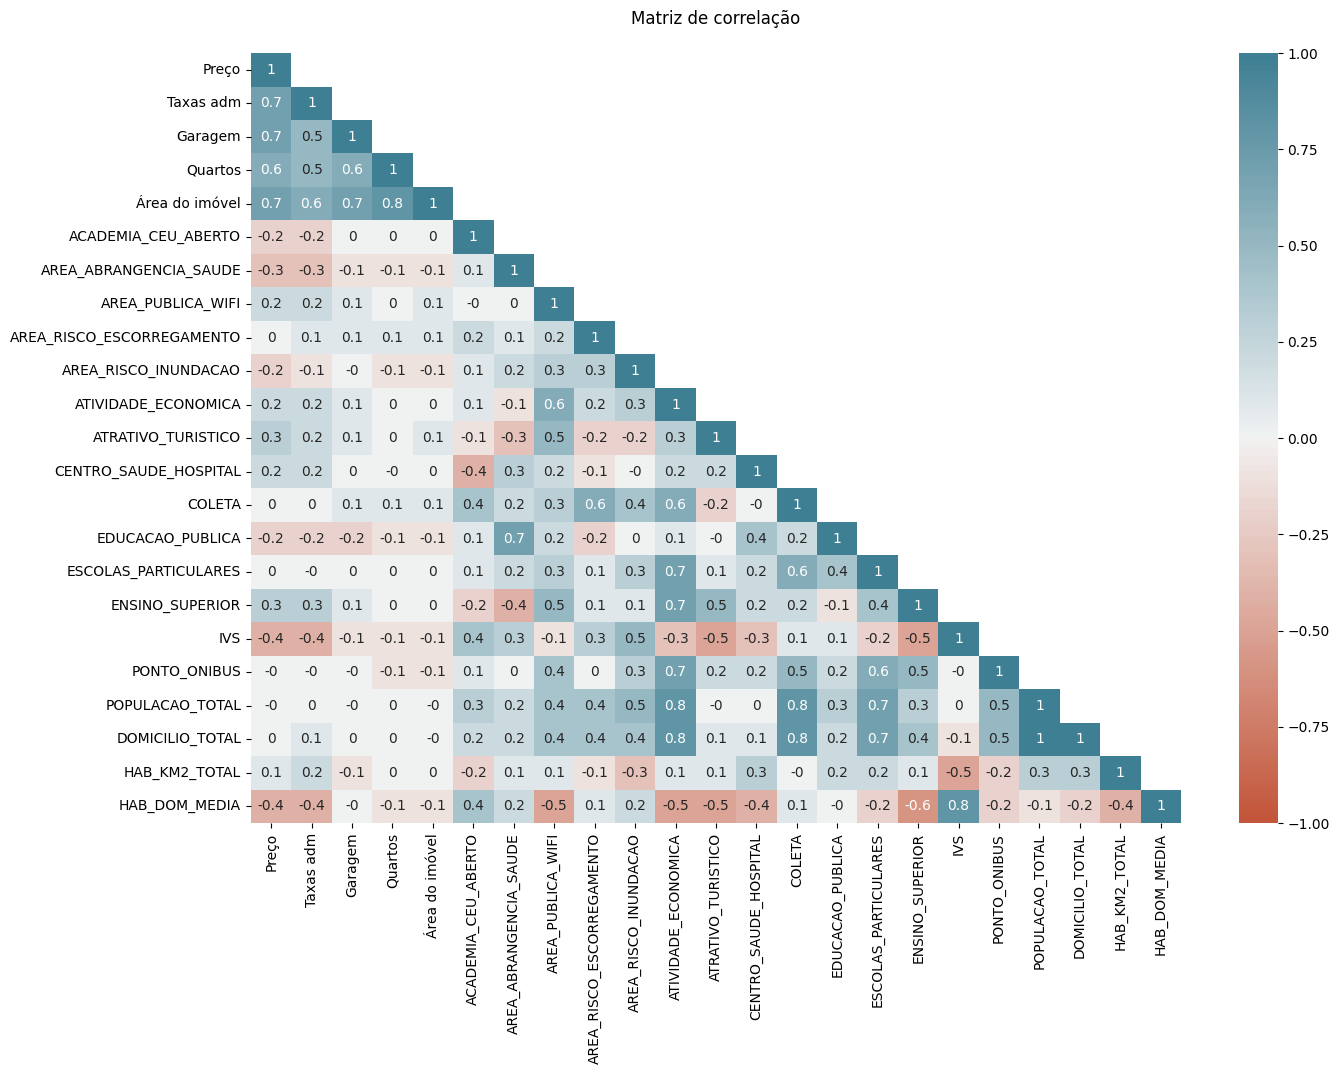

In [177]:
mask = np.triu(np.ones(dados_corr.shape), k=1).astype(bool)
plt.figure(figsize=(15, 10))
ax = sns.heatmap(dados_corr.round(1), annot = True, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), 
                 square = False, mask = mask)
ax.set(xlabel='', ylabel='', title = "Matriz de correlação\n")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)#, horizontalalignment='right')
plt.show()

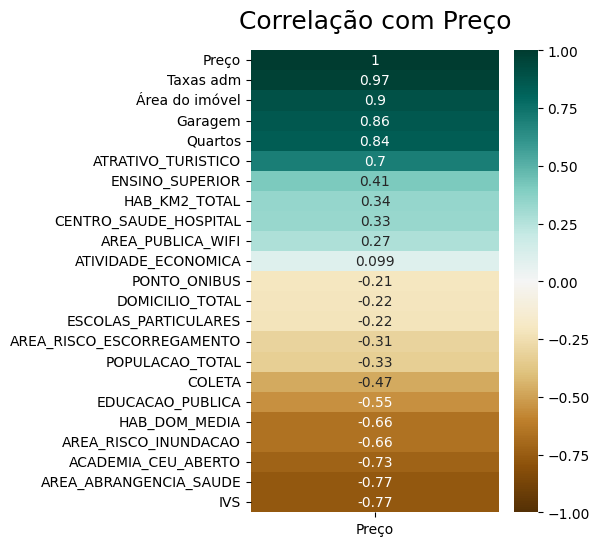

In [178]:
plt.figure(figsize=(4, 6))
heatmap = sns.heatmap(dados_corr.corr(method = 'spearman')[['Preço']].sort_values(by='Preço', ascending=False), vmin=-1, 
                      vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlação com Preço', fontdict={'fontsize':18}, pad=16);

**Correlações maiores que |0.6| com o preço**

Atrativos turísticos, média de habitantes por domicílio, áreas riscos inundação, academias a céu aberto, áreas abrangência saúde e IVS.

**Correlação positivas com o preço**

Taxas administrativas, área do imóvel, garagens, quartos, atrativos turísticos, ensino superior, habitantes por km², centros de saúde e hospital, áreas públicas com wi-fi e atividades econômicas.

**Correlação negativas com o preço**

Pontos de ônibus, quantidade de domicílios total, escolas particulares, áreas riscos escorregamentos, população total, coleta de resíduos, educação pública, habitantes por domicílio, área risco inundação, academias a céu aberto, área abrangência saúde e IVS.

# Predição do preço de imóveis

Avaliação dos modelos:
* R² (coeficiente de determinação): representa o percentual da variância dos dados que é explicado pelo modelo.
* R² ajustado (coeficiente de determinação ajustado): representa o percentual da variância dos dados que é explicado pelo modelo, assim como o R², mas reduz o valor caso uma variável explicativa não contribua significativamente para o modelo.
* MAPE (Erro Percentual Absoluto Médio — do inglês Mean Absolute Percentual Error): mostra o percentual de erro em relação aos valores reais.
* MAE (Erro Médio Absoluto — do inglês Mean Absoluto Error): mede a média da diferença entre o valor real com o predito. Mas por haver valores positivos e negativos, é adicionado um módulo entre a diferença dos valores. Esta métrica não é afetada por valores discrepantes.
* MSE (Erro Quadrático Médio — do inglês Mean Squared Error): é uma métrica que calcula a média de diferença entre o valor predito com o real, elevando a diferença ao quadrado. Atribui maior peso aos maiores erros.
* RMSE (Raiz do Erro Quadrático Médio — do inglês, Root Mean Squared Error): calcula raiz quadrática dos erros entre valores observados e predições. Penaliza erros extremos mais do que erros pequenos, tornando-o sensível a valores extremos.
* RMSLE (raiz do erro quadrático e logarítmico - do inglês Root Mean Squared Logarithmic Error): similar ao RMSE, mas sem penalizar erros que ocorram em magnitudes distintas.

Fonte: https://mariofilho.com/rmse-raiz-do-erro-quadratico-medio-em-machine-learning/

https://medium.com/turing-talks/como-avaliar-seu-modelo-de-regress%C3%A3o-c2c8d73dab96

In [179]:
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error

In [180]:
def AvaliaçãoModelosRegressão(y_pred, y_test, X_train=None):
    if X_train is None:
        R2 = np.nan
        adj_r2 = np.nan
    else:
        R2 = r2_score(y_test,y_pred)
        adj_r2 = (1 - ((1 - r2_score(y_test, y_pred)) * (len(y_test) - 1)) / (len(y_test) - X_train.shape[1] - 1))
    MSE = mean_squared_error(y_test,y_pred)
    RMSE = mean_squared_error(y_test,y_pred,squared=False)
    MAE = mean_absolute_error(y_test,y_pred)
    MAPE = mean_absolute_percentage_error(y_test,y_pred)
    RMSLE = mean_squared_log_error(y_test,y_pred)
    metrics_df = pd.DataFrame({'R2': [R2], 'Adjusted R2': [adj_r2], 'MAE': [MAE], 'MAPE': [MAPE],
                               'MSE': [MSE], 'RMSE': [RMSE], 'RMSLE': [RMSLE]})
    return metrics_df

In [181]:
from sklearn.preprocessing import OneHotEncoder

In [182]:
#Transformando as variáveis categóricas em numéricas
variaveis = ['REGIONAL','Tipo_Imovel','TEM_ESTACAO_METRO']
dataset_encoder = []
for var in variaveis:
    encoder = OneHotEncoder(handle_unknown='ignore')
    cats = encoder.fit(dados_completos[[var]]).categories_[0].tolist()
    nome = var+'_'
    columns = [nome+i.replace('-','_') for i in cats]
    encoder_df = pd.DataFrame(encoder.fit_transform(dados_completos[[var]]).toarray(), columns = columns)
    if len(dataset_encoder) > 0 :
        dataset_encoder = dataset_encoder.join(encoder_df)
    else:
        dataset_encoder = encoder_df
        
dados_completos1 = dados_completos.copy()
dados_completos1 = dados_completos1.reset_index().drop(columns = 'index').join(dataset_encoder)

In [183]:
dados_completos1

Endereço  Taxas adm  Garagem      Preço  \
0           Avenida Raja Gabaglia, 1583      470.0        1   330000.0   
1               Rua Marechal Hermes, 81      750.0        4  1590000.0   
2                       Rua Juruna, 110        NaN        6   550000.0   
3       Rua Maria Pereira de Araújo, 15      500.0        1   450000.0   
4                       Rua Matipó, 455      750.0        2   549900.0   
...                                 ...        ...      ...        ...   
4980                        Rua Itararé      260.0        1   330000.0   
4981                 Rua Gama Cerqueira      340.0        2   560000.0   
4982           Rua Arthur Lourenço, 262      200.0        1   440000.0   
4983  Rua General Ephigênio Ruas Santos       10.0        2   500000.0   
4984  Rua General Ephigênio Ruas Santos       10.0        2   740000.0   

      Quartos  Área do imóvel         Bairro          Cidade   Latitude  \
0           1              40     LUXEMBURGO  Belo Horizonte -19.936415   
1           4             158      GUTIERREZ  Belo Horizonte -19.937155   
2           3             278      PINDORAMA  Belo Horizonte -19.912982   
3           3              87        CASTELO  Belo Horizonte -19.886147   
4           4             153  SANTO ANTONIO  Belo Horizonte -19.947351   
...       ...             ...            ...             ...        ...   
4980        3             117      CONCORDIA  Belo Horizonte -19.900818   
4981        3              92    NOVA SUISSA  Belo Horizonte -19.945428   
4982        3              90       BARREIRO  Belo Horizonte -19.979915   
4983        3              80         ITAPOA  Belo Horizonte -19.840904   
4984        3              80         ITAPOA  Belo Horizonte -19.840904   

      Longitude Tipo_Imovel    REGIONAL  ACADEMIA_CEU_ABERTO  \
0    -43.953396      Prédio  CENTRO SUL                  1.0   
1    -43.958694      Prédio       OESTE                  1.0   
2    -44.019944        Casa    NOROESTE                  3.0   
3    -44.004236      Prédio    PAMPULHA                  2.0   
4    -43.943470      Prédio  CENTRO SUL                  1.0   
...         ...         ...         ...                  ...   
4980 -43.940104      Prédio    NORDESTE                  2.0   
4981 -43.970988      Prédio       OESTE                  1.0   
4982 -44.026007      Prédio    BARREIRO                  1.0   
4983 -43.956037      Prédio    PAMPULHA                  2.0   
4984 -43.956037      Prédio    PAMPULHA                  2.0   

      AREA_ABRANGENCIA_SAUDE  AREA_PUBLICA_WIFI  AREA_RISCO_ESCORREGAMENTO  \
0                        0.0                0.0                        2.0   
1                        0.0                0.0                        1.0   
2                        3.0                0.0                        1.0   
3                        0.0                0.0                        0.0   
4                       21.0                1.0                        1.0   
...                      ...                ...                        ...   
4980                    11.0                0.0                        0.0   
4981                    16.0                0.0                        0.0   
4982                    11.0                1.0                        0.0   
4983                     0.0                0.0                        0.0   
4984                     0.0                0.0                        0.0   

      AREA_RISCO_INUNDACAO  ATIVIDADE_ECONOMICA  ATRATIVO_TURISTICO  \
0                      0.0                 2088                 1.0   
1                      1.0                 4125                 0.0   
2                      0.0                 2849                 0.0   
3                      2.0                 6287                 1.0   
4                      1.0                 5701                 1.0   
...                    ...                  ...                 ...   
4980                   0.0            

In [184]:
dados_completos1['Taxas adm'] = np.where(dados_completos1['Taxas adm'].isna() == True, 0,
                                        dados_completos1['Taxas adm'])

In [185]:
dados_pycaret = dados_completos1[['Preço','Taxas adm','Garagem','Quartos','Área do imóvel','ACADEMIA_CEU_ABERTO',
    'AREA_ABRANGENCIA_SAUDE','AREA_PUBLICA_WIFI','AREA_RISCO_ESCORREGAMENTO','AREA_RISCO_INUNDACAO','ATIVIDADE_ECONOMICA',
    'ATRATIVO_TURISTICO','COLETA','ESCOLAS_PARTICULARES','ENSINO_SUPERIOR','IVS','PONTO_ONIBUS',
    'POPULACAO_TOTAL','DOMICILIO_TOTAL','HAB_KM2_TOTAL','HAB_DOM_MEDIA','CENTRO_SAUDE_HOSPITAL','EDUCACAO_PUBLICA',
    'REGIONAL_BARREIRO','REGIONAL_CENTRO SUL','REGIONAL_LESTE','REGIONAL_NORDESTE','REGIONAL_NOROESTE','REGIONAL_NORTE',
    'REGIONAL_OESTE','REGIONAL_PAMPULHA','REGIONAL_VENDA NOVA',
    'Tipo_Imovel_Casa','Tipo_Imovel_Estacionamento/Lote','Tipo_Imovel_Hotel','Tipo_Imovel_Prédio','TEM_ESTACAO_METRO_Não','TEM_ESTACAO_METRO_Sim']]

In [186]:
from pycaret.regression import *
modelo = setup(data = dados_pycaret, target='Preço', normalize = False, train_size = 0.8, fold = 10, session_id=13)
compare_models(sort = 'MAPE')

RandomForestRegressor(n_jobs=-1, random_state=13)

Os 3 melhores modelos foram:
* Extra Trees Regressor
* Random Forest Regressor
* Extreme Gradient Boosting (XGB)

In [187]:
#Divide o banco de dados em 80% para treinamento e 20% para teste
treino, teste = train_test_split(dados_completos1, stratify = dados_completos1[['REGIONAL']], test_size=0.20, random_state=13)

In [188]:
X_treino = treino[['Taxas adm','Garagem','Quartos','Área do imóvel','ACADEMIA_CEU_ABERTO','AREA_ABRANGENCIA_SAUDE',
                   'AREA_PUBLICA_WIFI','AREA_RISCO_ESCORREGAMENTO','AREA_RISCO_INUNDACAO','ATIVIDADE_ECONOMICA',
                   'ATRATIVO_TURISTICO','COLETA','ESCOLAS_PARTICULARES','ENSINO_SUPERIOR','IVS',
                   'PONTO_ONIBUS','POPULACAO_TOTAL','DOMICILIO_TOTAL','HAB_KM2_TOTAL','HAB_DOM_MEDIA','CENTRO_SAUDE_HOSPITAL',
                   'EDUCACAO_PUBLICA','REGIONAL_BARREIRO','REGIONAL_CENTRO SUL','REGIONAL_LESTE','REGIONAL_NORDESTE',
                   'REGIONAL_NOROESTE','REGIONAL_NORTE','REGIONAL_OESTE','REGIONAL_PAMPULHA','REGIONAL_VENDA NOVA',
                   'Tipo_Imovel_Casa','Tipo_Imovel_Estacionamento/Lote','Tipo_Imovel_Hotel','Tipo_Imovel_Prédio',
                   'TEM_ESTACAO_METRO_Não','TEM_ESTACAO_METRO_Sim']]
X_teste = teste[['Taxas adm','Garagem','Quartos','Área do imóvel','ACADEMIA_CEU_ABERTO','AREA_ABRANGENCIA_SAUDE',
                 'AREA_PUBLICA_WIFI','AREA_RISCO_ESCORREGAMENTO','AREA_RISCO_INUNDACAO','ATIVIDADE_ECONOMICA',
                 'ATRATIVO_TURISTICO','COLETA','ESCOLAS_PARTICULARES','ENSINO_SUPERIOR','IVS',
                 'PONTO_ONIBUS','POPULACAO_TOTAL','DOMICILIO_TOTAL','HAB_KM2_TOTAL','HAB_DOM_MEDIA','CENTRO_SAUDE_HOSPITAL',
                 'EDUCACAO_PUBLICA','REGIONAL_BARREIRO','REGIONAL_CENTRO SUL','REGIONAL_LESTE','REGIONAL_NORDESTE',
                 'REGIONAL_NOROESTE','REGIONAL_NORTE','REGIONAL_OESTE','REGIONAL_PAMPULHA','REGIONAL_VENDA NOVA',
                 'Tipo_Imovel_Casa','Tipo_Imovel_Estacionamento/Lote','Tipo_Imovel_Hotel','Tipo_Imovel_Prédio',
                 'TEM_ESTACAO_METRO_Não','TEM_ESTACAO_METRO_Sim']]
Y_treino, Y_teste = treino[['Preço']], teste[['Preço']]

**Extra Trees Regressor**

In [189]:
import skopt
from sklearn.metrics import make_scorer
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from skopt import gp_minimize
from sklearn.ensemble import ExtraTreesRegressor
from functools import partial

In [190]:
scoring = make_scorer(partial(mean_absolute_percentage_error), greater_is_better=False)

In [191]:
param_space_ExtraTree = {'max_depth': np.arange(1, 20, 1), 'max_features': ['auto', 'sqrt'],
                         'min_samples_split': np.arange(2, 30, 1), 'min_samples_leaf': np.arange(1, 20, 1),
                         'n_estimators': Integer(10, 3000)}
ExtraTree_mod = ExtraTreesRegressor(random_state=13)
opt_ExtraTree = BayesSearchCV(ExtraTree_mod, param_space_ExtraTree, cv=10, n_jobs=-1, scoring=scoring, 
                              n_iter=25).fit(X_treino, Y_treino)
modelo_ExtraTree = ExtraTreesRegressor(random_state=13, **opt_ExtraTree.best_params_).fit(X_treino, Y_treino)

In [192]:
print('RMSE Extra Tree',[np.sqrt(mean_squared_error(Y_teste, modelo_ExtraTree.predict(X_teste)))])
print('MAPE Extra Tree',[mean_absolute_percentage_error(Y_teste, modelo_ExtraTree.predict(X_teste))])

RMSE Extra Tree [531028.7924116255]
MAPE Extra Tree [0.1982459523974843]


**Random Forest Regressor**

In [193]:
from sklearn.ensemble import RandomForestRegressor

In [194]:
param_space_RF = {'n_estimators': Integer(10, 3000), 'max_depth': np.arange(1, 20, 1),
                  'max_features': ['auto', 'sqrt'], 'min_samples_split': np.arange(2, 30, 1),
                  'min_samples_leaf': np.arange(1, 20, 1)}
RF_mod = RandomForestRegressor(random_state=13)
opt_RF = BayesSearchCV(RF_mod, param_space_RF, cv=10, n_jobs=-1, scoring=scoring, n_iter=25).fit(X_treino, Y_treino)
modelo_RF = RandomForestRegressor(random_state=13, **opt_RF.best_params_).fit(X_treino, Y_treino)

In [195]:
print('RMSE Random Forest',[np.sqrt(mean_squared_error(Y_teste, modelo_RF.predict(X_teste)))])
print('MAPE Random Forest',[mean_absolute_percentage_error(Y_teste, modelo_RF.predict(X_teste))])

RMSE Random Forest [542638.867754405]
MAPE Random Forest [0.20818954300064427]


**XGBoost**

In [196]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

In [197]:
xgb_mod = xgb.XGBRegressor(random_state=13, booster='gbtree', objective='reg:squarederror', eval_metric = 'rmse',
                           importance_type = 'gain', gamma = 0, gpu_id = -1, interaction_constraints = '',
                           min_child_weight = 1)
param_spaces_xgb = {'learning_rate': Real(0.01, 0.3, 'uniform'), 'max_depth': np.arange(1, 20, 1),
                    'max_delta_step': Integer(0, 20), 'scale_pos_weight': Real(1e-6, 500, 'log-uniform'),
                    'subsample': Real(0.1, 1.0, 'uniform'), 'colsample_bytree': Real(0.1, 1.0, 'uniform'),
                    'colsample_bylevel': Real(0.1, 1.0, 'uniform'), 'reg_lambda': Real(1e-9, 100, 'uniform'),
                    'reg_alpha': Real(1e-9, 100, 'uniform'), 'n_estimators': Integer(10, 3000)}
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state=13)

In [198]:
y_stratified = pd.cut(Y_treino['Preço'].rank(method='first'), bins=10, labels=False)
cv_strategy = list(skf.split(X_treino, y_stratified))
opt_xgb = BayesSearchCV(estimator=xgb_mod, search_spaces=param_spaces_xgb, scoring=scoring, cv=cv_strategy,
                        n_iter=25, n_points=1, n_jobs=-1, return_train_score=False, refit=False,
                        optimizer_kwargs={'base_estimator': 'GP'}, random_state=13).fit(X_treino, Y_treino)
modelo_XGB = xgb.XGBRegressor(base_score = 0.5, eval_metric = 'rmse', importance_type = 'gain', 
                              booster = 'gbtree', gamma = 0, gpu_id = -1, interaction_constraints = '', 
                              **opt_xgb.best_params_).fit(X_treino, Y_treino)
print('RMSE XGBoost',[np.sqrt(mean_squared_error(Y_teste, modelo_XGB.predict(X_teste)))])
print('MAPE XGBoost',[mean_absolute_percentage_error(Y_teste, modelo_XGB.predict(X_teste))])

RMSE XGBoost [677350.584477723]
MAPE XGBoost [0.2077968666451053]


In [199]:
AvaliaçãoModelosRegressão(modelo_ExtraTree.predict(X_teste), Y_teste, X_treino).round(3)

R2  Adjusted R2         MAE   MAPE           MSE        RMSE  RMSLE
0  0.814        0.807  219141.105  0.198  2.819916e+11  531028.792  0.068

In [200]:
AvaliaçãoModelosRegressão(modelo_RF.predict(X_teste), Y_teste, X_treino).round(3)

R2  Adjusted R2         MAE   MAPE           MSE        RMSE  RMSLE
0  0.806        0.799  233197.259  0.208  2.944569e+11  542638.868   0.07

In [201]:
AvaliaçãoModelosRegressão(modelo_XGB.predict(X_teste), Y_teste, X_treino).round(3)

R2  Adjusted R2         MAE   MAPE           MSE        RMSE  RMSLE
0  0.698        0.686  253710.427  0.208  4.588038e+11  677350.584  0.077

Variáveis de importância do modelo com melhor resultado

In [202]:
importances = list(zip(X_treino.columns, modelo_ExtraTree.feature_importances_))
importances_sorted = sorted(importances, key=lambda x: x[1], reverse=True)
for nome_variavel, importance in importances_sorted:
    print(f"{nome_variavel}: {importance:.4f}")

Área do imóvel: 0.3021
Garagem: 0.1965
REGIONAL_CENTRO SUL: 0.1451
Taxas adm: 0.1214
Quartos: 0.0726
AREA_PUBLICA_WIFI: 0.0145
AREA_RISCO_ESCORREGAMENTO: 0.0121
CENTRO_SAUDE_HOSPITAL: 0.0119
ENSINO_SUPERIOR: 0.0115
HAB_KM2_TOTAL: 0.0105
EDUCACAO_PUBLICA: 0.0094
IVS: 0.0087
ATRATIVO_TURISTICO: 0.0086
Tipo_Imovel_Casa: 0.0084
HAB_DOM_MEDIA: 0.0069
Tipo_Imovel_Prédio: 0.0062
ACADEMIA_CEU_ABERTO: 0.0058
PONTO_ONIBUS: 0.0053
POPULACAO_TOTAL: 0.0053
ATIVIDADE_ECONOMICA: 0.0048
ESCOLAS_PARTICULARES: 0.0048
DOMICILIO_TOTAL: 0.0047
AREA_ABRANGENCIA_SAUDE: 0.0046
Tipo_Imovel_Estacionamento/Lote: 0.0045
COLETA: 0.0043
AREA_RISCO_INUNDACAO: 0.0036
REGIONAL_PAMPULHA: 0.0019
REGIONAL_OESTE: 0.0014
REGIONAL_LESTE: 0.0004
REGIONAL_NORDESTE: 0.0004
TEM_ESTACAO_METRO_Não: 0.0004
TEM_ESTACAO_METRO_Sim: 0.0004
REGIONAL_BARREIRO: 0.0003
REGIONAL_VENDA NOVA: 0.0002
REGIONAL_NOROESTE: 0.0002
REGIONAL_NORTE: 0.0001
Tipo_Imovel_Hotel: 0.0000


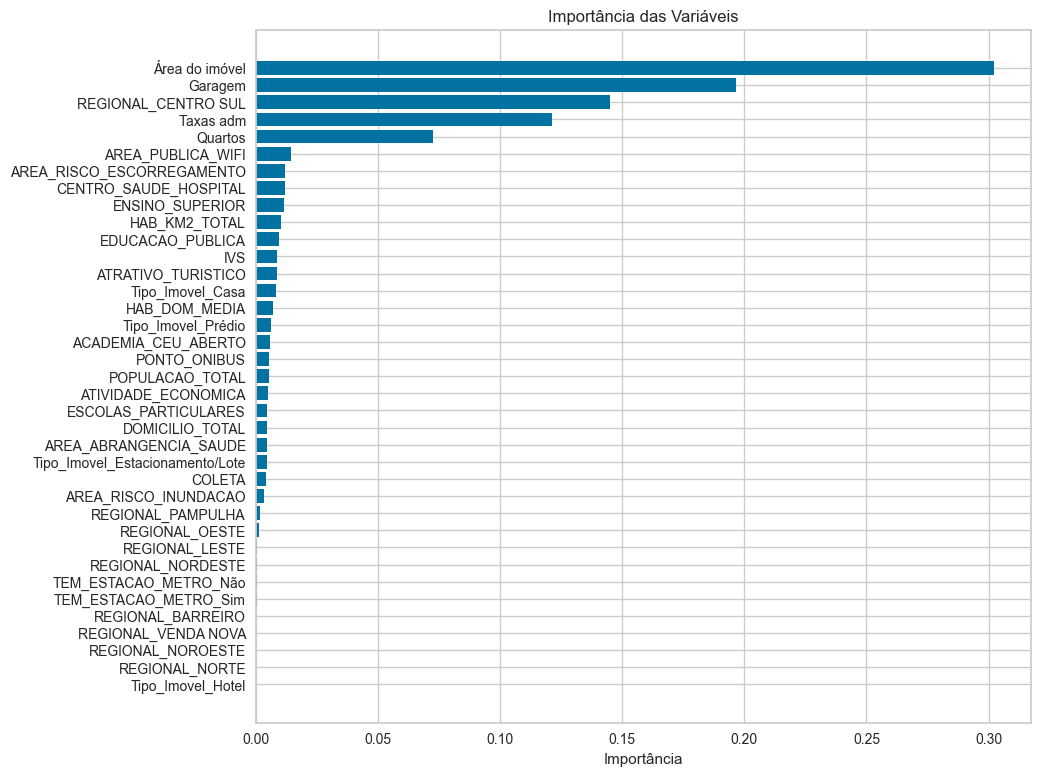

In [203]:
nomes_variaveis, importancias = zip(*importances_sorted)
plt.figure(figsize=(10, 9))
plt.barh(range(len(nomes_variaveis)), importancias, align='center')
plt.yticks(range(len(nomes_variaveis)), nomes_variaveis)
plt.xlabel('Importância')
plt.title('Importância das Variáveis')
plt.gca().invert_yaxis()
plt.show()

Previsões para um imóvel

In [204]:
X_teste.iloc[0]

Taxas adm                            200.00
Garagem                                2.00
Quartos                                3.00
Área do imóvel                        93.00
ACADEMIA_CEU_ABERTO                    0.00
AREA_ABRANGENCIA_SAUDE                 0.00
AREA_PUBLICA_WIFI                      0.00
AREA_RISCO_ESCORREGAMENTO              0.00
AREA_RISCO_INUNDACAO                   0.00
ATIVIDADE_ECONOMICA                 3864.00
ATRATIVO_TURISTICO                     2.00
COLETA                               473.00
ESCOLAS_PARTICULARES                  15.00
ENSINO_SUPERIOR                        4.00
IVS                                    0.00
PONTO_ONIBUS                         612.00
POPULACAO_TOTAL                    11841.00
DOMICILIO_TOTAL                     4709.00
HAB_KM2_TOTAL                      10794.00
HAB_DOM_MEDIA                          2.51
CENTRO_SAUDE_HOSPITAL                  1.00
EDUCACAO_PUBLICA                       2.00
REGIONAL_BARREIRO               

In [205]:
predicted_price = modelo_ExtraTree.predict([X_teste.iloc[0]])
print(f"Preço previsto para novo imóvel: {predicted_price[0]:.2f}")

Preço previsto para novo imóvel: 597172.62


Visualização da árvore

In [206]:
from sklearn.tree import plot_tree

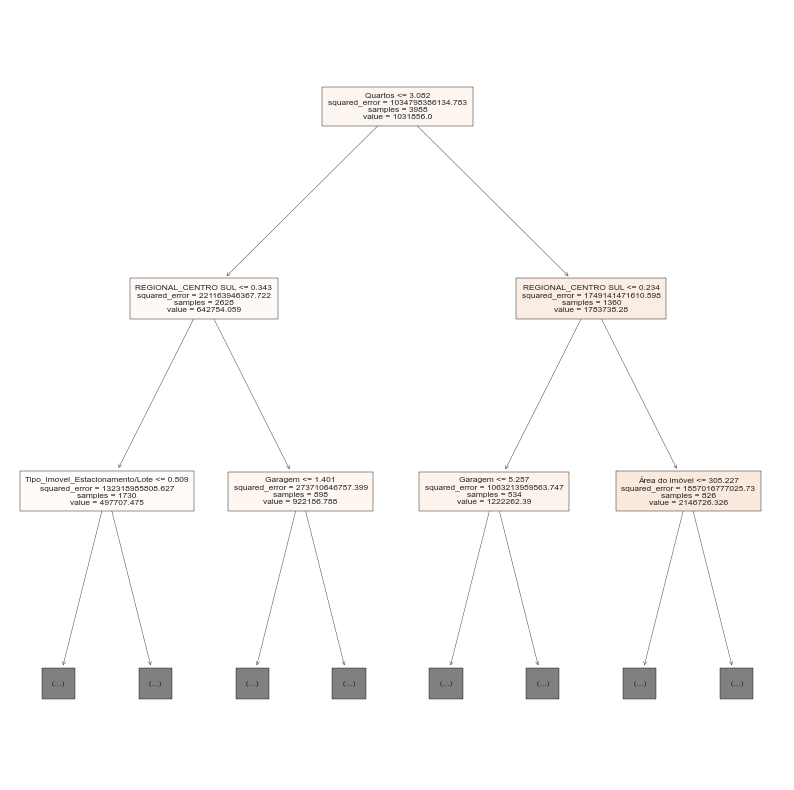

In [207]:
plt.figure(figsize=(10, 10))
plot_tree(modelo_ExtraTree.estimators_[0], filled=True, feature_names=X_treino.columns, max_depth=2, fontsize=6)
plt.show()

# Extras

E se não tivéssemos adicionado nenhuma variável?

In [208]:
dados_pycaret2 = dados_completos1[['Preço','Taxas adm','Garagem','Quartos','Área do imóvel']]
    #'REGIONAL_BARREIRO','REGIONAL_CENTRO SUL','REGIONAL_LESTE','REGIONAL_NORDESTE','REGIONAL_NOROESTE','REGIONAL_NORTE',
    #'REGIONAL_OESTE','REGIONAL_PAMPULHA','REGIONAL_VENDA NOVA']]

modelo2 = setup(data = dados_pycaret2, target='Preço', normalize = False, train_size = 0.8, fold = 10, session_id=13)
compare_models(sort = 'MAPE')

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=13, ...)

In [209]:
X_treino2 = treino[['Taxas adm','Garagem','Quartos','Área do imóvel']]
                    #'REGIONAL_BARREIRO','REGIONAL_CENTRO SUL','REGIONAL_LESTE','REGIONAL_NORDESTE',
                    #'REGIONAL_NOROESTE','REGIONAL_NORTE','REGIONAL_OESTE','REGIONAL_PAMPULHA','REGIONAL_VENDA NOVA']]
X_teste2 = teste[['Taxas adm','Garagem','Quartos','Área do imóvel']]
                  #'REGIONAL_BARREIRO','REGIONAL_CENTRO SUL','REGIONAL_LESTE','REGIONAL_NORDESTE',
                  #'REGIONAL_NOROESTE','REGIONAL_NORTE','REGIONAL_OESTE','REGIONAL_PAMPULHA','REGIONAL_VENDA NOVA']]
Y_treino2, Y_teste2 = treino[['Preço']], teste[['Preço']]

In [210]:
param_space_RF2 = {'n_estimators': Integer(10, 3000), 'max_depth': np.arange(1, 20, 1),
                  'max_features': ['auto', 'sqrt'], 'min_samples_split': np.arange(2, 30, 1),
                  'min_samples_leaf': np.arange(1, 20, 1)}
RF_mod2 = RandomForestRegressor(random_state=13)
opt_RF2 = BayesSearchCV(RF_mod2, param_space_RF2, cv=10, n_jobs=-1, scoring=scoring, n_iter=25).fit(X_treino2, Y_treino2)
modelo_RF2 = RandomForestRegressor(random_state=13, **opt_RF2.best_params_).fit(X_treino2, Y_treino2)

In [211]:
AvaliaçãoModelosRegressão(modelo_RF2.predict(X_teste2), Y_teste2, X_treino2).round(3)

R2  Adjusted R2         MAE   MAPE           MSE       RMSE  RMSLE
0  0.702        0.701  323445.669  0.295  4.520869e+11  672374.07   0.13

In [212]:
#Modelo com todas as variáveis
AvaliaçãoModelosRegressão(modelo_RF.predict(X_teste), Y_teste, X_treino).round(3)

R2  Adjusted R2         MAE   MAPE           MSE        RMSE  RMSLE
0  0.806        0.799  233197.259  0.208  2.944569e+11  542638.868   0.07

O aumento no MAPE considerando apenas as variáveis que estavam inicialmente e as que foram adicionadas foi de 9,5%.

In [213]:
teste['Predições'] = modelo_ExtraTree.predict(X_teste)

Segmentação por regional

In [214]:
regionais = ['CENTRO SUL', 'NORDESTE', 'PAMPULHA', 'LESTE', 'NOROESTE', 'OESTE', 'VENDA NOVA', 'NORTE', 'BARREIRO']
resultados_modelos_reg = pd.DataFrame(columns=['Região', 'R2', 'Adjusted R2', 'MAE', 'MAPE', 'MSE', 'RMSE', 'RMSLE'])
for regiao in regionais:
    filtro = teste['REGIONAL'] == regiao
    metrics_df = AvaliaçãoModelosRegressão(teste[filtro]['Predições'], teste[filtro]['Preço']).round(3)
    metrics_df['Região'] = regiao
    resultados_modelos_reg = pd.concat([resultados_modelos_reg, metrics_df], ignore_index=True)
resultados_modelos_reg

Região  R2  Adjusted R2         MAE   MAPE           MSE        RMSE  \
0  CENTRO SUL NaN          NaN  299841.059  0.192  4.251081e+11  652003.140   
1    NORDESTE NaN          NaN   97130.177  0.186  2.465603e+10  157022.372   
2    PAMPULHA NaN          NaN  190345.164  0.241  1.412648e+11  375852.124   
3       LESTE NaN          NaN  136864.499  0.183  6.324884e+10  251493.213   
4    NOROESTE NaN          NaN  200334.251  0.287  1.847829e+11  429863.857   
5       OESTE NaN          NaN  187230.693  0.176  3.707287e+11  608874.964   
6  VENDA NOVA NaN          NaN   83528.142  0.217  1.707331e+10  130664.890   
7       NORTE NaN          NaN  100280.939  0.189  1.834244e+10  135434.269   
8    BARREIRO NaN          NaN  255146.061  0.258  2.899785e+11  538496.515   

   RMSLE  
0  0.066  
1  0.049  
2  0.088  
3  0.056  
4  0.101  
5  0.061  
6  0.065  
7  0.051  
8  0.160

A regional Noroeste teve maior erro, faz sentido fazer um modelo apenas para ela?

In [215]:
treino_noroeste = treino[treino['REGIONAL'] == 'NOROESTE']
teste_noroeste = teste[teste['REGIONAL'] == 'NOROESTE']
X_treino_noroeste = treino_noroeste[['Taxas adm','Garagem','Quartos','Área do imóvel','ACADEMIA_CEU_ABERTO','AREA_ABRANGENCIA_SAUDE',
                   'AREA_PUBLICA_WIFI','AREA_RISCO_ESCORREGAMENTO','AREA_RISCO_INUNDACAO','ATIVIDADE_ECONOMICA',
                   'ATRATIVO_TURISTICO','CENTRO_SAUDE','COLETA','CRECHES_CONVENIADAS','ESCOLAS_ESTADUAIS',
                   'ESCOLAS_MUNICIPAIS_ENSINO_FUNDAMENTAL','ESCOLAS_PARTICULARES','ENSINO_SUPERIOR','HOSPITAIS','IVS',
                   'PONTO_ONIBUS','POPULACAO_TOTAL','DOMICILIO_TOTAL','HAB_KM2_TOTAL','HAB_DOM_MEDIA','CENTRO_SAUDE_HOSPITAL',
                   'EDUCACAO_PUBLICA','REGIONAL_BARREIRO','REGIONAL_CENTRO SUL','REGIONAL_LESTE','REGIONAL_NORDESTE',
                   'REGIONAL_NOROESTE','REGIONAL_NORTE','REGIONAL_OESTE','REGIONAL_PAMPULHA','REGIONAL_VENDA NOVA',
                   'Tipo_Imovel_Casa','Tipo_Imovel_Estacionamento/Lote','Tipo_Imovel_Hotel','Tipo_Imovel_Prédio',
                   'TEM_ESTACAO_METRO_Não','TEM_ESTACAO_METRO_Sim']]
X_teste_noroeste = teste_noroeste[['Taxas adm','Garagem','Quartos','Área do imóvel','ACADEMIA_CEU_ABERTO','AREA_ABRANGENCIA_SAUDE',
                 'AREA_PUBLICA_WIFI','AREA_RISCO_ESCORREGAMENTO','AREA_RISCO_INUNDACAO','ATIVIDADE_ECONOMICA',
                 'ATRATIVO_TURISTICO','CENTRO_SAUDE','COLETA','CRECHES_CONVENIADAS','ESCOLAS_ESTADUAIS',
                 'ESCOLAS_MUNICIPAIS_ENSINO_FUNDAMENTAL','ESCOLAS_PARTICULARES','ENSINO_SUPERIOR','HOSPITAIS','IVS',
                 'PONTO_ONIBUS','POPULACAO_TOTAL','DOMICILIO_TOTAL','HAB_KM2_TOTAL','HAB_DOM_MEDIA','CENTRO_SAUDE_HOSPITAL',
                 'EDUCACAO_PUBLICA','REGIONAL_BARREIRO','REGIONAL_CENTRO SUL','REGIONAL_LESTE','REGIONAL_NORDESTE',
                 'REGIONAL_NOROESTE','REGIONAL_NORTE','REGIONAL_OESTE','REGIONAL_PAMPULHA','REGIONAL_VENDA NOVA',
                 'Tipo_Imovel_Casa','Tipo_Imovel_Estacionamento/Lote','Tipo_Imovel_Hotel','Tipo_Imovel_Prédio',
                 'TEM_ESTACAO_METRO_Não','TEM_ESTACAO_METRO_Sim']]
Y_treino_noroeste, Y_teste_noroeste = treino_noroeste[['Preço']], teste_noroeste[['Preço']]

In [216]:
param_space_ExtraTree_noroeste = {'max_depth': np.arange(1, 20, 1), 'max_features': ['auto', 'sqrt'],
                         'min_samples_split': np.arange(2, 30, 1), 'min_samples_leaf': np.arange(1, 20, 1),
                         'n_estimators': Integer(1, 200)}
ExtraTree_mod_noroeste = ExtraTreesRegressor(random_state=13)
opt_ExtraTree_noroeste = BayesSearchCV(ExtraTree_mod_noroeste, param_space_ExtraTree_noroeste, cv=10, n_jobs=-1, 
                                       scoring=scoring, n_iter=25).fit(X_treino_noroeste, Y_treino_noroeste)
modelo_ExtraTree_noroeste = ExtraTreesRegressor(random_state=13, 
                                                **opt_ExtraTree_noroeste.best_params_).fit(X_treino_noroeste, Y_treino_noroeste)

In [217]:
AvaliaçãoModelosRegressão(modelo_ExtraTree_noroeste.predict(X_teste_noroeste), Y_teste_noroeste, X_treino_noroeste).round(3)

R2  Adjusted R2         MAE   MAPE           MSE      RMSE  RMSLE
0  0.525         2.74  210584.222  0.301  1.343482e+11  366535.4  0.131

O MAPE foi reduzido, talvez seja interessante seguir com essa abordagem.

Mapa de calor da localização dos imóveis.

In [218]:
import folium
from folium import plugins
order_by_median = dados_completos.groupby(by=["Bairro"])["Preço_m2"].mean().sort_values(ascending=True).index
latitude_list = []
longitude_list = []
label_area_kmeans = []
for i in order_by_median[-5:]:
    expensive_areas = dados_completos.loc[(dados_completos['Bairro'] == i)]
    latitude_list.append(expensive_areas['Latitude'][0:1])
    longitude_list.append(expensive_areas['Longitude'][0:1])
    label_area_kmeans.append(i)
latitude_list_less = []
longitude_list_less = []
label_area_kmeans_less = []
for i in order_by_median[0:5]:
    less_expensive_areas = dados_completos.loc[(dados_completos['Bairro'] == i)]
    latitude_list_less.append(less_expensive_areas['Latitude'][0:1])
    longitude_list_less.append(less_expensive_areas['Longitude'][0:1])
    label_area_kmeans_less.append(i)

heatmap = dados_completos.copy()
heatmap['count'] = 1
base_heatmap = folium.Map(location=['-19.9191197', '-43.941204'], zoom_start=12)
for a, b, c in zip(latitude_list, longitude_list, label_area_kmeans):    
    folium.Marker((a, b), popup=c, icon=folium.Icon(color='red')).add_to(base_heatmap)
for a, b, c in zip(latitude_list_less, longitude_list_less, label_area_kmeans_less):    
    folium.Marker((a, b), popup=c, icon=folium.Icon(color='darkblue')).add_to(base_heatmap)
plugins.HeatMap(data=heatmap[['Latitude', 'Longitude', 
                              'count']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(), 
                radius=8, max_zoom=4).add_to(base_heatmap)
base_heatmap